In [1]:
import itertools
from cwgp.grid_search import grid_search
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import GPy
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import scipy

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def exp(x, *par):
    return par[0]*np.exp(par[1]*x)

In [4]:
def poly(x, *par):
    return np.polyval(par,x)

In [5]:
def log(x, *par):
    return par[0]*np.log(x)

In [6]:
def const(x, *par):
    return 0

In [7]:
def cwgp_regression(x_train, y_train, cwgp_model, **kwargs):
    kernel = GPy.kern.RBF(1)


    res = scipy.optimize.curve_fit(poly,  np.ravel(x_train), np.ravel(y_train), p0=(-1,-1), maxfev=3000)
    par = res[0]
    print(f"params:{par}")
    mf = GPy.core.Mapping(1,1)
    mf.f = lambda x: poly(x, *par)
    mf.update_gradients = lambda a,b: None


    model = GPy.models.GPRegression(x_train, y_train, mean_function=mf, kernel=kernel)
    model.optimize()

    
    start, end = 1940, 2031
    start_align = np.min(x_train)-start
    domain_discrete = np.arange(start, end).reshape(-1,1)
    y_all = model.predict(domain_discrete)
    y_mean,y_var = y_all[0],y_all[1]
    y_top, y_bot = y_mean + 1.96*np.sqrt(y_var), y_mean - 1.96*np.sqrt(y_var)

    for cwgp in cwgp_model[::-1]:
        y_train = cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_train)
        y_mean, y_var = cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_mean), cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_var)
        y_top, y_bot = cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_top), cwgp.phi.inv_comp_phi(cwgp.phi.res.x, y_bot)


    validate_rmse = mean_squared_error(y_val, y_mean[train_up+start_align:train_up+start_align+validate], squared=False)
    validate_mae = mean_absolute_error(y_val, y_mean[train_up+start_align:train_up+start_align+validate])
    test_rmse = mean_squared_error(y_test, y_mean[train_up+start_align+validate:train_up+start_align+validate+test], squared=False)
    test_mae = mean_absolute_error(y_test, y_mean[train_up+start_align+validate:train_up+start_align+validate+test])
    txt = f"""validate rmse : {validate_rmse} \n validate mae : {validate_mae} \n
    test rmse : {test_rmse} \n test mae : {test_mae}"""

    
    if validate_rmse < 0.002:
        name = [f"{cwgp.phi.fn.__name__}_{cwgp.phi.n}" for cwgp in cwgp_model]
        name = "_".join(name)
        domain = np.linspace(1940,2030,91)
        plt.fill_between(domain, np.ravel(y_top), np.ravel(y_bot), color=(0,0.5,0.5,0.2), label="Confidence")
        plt.scatter(x_train,y_train, marker="x", color='black', label="data")
        plt.scatter(x_val,y_val, marker="x", color='red', label="validate")
        plt.scatter(x_test, y_test, marker="x", color='blue', label="test")
        plt.plot(np.linspace(1940,2030,91),y_mean, label="mean")
        plt.ylim([0.1,0.35])
        plt.legend()
        plt.figtext(0.5, 0.2, txt, wrap=True, horizontalalignment='center', fontsize=12)
        plt.grid(True)
        plt.show()



    print(txt)
    return txt

In [8]:
CSV_FIlE = "../japan3.csv"
df = pd.read_csv(CSV_FIlE)
age = 90
df_all = {}
df_all[age]= df[(df["age"]==age)]

year = df_all[age]["year"].to_numpy().reshape(-1,1)
rate = df_all[age]["rate"].to_numpy().reshape(-1,1)


In [9]:
train_ratio, validate_ratio, test_ratio = 0.8, 0.1, 0.1
length = len(rate)

train, validate, test = int(train_ratio*length), int(validate_ratio*length), int(test_ratio*length)
train_up, train_low = train, train-train

In [10]:
x_train, y_train = year[train_low:train_up],rate[train_low:train_up]
x_val, y_val = year[train_up:train_up+validate],rate[train_up:train_up+validate]
x_test, y_test = year[train_up+validate:],rate[train_up+validate:]

  0%|          | 0/1296 [00:00<?, ?it/s]

[('sa', 1), ('sa', 2), ('sal', 1), ('sal', 2), ('box_cox', 1), ('box_cox', 2)]
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 1))


  0%|          | 1/1296 [00:00<11:33,  1.87it/s]

params:[-8.20155454e-02  1.61944511e+02]
validate rmse : 0.006237246834713726 
 validate mae : 0.005922953096292629 

    test rmse : 0.005587769474788027 
 test mae : 0.004666267526493557
(('sa', 1), ('sa', 1), ('sa', 1), ('sa', 2))


  0%|          | 2/1296 [00:01<12:14,  1.76it/s]

params:[-8.20155153e-02  1.61944452e+02]
validate rmse : 0.006237248572716559 
 validate mae : 0.005922955025724268 

    test rmse : 0.005587767216888224 
 test mae : 0.004666265947204128
(('sa', 1), ('sa', 1), ('sa', 1), ('sal', 1))


  0%|          | 3/1296 [00:03<25:20,  1.18s/it]

params:[-1.08152118e-01  2.13535565e+02]
validate rmse : 0.003934435816131272 
 validate mae : 0.003449150573025409 

    test rmse : 0.015027553307679943 
 test mae : 0.01490562501834942
(('sa', 1), ('sa', 1), ('sa', 1), ('sal', 2))


  0%|          | 4/1296 [00:04<25:32,  1.19s/it]

params:[-7.98338855e-02  1.58690748e+02]
validate rmse : 0.004656840367362329 
 validate mae : 0.004284263107492137 

    test rmse : 0.0028573183270003185 
 test mae : 0.002146735963899427
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))


  0%|          | 5/1296 [00:04<20:09,  1.07it/s]

params:[-8.61787207e-02  1.69067335e+02]
validate rmse : 0.004816096187386926 
 validate mae : 0.004447021490066003 

    test rmse : 0.0036430758713044417 
 test mae : 0.0032575915492717633
(('sa', 1), ('sa', 1), ('sa', 1), ('box_cox', 2))


  0%|          | 6/1296 [00:05<18:11,  1.18it/s]

params:[-8.41239497e-02  1.63879233e+02]
validate rmse : 0.006846459923839538 
 validate mae : 0.006618797708041797 

    test rmse : 0.0032911068998083986 
 test mae : 0.0029081959412389185
(('sa', 1), ('sa', 1), ('sa', 2), ('sa', 1))


  1%|          | 7/1296 [00:06<17:00,  1.26it/s]

params:[-8.20155384e-02  1.61944497e+02]
validate rmse : 0.006237245479668995 
 validate mae : 0.005922951684588118 

    test rmse : 0.005587768401798799 
 test mae : 0.004666266549538016
(('sa', 1), ('sa', 1), ('sa', 2), ('sa', 2))


  1%|          | 8/1296 [00:06<17:26,  1.23it/s]

params:[-8.20155175e-02  1.61944456e+02]
validate rmse : 0.0062372448154590565 
 validate mae : 0.005922951051470845 

    test rmse : 0.005587766018668379 
 test mae : 0.00466626462578252
(('sa', 1), ('sa', 1), ('sa', 2), ('sal', 1))


  1%|          | 9/1296 [00:08<25:28,  1.19s/it]

params:[-1.08262544e-01  2.13755767e+02]
validate rmse : 0.003911008051609526 
 validate mae : 0.0034316142401221994 

    test rmse : 0.014961100303531032 
 test mae : 0.014839065803025695
(('sa', 1), ('sa', 1), ('sa', 2), ('sal', 2))
params:[-1. -1.]


  1%|          | 10/1296 [00:30<2:43:20,  7.62s/it]

validate rmse : 0.02841459817068356 
 validate mae : 0.028227617294497725 

    test rmse : 0.03276553662682801 
 test mae : 0.03246604213854782
(('sa', 1), ('sa', 1), ('sa', 2), ('box_cox', 1))


  1%|          | 11/1296 [00:31<1:58:01,  5.51s/it]

params:[-8.61788429e-02  1.69067576e+02]
validate rmse : 0.004816069333094828 
 validate mae : 0.0044469931260567265 

    test rmse : 0.0036430406240172083 
 test mae : 0.00325756368199697
(('sa', 1), ('sa', 1), ('sa', 2), ('box_cox', 2))


  1%|          | 12/1296 [00:32<1:27:19,  4.08s/it]

params:[-8.41239916e-02  1.63879316e+02]
validate rmse : 0.006846400904826516 
 validate mae : 0.006618736652155439 

    test rmse : 0.0032910442879004044 
 test mae : 0.002908152204460957
(('sa', 1), ('sa', 1), ('sal', 1), ('sa', 1))


  1%|          | 13/1296 [00:34<1:12:51,  3.41s/it]

params:[-1.08355392e-01  2.13991764e+02]
validate rmse : 0.00399258882407155 
 validate mae : 0.003489196957198614 

    test rmse : 0.015136275468780469 
 test mae : 0.01501484328647955
(('sa', 1), ('sa', 1), ('sal', 1), ('sa', 2))


  1%|          | 14/1296 [00:36<1:04:22,  3.01s/it]

params:[-1.08291927e-01  2.13849016e+02]
validate rmse : 0.0041260629523449015 
 validate mae : 0.0035885484650758715 

    test rmse : 0.015522205966860596 
 test mae : 0.015400970688904546
(('sa', 1), ('sa', 1), ('sal', 1), ('sal', 1))


  1%|          | 15/1296 [00:38<55:59,  2.62s/it]  

params:[-1.06411226e-01  2.09984024e+02]
validate rmse : 0.00416346864686594 
 validate mae : 0.0036099911321708566 

    test rmse : 0.015628456056225582 
 test mae : 0.015506211815673033
(('sa', 1), ('sa', 1), ('sal', 1), ('sal', 2))


  1%|          | 16/1296 [00:44<1:20:08,  3.76s/it]

params:[-1.08939456e-01  2.14555251e+02]
validate rmse : 0.00883500659294432 
 validate mae : 0.007896240042192502 

    test rmse : 0.025805964794052155 
 test mae : 0.02564392436952888
(('sa', 1), ('sa', 1), ('sal', 1), ('box_cox', 1))


  1%|▏         | 17/1296 [00:46<1:07:46,  3.18s/it]

params:[-1.06006095e-01  2.08413513e+02]
validate rmse : 0.0021374674559518614 
 validate mae : 0.0017506251476731452 

    test rmse : 0.008108095727871781 
 test mae : 0.007869016575890715
(('sa', 1), ('sa', 1), ('sal', 1), ('box_cox', 2))


  1%|▏         | 18/1296 [00:48<57:46,  2.71s/it]  

params:[-1.08296457e-01  2.11797050e+02]
validate rmse : 0.002612240422877651 
 validate mae : 0.0018712907539798485 

    test rmse : 0.011601269405077486 
 test mae : 0.011435821239407768
(('sa', 1), ('sa', 1), ('sal', 2), ('sa', 1))


  1%|▏         | 19/1296 [01:03<2:22:24,  6.69s/it]

params:[-1.10910238e-01  2.19036811e+02]
validate rmse : 0.00473126103771296 
 validate mae : 0.003974259146232887 

    test rmse : 0.016179001876856 
 test mae : 0.016066106191217146
(('sa', 1), ('sa', 1), ('sal', 2), ('sa', 2))


  2%|▏         | 20/1296 [01:07<2:00:29,  5.67s/it]

params:[-7.98432089e-02  1.58344111e+02]
validate rmse : 0.004882840508586724 
 validate mae : 0.004170114648080437 

    test rmse : 0.008059491172749915 
 test mae : 0.006852077588936217
(('sa', 1), ('sa', 1), ('sal', 2), ('sal', 1))


  2%|▏         | 21/1296 [01:27<3:30:10,  9.89s/it]

params:[-1.09159613e-01  2.15613852e+02]
validate rmse : 0.0020302528715879942 
 validate mae : 0.0017369295634542656 

    test rmse : 0.005263602551895159 
 test mae : 0.0047219480860898845
(('sa', 1), ('sa', 1), ('sal', 2), ('sal', 2))


  2%|▏         | 22/1296 [01:49<4:48:36, 13.59s/it]

params:[-3.79971719e-07  5.40242780e-01]
validate rmse : 0.8509546215546281 
 validate mae : 0.849283577152321 

    test rmse : 1.0487394929662774 
 test mae : 1.0472460680193714
(('sa', 1), ('sa', 1), ('sal', 2), ('box_cox', 1))


  2%|▏         | 23/1296 [01:53<3:50:09, 10.85s/it]

params:[-1.30837353e-02  3.16394479e+01]
validate rmse : 0.49282202617900034 
 validate mae : 0.321997901439872 

    test rmse : 0.7458745910051172 
 test mae : 0.7452384424991708
(('sa', 1), ('sa', 1), ('sal', 2), ('box_cox', 2))


  2%|▏         | 24/1296 [01:56<2:56:18,  8.32s/it]

params:[-3.30416629e-02  6.91920067e+01]
validate rmse : 0.0037716642839136835 
 validate mae : 0.003326608629629948 

    test rmse : 0.014579952717766879 
 test mae : 0.014456815017107771
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))


  2%|▏         | 25/1296 [01:56<2:05:49,  5.94s/it]

params:[-8.08699208e-02  1.58934747e+02]
validate rmse : 0.007277080319696905 
 validate mae : 0.00706303540607126 

    test rmse : 0.003612677697878006 
 test mae : 0.0031260887021274226
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sa', 2))


  2%|▏         | 26/1296 [01:57<1:31:14,  4.31s/it]

params:[-8.08699629e-02  1.58934829e+02]
validate rmse : 0.007277062668223243 
 validate mae : 0.007063017216915026 

    test rmse : 0.0036126565592583654 
 test mae : 0.0031260683463608502
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sal', 1))


  2%|▏         | 27/1296 [02:01<1:32:55,  4.39s/it]

params:[-1.08802802e-01  2.14852031e+02]
validate rmse : 0.002171200123207555 
 validate mae : 0.0019311857313330874 

    test rmse : 0.008399995017459156 
 test mae : 0.008132373195258403
(('sa', 1), ('sa', 1), ('box_cox', 1), ('sal', 2))
params:[-2.40618147e+01  4.69336973e+04]


  2%|▏         | 28/1296 [02:04<1:20:21,  3.80s/it]

validate rmse : 0.002006277156880058 
 validate mae : 0.001712385868833036 

    test rmse : 0.004078428296277692 
 test mae : 0.003632165441614214
(('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))


  2%|▏         | 29/1296 [02:04<59:18,  2.81s/it]  

params:[-8.76725109e-02  1.70806621e+02]
validate rmse : 0.005137561338089504 
 validate mae : 0.0048189223996106135 

    test rmse : 0.0024669451836741908 
 test mae : 0.0018176907041790788
(('sa', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 2))


  2%|▏         | 30/1296 [02:04<44:07,  2.09s/it]

params:[-8.12040297e-02  1.56960886e+02]
validate rmse : 0.0039757812781027815 
 validate mae : 0.003541610796401485 

    test rmse : 0.003311294594110993 
 test mae : 0.002648859712342276
(('sa', 1), ('sa', 1), ('box_cox', 2), ('sa', 1))


  2%|▏         | 31/1296 [02:05<33:46,  1.60s/it]

params:[-7.26523464e-02  1.41954392e+02]
validate rmse : 0.006108148805163572 
 validate mae : 0.005851295619231153 

    test rmse : 0.0028997096569741997 
 test mae : 0.0026134963233044634
(('sa', 1), ('sa', 1), ('box_cox', 2), ('sa', 2))


  2%|▏         | 32/1296 [02:06<27:41,  1.31s/it]

params:[-7.26524157e-02  1.41954530e+02]
validate rmse : 0.006108127066649289 
 validate mae : 0.005851272921061158 

    test rmse : 0.0028996944619376942 
 test mae : 0.00261348264075719
(('sa', 1), ('sa', 1), ('box_cox', 2), ('sal', 1))


  3%|▎         | 33/1296 [02:06<25:29,  1.21s/it]

params:[-1.01178182e-01  1.99873811e+02]
validate rmse : 0.006596345539671672 
 validate mae : 0.006359269256523747 

    test rmse : 0.002855369089894924 
 test mae : 0.0025668623597166645
(('sa', 1), ('sa', 1), ('box_cox', 2), ('sal', 2))


  3%|▎         | 34/1296 [02:27<2:27:06,  6.99s/it]

params:[-1.10998503e-01  2.19142395e+02]
validate rmse : 0.0022596001930607693 
 validate mae : 0.0019290414465354241 

    test rmse : 0.010183068813018139 
 test mae : 0.01001103396200932
(('sa', 1), ('sa', 1), ('box_cox', 2), ('box_cox', 1))


  3%|▎         | 35/1296 [02:28<1:46:28,  5.07s/it]

params:[-7.94788644e-02  1.53602595e+02]
validate rmse : 0.005172077168198077 
 validate mae : 0.004863692895956256 

    test rmse : 0.002445971957111178 
 test mae : 0.0020053513558602226
(('sa', 1), ('sa', 1), ('box_cox', 2), ('box_cox', 2))


  3%|▎         | 36/1296 [02:28<1:17:39,  3.70s/it]

params:[-6.99777559e-02  1.33816149e+02]
validate rmse : 0.004090197883860897 
 validate mae : 0.0036847459518008657 

    test rmse : 0.0029595351780836183 
 test mae : 0.0022291016952362607
(('sa', 1), ('sa', 2), ('sa', 1), ('sa', 1))


  3%|▎         | 37/1296 [02:29<59:11,  2.82s/it]  

params:[-8.20155206e-02  1.61944462e+02]
validate rmse : 0.006237246080436867 
 validate mae : 0.005922952371297625 

    test rmse : 0.005587767037065301 
 test mae : 0.004666265547335632
(('sa', 1), ('sa', 2), ('sa', 1), ('sa', 2))


  3%|▎         | 38/1296 [02:30<46:35,  2.22s/it]

params:[-8.20155157e-02  1.61944452e+02]
validate rmse : 0.006237241694119463 
 validate mae : 0.0059229477450906875 

    test rmse : 0.005587765312583249 
 test mae : 0.0046662637469530545
(('sa', 1), ('sa', 2), ('sa', 1), ('sal', 1))


  3%|▎         | 39/1296 [02:32<45:07,  2.15s/it]

params:[-1.08247316e-01  2.13722406e+02]
validate rmse : 0.003941464247830935 
 validate mae : 0.0034544815265962403 

    test rmse : 0.015048641691668389 
 test mae : 0.014926736705929517
(('sa', 1), ('sa', 2), ('sa', 1), ('sal', 2))
params:[-1.06156427e-01  2.09565185e+02]


  3%|▎         | 40/1296 [02:44<1:49:18,  5.22s/it]

validate rmse : 0.0029980019766652584 
 validate mae : 0.002449300333491694 

    test rmse : 0.004704222487768376 
 test mae : 0.004166242573968697
(('sa', 1), ('sa', 2), ('sa', 1), ('box_cox', 1))


  3%|▎         | 41/1296 [02:45<1:20:23,  3.84s/it]

params:[-8.61786915e-02  1.69067278e+02]
validate rmse : 0.004816103878900936 
 validate mae : 0.004447029612330059 

    test rmse : 0.0036430859573505256 
 test mae : 0.0032575995231289884
(('sa', 1), ('sa', 2), ('sa', 1), ('box_cox', 2))


  3%|▎         | 42/1296 [02:45<59:40,  2.86s/it]  

params:[-8.41239942e-02  1.63879319e+02]
validate rmse : 0.006846440431990503 
 validate mae : 0.0066187775448971874 

    test rmse : 0.0032910856433127533 
 test mae : 0.0029081810613611875
(('sa', 1), ('sa', 2), ('sa', 2), ('sa', 1))


  3%|▎         | 43/1296 [02:46<46:40,  2.24s/it]

params:[-8.20155198e-02  1.61944460e+02]
validate rmse : 0.006237242734340285 
 validate mae : 0.0059229488413414955 

    test rmse : 0.0055877656764624795 
 test mae : 0.004666264142044978
(('sa', 1), ('sa', 2), ('sa', 2), ('sa', 2))


  3%|▎         | 44/1296 [02:47<37:58,  1.82s/it]

params:[-8.20155915e-02  1.61944599e+02]
validate rmse : 0.006237226434318989 
 validate mae : 0.005922931384074154 

    test rmse : 0.005587767562613851 
 test mae : 0.0046662639091068926
(('sa', 1), ('sa', 2), ('sa', 2), ('sal', 1))


  3%|▎         | 45/1296 [02:50<48:27,  2.32s/it]

params:[-1.08203295e-01  2.13643283e+02]
validate rmse : 0.003837404748349141 
 validate mae : 0.0033758886706593866 

    test rmse : 0.014745933347966863 
 test mae : 0.014623490017944222
(('sa', 1), ('sa', 2), ('sa', 2), ('sal', 2))
params:[-1.60225920e+08  3.14656372e+11]


  4%|▎         | 46/1296 [03:31<4:44:56, 13.68s/it]

validate rmse : 0.015989262933506703 
 validate mae : 0.01573100212054621 

    test rmse : 0.01886125443626967 
 test mae : 0.018421005173081963
(('sa', 1), ('sa', 2), ('sa', 2), ('box_cox', 1))


  4%|▎         | 47/1296 [03:31<3:23:33,  9.78s/it]

params:[-8.61786966e-02  1.69067288e+02]
validate rmse : 0.0048161011733257155 
 validate mae : 0.0044470267281791565 

    test rmse : 0.003643083370497444 
 test mae : 0.003257597489689651
(('sa', 1), ('sa', 2), ('sa', 2), ('box_cox', 2))


  4%|▎         | 48/1296 [03:32<2:26:29,  7.04s/it]

params:[-8.41237057e-02  1.63878749e+02]
validate rmse : 0.006846673964648589 
 validate mae : 0.006619019146322962 

    test rmse : 0.003291327573543545 
 test mae : 0.002908349753077692
(('sa', 1), ('sa', 2), ('sal', 1), ('sa', 1))


  4%|▍         | 49/1296 [03:36<2:06:20,  6.08s/it]

params:[-1.08331209e-01  2.13944352e+02]
validate rmse : 0.003976567961458822 
 validate mae : 0.003477195585515319 

    test rmse : 0.015090723654916137 
 test mae : 0.014969222019661705
(('sa', 1), ('sa', 2), ('sal', 1), ('sa', 2))


  4%|▍         | 50/1296 [03:38<1:43:36,  4.99s/it]

params:[-1.08298253e-01  2.13863327e+02]
validate rmse : 0.004109996948640092 
 validate mae : 0.0035765414468403233 

    test rmse : 0.015473830964593191 
 test mae : 0.015352616000006116
(('sa', 1), ('sa', 2), ('sal', 1), ('sal', 1))


  4%|▍         | 51/1296 [03:41<1:28:56,  4.29s/it]

params:[-1.06437287e-01  2.10035229e+02]
validate rmse : 0.004187911481741045 
 validate mae : 0.0036278046751471132 

    test rmse : 0.01569300304930834 
 test mae : 0.015570790201845184
(('sa', 1), ('sa', 2), ('sal', 1), ('sal', 2))
params:[-2.04880936e+07  4.07248625e+10]


  4%|▍         | 52/1296 [04:01<3:06:34,  9.00s/it]

validate rmse : 0.016546899477798017 
 validate mae : 0.01638427393040146 

    test rmse : 0.016304867154512542 
 test mae : 0.015903478725552287
(('sa', 1), ('sa', 2), ('sal', 1), ('box_cox', 1))


  4%|▍         | 53/1296 [04:03<2:24:17,  6.96s/it]

params:[-1.06032048e-01  2.08450986e+02]
validate rmse : 0.0021390988208482673 
 validate mae : 0.001762617799819641 

    test rmse : 0.008334004696855614 
 test mae : 0.008105887670541576
(('sa', 1), ('sa', 2), ('sal', 1), ('box_cox', 2))
params:[-1.08732019e-01  2.12679315e+02]


  4%|▍         | 54/1296 [04:08<2:10:35,  6.31s/it]

validate rmse : 0.002596626447156115 
 validate mae : 0.001823239154241037 

    test rmse : 0.011284519533973672 
 test mae : 0.011117437503614575
(('sa', 1), ('sa', 2), ('sal', 2), ('sa', 1))
params:[-1.04727785e-01  2.06593210e+02]


  4%|▍         | 55/1296 [04:12<1:55:11,  5.57s/it]

validate rmse : 0.0023950736142927596 
 validate mae : 0.0018622564371356001 

    test rmse : 0.005335654695345157 
 test mae : 0.004863217068022951
(('sa', 1), ('sa', 2), ('sal', 2), ('sa', 2))


  4%|▍         | 56/1296 [04:38<4:05:04, 11.86s/it]

params:[-1.06016978e-01  2.09229371e+02]
validate rmse : 0.0029265466023585198 
 validate mae : 0.002387220905100851 

    test rmse : 0.004906507156424659 
 test mae : 0.0044025971891401405
(('sa', 1), ('sa', 2), ('sal', 2), ('sal', 1))
params:[-1.07311996e-01  2.11874447e+02]


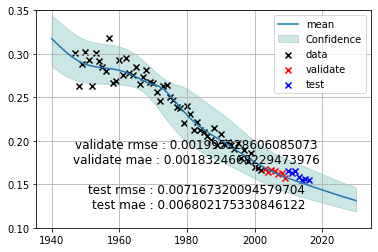

  4%|▍         | 57/1296 [04:50<4:05:50, 11.91s/it]

validate rmse : 0.001995328606085073 
 validate mae : 0.0018324668229473976 

    test rmse : 0.007167320094579704 
 test mae : 0.006802175330846122
(('sa', 1), ('sa', 2), ('sal', 2), ('sal', 2))


  4%|▍         | 58/1296 [05:18<5:44:53, 16.72s/it]

params:[-1.71860059e+00  3.44477009e+03]
validate rmse : 0.23070419131163908 
 validate mae : 0.22468102775118948 

    test rmse : 0.388617934802302 
 test mae : 0.3871836673559068
(('sa', 1), ('sa', 2), ('sal', 2), ('box_cox', 1))


  5%|▍         | 59/1296 [05:31<5:20:30, 15.55s/it]

params:[-1.05027253e-01  2.06663324e+02]
validate rmse : 0.006077184573954506 
 validate mae : 0.005819080786125914 

    test rmse : 0.002379066753023667 
 test mae : 0.0020119075291187482
(('sa', 1), ('sa', 2), ('sal', 2), ('box_cox', 2))


  5%|▍         | 60/1296 [05:48<5:32:34, 16.14s/it]

params:[-1.05632781e-01  2.06663452e+02]
validate rmse : 0.004698984577231856 
 validate mae : 0.004348716104093224 

    test rmse : 0.002697171720284557 
 test mae : 0.0019478291672719028
(('sa', 1), ('sa', 2), ('box_cox', 1), ('sa', 1))


  5%|▍         | 61/1296 [05:49<3:56:08, 11.47s/it]

params:[-8.08698942e-02  1.58934694e+02]
validate rmse : 0.007277092926528303 
 validate mae : 0.007063048397337873 

    test rmse : 0.0036126918477974355 
 test mae : 0.00312610239382364
(('sa', 1), ('sa', 2), ('box_cox', 1), ('sa', 2))


  5%|▍         | 62/1296 [05:50<2:49:06,  8.22s/it]

params:[-8.08699111e-02  1.58934728e+02]
validate rmse : 0.007277076282559407 
 validate mae : 0.007063031246211425 

    test rmse : 0.0036126728131116548 
 test mae : 0.003126084002943484
(('sa', 1), ('sa', 2), ('box_cox', 1), ('sal', 1))


  5%|▍         | 63/1296 [05:53<2:18:36,  6.74s/it]

params:[-1.08804944e-01  2.14856276e+02]
validate rmse : 0.002171884885881428 
 validate mae : 0.001931509525024843 

    test rmse : 0.008403401897260361 
 test mae : 0.008135977680296511
(('sa', 1), ('sa', 2), ('box_cox', 1), ('sal', 2))
params:[-5.67965568e+07  1.11529123e+11]


  5%|▍         | 64/1296 [06:12<3:33:04, 10.38s/it]

validate rmse : 0.016119713843304136 
 validate mae : 0.01586878263519531 

    test rmse : 0.018879682379657734 
 test mae : 0.018445394631841677
(('sa', 1), ('sa', 2), ('box_cox', 1), ('box_cox', 1))


  5%|▌         | 65/1296 [06:12<2:31:55,  7.40s/it]

params:[-8.76725120e-02  1.70806623e+02]
validate rmse : 0.0051375580103731975 
 validate mae : 0.004818918810114271 

    test rmse : 0.002466946516508134 
 test mae : 0.001817689509836807
(('sa', 1), ('sa', 2), ('box_cox', 1), ('box_cox', 2))


  5%|▌         | 66/1296 [06:13<1:49:46,  5.35s/it]

params:[-8.12040036e-02  1.56960833e+02]
validate rmse : 0.003975766623065167 
 validate mae : 0.0035415940585330286 

    test rmse : 0.003311311173950796 
 test mae : 0.002648876656909311
(('sa', 1), ('sa', 2), ('box_cox', 2), ('sa', 1))


  5%|▌         | 67/1296 [06:13<1:20:30,  3.93s/it]

params:[-7.26524643e-02  1.41954625e+02]
validate rmse : 0.006108106066335351 
 validate mae : 0.005851250997430244 

    test rmse : 0.0028996769603981485 
 test mae : 0.0026134668554546364
(('sa', 1), ('sa', 2), ('box_cox', 2), ('sa', 2))


  5%|▌         | 68/1296 [06:14<1:00:24,  2.95s/it]

params:[-7.26523491e-02  1.41954400e+02]
validate rmse : 0.006108177272746163 
 validate mae : 0.00585132533355986 

    test rmse : 0.0028997318386838914 
 test mae : 0.002613516317574584
(('sa', 1), ('sa', 2), ('box_cox', 2), ('sal', 1))


  5%|▌         | 69/1296 [06:15<48:51,  2.39s/it]  

params:[-1.01176619e-01  1.99871083e+02]
validate rmse : 0.006596910534111432 
 validate mae : 0.006359856432173667 

    test rmse : 0.0028558010049912624 
 test mae : 0.002567230758928634
(('sa', 1), ('sa', 2), ('box_cox', 2), ('sal', 2))


  5%|▌         | 70/1296 [06:28<1:52:47,  5.52s/it]

params:[-1.10949663e-01  2.19050423e+02]
validate rmse : 0.0022037648854888394 
 validate mae : 0.0018959817510284368 

    test rmse : 0.00980261200982877 
 test mae : 0.009621324357797239
(('sa', 1), ('sa', 2), ('box_cox', 2), ('box_cox', 1))


  5%|▌         | 71/1296 [06:29<1:23:04,  4.07s/it]

params:[-7.94788782e-02  1.53602622e+02]
validate rmse : 0.005172074622657435 
 validate mae : 0.004863690159867619 

    test rmse : 0.0024459718998273115 
 test mae : 0.0020053499342168363
(('sa', 1), ('sa', 2), ('box_cox', 2), ('box_cox', 2))


  6%|▌         | 72/1296 [06:29<1:02:07,  3.05s/it]

params:[-6.99778106e-02  1.33816254e+02]
validate rmse : 0.004090159064236768 
 validate mae : 0.0036847025217665824 

    test rmse : 0.002959567299547357 
 test mae : 0.0022291414886171845
(('sa', 1), ('sal', 1), ('sa', 1), ('sa', 1))


  6%|▌         | 73/1296 [06:31<56:01,  2.75s/it]  

params:[-1.08295386e-01  2.13859888e+02]
validate rmse : 0.004086297748844251 
 validate mae : 0.003558973027919204 

    test rmse : 0.015406399747029694 
 test mae : 0.015285158918773026
(('sa', 1), ('sal', 1), ('sa', 1), ('sa', 2))


  6%|▌         | 74/1296 [06:34<52:31,  2.58s/it]

params:[-1.08322167e-01  2.13920221e+02]
validate rmse : 0.004034220374852007 
 validate mae : 0.003520465022279873 

    test rmse : 0.015260373319405506 
 test mae : 0.015139025170693115
(('sa', 1), ('sal', 1), ('sa', 1), ('sal', 1))


  6%|▌         | 75/1296 [06:36<49:25,  2.43s/it]

params:[-1.06275257e-01  2.09717895e+02]
validate rmse : 0.0040066922085740895 
 validate mae : 0.0034938047618609763 

    test rmse : 0.015191007363197536 
 test mae : 0.01506851239237816
(('sa', 1), ('sal', 1), ('sa', 1), ('sal', 2))


  6%|▌         | 76/1296 [06:40<1:00:06,  2.96s/it]

params:[-1.06989754e-01  2.11139234e+02]
validate rmse : 0.004164917021691339 
 validate mae : 0.003589139786228601 

    test rmse : 0.015306887172672826 
 test mae : 0.015186329947120939
(('sa', 1), ('sal', 1), ('sa', 1), ('box_cox', 1))


  6%|▌         | 77/1296 [06:41<51:32,  2.54s/it]  

params:[-1.06092801e-01  2.08622183e+02]
validate rmse : 0.0021406455741305435 
 validate mae : 0.0017754289718557778 

    test rmse : 0.008476564217392943 
 test mae : 0.008254978606509823
(('sa', 1), ('sal', 1), ('sa', 1), ('box_cox', 2))


  6%|▌         | 78/1296 [06:43<47:06,  2.32s/it]

params:[-1.09439266e-01  2.14100347e+02]
validate rmse : 0.002639191511701528 
 validate mae : 0.002260334600198949 

    test rmse : 0.012846593561956705 
 test mae : 0.012692762642803859
(('sa', 1), ('sal', 1), ('sa', 2), ('sa', 1))


  6%|▌         | 79/1296 [06:46<47:56,  2.36s/it]

params:[-1.08293031e-01  2.13853929e+02]
validate rmse : 0.004099450642314732 
 validate mae : 0.0035687934878184746 

    test rmse : 0.01544515087918637 
 test mae : 0.015323914548211906
(('sa', 1), ('sal', 1), ('sa', 2), ('sa', 2))


  6%|▌         | 80/1296 [06:49<55:11,  2.72s/it]

params:[-1.08335854e-01  2.13947708e+02]
validate rmse : 0.004034418703542269 
 validate mae : 0.0035204714131210186 

    test rmse : 0.015257893461371182 
 test mae : 0.0151365711836621
(('sa', 1), ('sal', 1), ('sa', 2), ('sal', 1))


  6%|▋         | 81/1296 [06:59<1:36:16,  4.75s/it]

params:[-1.06188796e-01  2.09548421e+02]
validate rmse : 0.003917385754785904 
 validate mae : 0.003427324305996904 

    test rmse : 0.014948165287108638 
 test mae : 0.014825214545350482
(('sa', 1), ('sal', 1), ('sa', 2), ('sal', 2))


  6%|▋         | 82/1296 [07:09<2:07:14,  6.29s/it]

params:[-1.10567504e-01  2.18317991e+02]
validate rmse : 0.002864197418260668 
 validate mae : 0.0024826140330865476 

    test rmse : 0.014914988343095303 
 test mae : 0.014720353821258822
(('sa', 1), ('sal', 1), ('sa', 2), ('box_cox', 1))


  6%|▋         | 83/1296 [07:13<1:53:34,  5.62s/it]

params:[-1.06137299e-01  2.08714657e+02]
validate rmse : 0.002138313277755707 
 validate mae : 0.0017779999828421156 

    test rmse : 0.008480170916333563 
 test mae : 0.008258307366122116
(('sa', 1), ('sal', 1), ('sa', 2), ('box_cox', 2))


  6%|▋         | 84/1296 [07:16<1:38:21,  4.87s/it]

params:[-1.08761039e-01  2.12778982e+02]
validate rmse : 0.002567773593443677 
 validate mae : 0.0019051258817522779 

    test rmse : 0.011765857481353151 
 test mae : 0.011604191845879122
(('sa', 1), ('sal', 1), ('sal', 1), ('sa', 1))


  7%|▋         | 85/1296 [07:19<1:25:06,  4.22s/it]

params:[-1.05744280e-01  2.08675731e+02]
validate rmse : 0.0038577148376840653 
 validate mae : 0.0033817054742432723 

    test rmse : 0.014772494798312785 
 test mae : 0.014649193293974553
(('sa', 1), ('sal', 1), ('sal', 1), ('sa', 2))


  7%|▋         | 86/1296 [07:21<1:15:22,  3.74s/it]

params:[-1.05908761e-01  2.08997794e+02]
validate rmse : 0.004006836463917392 
 validate mae : 0.0034932810324446806 

    test rmse : 0.015183919755402984 
 test mae : 0.015061451987151694
(('sa', 1), ('sal', 1), ('sal', 1), ('sal', 1))


  7%|▋         | 87/1296 [07:24<1:08:25,  3.40s/it]

params:[-1.08065584e-01  2.13252944e+02]
validate rmse : 0.005169989576404106 
 validate mae : 0.0043362779122667495 

    test rmse : 0.017978327719990684 
 test mae : 0.017855443281918643
(('sa', 1), ('sal', 1), ('sal', 1), ('sal', 2))


  7%|▋         | 88/1296 [07:31<1:32:42,  4.61s/it]

params:[-1.09265173e-01  2.15695670e+02]
validate rmse : 0.007379378121755112 
 validate mae : 0.006103794890696524 

    test rmse : 0.02955186536250437 
 test mae : 0.029063840011095857
(('sa', 1), ('sal', 1), ('sal', 1), ('box_cox', 1))


  7%|▋         | 89/1296 [07:34<1:24:24,  4.20s/it]

params:[-1.04762718e-01  2.05789874e+02]
validate rmse : 0.002495765306430265 
 validate mae : 0.002219924394032291 

    test rmse : 0.01108902038094762 
 test mae : 0.010932610138992462
(('sa', 1), ('sal', 1), ('sal', 1), ('box_cox', 2))


  7%|▋         | 90/1296 [07:37<1:15:11,  3.74s/it]

params:[-1.04792478e-01  2.04774144e+02]
validate rmse : 0.002824916764676284 
 validate mae : 0.002539593528309641 

    test rmse : 0.013638011504032975 
 test mae : 0.013487059168723873
(('sa', 1), ('sal', 1), ('sal', 2), ('sa', 1))
params:[-1.06999888e-01  2.11572834e+02]


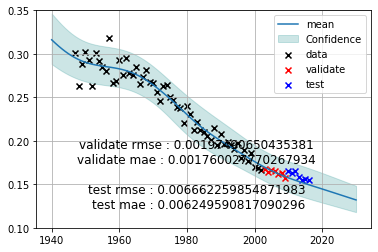

  7%|▋         | 91/1296 [07:47<1:49:31,  5.45s/it]

validate rmse : 0.00197490650435381 
 validate mae : 0.001760027770267934 

    test rmse : 0.006662259854871983 
 test mae : 0.006249590817090296
(('sa', 1), ('sal', 1), ('sal', 2), ('sa', 2))


  7%|▋         | 92/1296 [07:57<2:22:14,  7.09s/it]

params:[-1.09852892e-01  2.16670002e+02]
validate rmse : 0.005776054943109983 
 validate mae : 0.004879090292743582 

    test rmse : 0.01889254465704554 
 test mae : 0.018768287239294523
(('sa', 1), ('sal', 1), ('sal', 2), ('sal', 1))


  7%|▋         | 93/1296 [08:21<4:01:26, 12.04s/it]

params:[-1.12184749e-01  2.21570418e+02]
validate rmse : 0.0028283258501884097 
 validate mae : 0.002540849796400957 

    test rmse : 0.012244347004645802 
 test mae : 0.012101082739048367
(('sa', 1), ('sal', 1), ('sal', 2), ('sal', 2))


  7%|▋         | 94/1296 [08:44<5:06:49, 15.32s/it]

params:[-1.10947049e-01  2.19033007e+02]
validate rmse : 0.008733992076354858 
 validate mae : 0.007291183516743178 

    test rmse : 0.03321399128951099 
 test mae : 0.03263974138864064
(('sa', 1), ('sal', 1), ('sal', 2), ('box_cox', 1))


  7%|▋         | 95/1296 [08:56<4:47:07, 14.34s/it]

params:[ 2.81678057e-02 -5.24872554e+01]
validate rmse : 0.061057694039805335 
 validate mae : 0.060100715186458466 

    test rmse : 0.0766724161130564 
 test mae : 0.07648183852218908
(('sa', 1), ('sal', 1), ('sal', 2), ('box_cox', 2))
params:[-1.12460023e-01  2.20156798e+02]


  7%|▋         | 96/1296 [09:12<4:56:35, 14.83s/it]

validate rmse : 0.0025311996178376214 
 validate mae : 0.0020709583697186085 

    test rmse : 0.012252687703286412 
 test mae : 0.012096271049030802
(('sa', 1), ('sal', 1), ('box_cox', 1), ('sa', 1))


  7%|▋         | 97/1296 [09:15<3:44:03, 11.21s/it]

params:[-9.65173914e-02  1.90079744e+02]
validate rmse : 0.0026763393524531823 
 validate mae : 0.001937677450476837 

    test rmse : 0.010655691098110178 
 test mae : 0.01048497406040486
(('sa', 1), ('sal', 1), ('box_cox', 1), ('sa', 2))


  8%|▊         | 98/1296 [09:19<3:02:47,  9.16s/it]

params:[-9.61329691e-02  1.89293556e+02]
validate rmse : 0.0026579923212730013 
 validate mae : 0.0018978194045448332 

    test rmse : 0.010913318184243712 
 test mae : 0.010744612281079119
(('sa', 1), ('sal', 1), ('box_cox', 1), ('sal', 1))


  8%|▊         | 99/1296 [09:24<2:39:20,  7.99s/it]

params:[-1.13542091e-01  2.24133586e+02]
validate rmse : 0.007932697345296938 
 validate mae : 0.006900132772104919 

    test rmse : 0.025110506460276287 
 test mae : 0.024924815786179975
(('sa', 1), ('sal', 1), ('box_cox', 1), ('sal', 2))
params:[-1. -1.]


  8%|▊         | 100/1296 [09:42<3:34:14, 10.75s/it]

validate rmse : 0.09688365794898099 
 validate mae : 0.09682893979393625 

    test rmse : 0.10116944271132561 
 test mae : 0.10107278187880676
(('sa', 1), ('sal', 1), ('box_cox', 1), ('box_cox', 1))


  8%|▊         | 101/1296 [09:44<2:45:01,  8.29s/it]

params:[-1.08625586e-01  2.12416883e+02]
validate rmse : 0.004929920798492651 
 validate mae : 0.004139029976331916 

    test rmse : 0.01735380625437188 
 test mae : 0.017230404334365707
(('sa', 1), ('sal', 1), ('box_cox', 1), ('box_cox', 2))


  8%|▊         | 102/1296 [09:48<2:20:52,  7.08s/it]

params:[-1.01410666e-01  1.97073293e+02]
validate rmse : 0.0082543926584602 
 validate mae : 0.007397357247023728 

    test rmse : 0.02451411279867856 
 test mae : 0.024354481402453217
(('sa', 1), ('sal', 1), ('box_cox', 2), ('sa', 1))


  8%|▊         | 103/1296 [09:53<2:06:02,  6.34s/it]

params:[-8.98810621e-02  1.76287222e+02]
validate rmse : 0.004773571699076108 
 validate mae : 0.004021313170858258 

    test rmse : 0.01744758530535625 
 test mae : 0.017319010311848942
(('sa', 1), ('sal', 1), ('box_cox', 2), ('sa', 2))


  8%|▊         | 104/1296 [09:56<1:43:22,  5.20s/it]

params:[-8.97179323e-02  1.75929302e+02]
validate rmse : 0.005250385189539786 
 validate mae : 0.0044180941576254995 

    test rmse : 0.018351191948742785 
 test mae : 0.01822213432438829
(('sa', 1), ('sal', 1), ('box_cox', 2), ('sal', 1))
params:[-1.13739389e-01  2.24549662e+02]


  8%|▊         | 105/1296 [10:02<1:49:13,  5.50s/it]

validate rmse : 0.00617359181310388 
 validate mae : 0.005235711285055582 

    test rmse : 0.02025476160591993 
 test mae : 0.02011877636462989
(('sa', 1), ('sal', 1), ('box_cox', 2), ('sal', 2))
params:[-1. -1.]


  8%|▊         | 106/1296 [10:20<3:05:52,  9.37s/it]

validate rmse : 0.09192092367177139 
 validate mae : 0.09186325286546253 

    test rmse : 0.09620835299932258 
 test mae : 0.09610670722384487
(('sa', 1), ('sal', 1), ('box_cox', 2), ('box_cox', 1))


  8%|▊         | 107/1296 [10:22<2:20:11,  7.07s/it]

params:[-1.02273428e-01  1.98751161e+02]
validate rmse : 0.008189205937045786 
 validate mae : 0.007388318845645114 

    test rmse : 0.023920485813170814 
 test mae : 0.02377177780415874
(('sa', 1), ('sal', 1), ('box_cox', 2), ('box_cox', 2))


  8%|▊         | 108/1296 [10:25<1:57:17,  5.92s/it]

params:[-8.80061765e-02  1.69543884e+02]
validate rmse : 0.012226557985470092 
 validate mae : 0.011511623460801288 

    test rmse : 0.03059825453985088 
 test mae : 0.030422766094025062
(('sa', 1), ('sal', 2), ('sa', 1), ('sa', 1))


  8%|▊         | 109/1296 [10:28<1:41:21,  5.12s/it]

params:[-1.12297224e-01  2.21793064e+02]
validate rmse : 0.0035913447499091463 
 validate mae : 0.00301562528220994 

    test rmse : 0.010676076163819496 
 test mae : 0.010457838682682987
(('sa', 1), ('sal', 2), ('sa', 1), ('sa', 2))


  8%|▊         | 110/1296 [10:42<2:34:25,  7.81s/it]

params:[-1.10683352e-01  2.18577192e+02]
validate rmse : 0.004094340467244221 
 validate mae : 0.003486861608826838 

    test rmse : 0.01432866934621259 
 test mae : 0.014208036370132598
(('sa', 1), ('sal', 2), ('sa', 1), ('sal', 1))


  9%|▊         | 111/1296 [10:49<2:24:48,  7.33s/it]

params:[-9.32362219e-02  1.84348092e+02]
validate rmse : 0.009982831287559077 
 validate mae : 0.009811797835710647 

    test rmse : 0.00775727277159561 
 test mae : 0.007184929008137065
(('sa', 1), ('sal', 2), ('sa', 1), ('sal', 2))
params:[-1.08406816e+06 -2.12548574e+09]


  9%|▊         | 112/1296 [11:12<3:58:07, 12.07s/it]

validate rmse : 0.020350454000798456 
 validate mae : 0.019014258809320877 

    test rmse : 0.04995186102458145 
 test mae : 0.04809029339325784
(('sa', 1), ('sal', 2), ('sa', 1), ('box_cox', 1))


  9%|▊         | 113/1296 [11:33<4:49:14, 14.67s/it]

params:[-1.05181926e-01  2.06827049e+02]
validate rmse : 0.005360018893498047 
 validate mae : 0.005060341780919996 

    test rmse : 0.0023868095325919624 
 test mae : 0.001832840866958634
(('sa', 1), ('sal', 2), ('sa', 1), ('box_cox', 2))
params:[-8.92169005e-02  1.74001174e+02]


  9%|▉         | 114/1296 [11:53<5:20:21, 16.26s/it]

validate rmse : 0.006050801924445544 
 validate mae : 0.00579167485109757 

    test rmse : 0.0027660855606052898 
 test mae : 0.0024865759162836115
(('sa', 1), ('sal', 2), ('sa', 2), ('sa', 1))
params:[-1.07262051e-01  2.11839902e+02]


  9%|▉         | 115/1296 [12:12<5:37:50, 17.16s/it]

validate rmse : 0.0034476939035906293 
 validate mae : 0.0029250298565067106 

    test rmse : 0.004313036857890386 
 test mae : 0.003733101077003333
(('sa', 1), ('sal', 2), ('sa', 2), ('sa', 2))


  9%|▉         | 116/1296 [12:21<4:50:10, 14.75s/it]

params:[-1.06931823e-01  2.11133665e+02]
validate rmse : 0.0032877028815250318 
 validate mae : 0.0027453052983419856 

    test rmse : 0.004295607420190073 
 test mae : 0.003691913068663316
(('sa', 1), ('sal', 2), ('sa', 2), ('sal', 1))


  9%|▉         | 117/1296 [12:27<3:59:51, 12.21s/it]

params:[-1.07009353e-01  2.11195500e+02]
validate rmse : 0.003842282734750035 
 validate mae : 0.0033395140437195436 

    test rmse : 0.014240153170618814 
 test mae : 0.014117270985469955
(('sa', 1), ('sal', 2), ('sa', 2), ('sal', 2))


  9%|▉         | 118/1296 [12:44<4:24:40, 13.48s/it]

params:[-1.07696655e-01  2.12326907e+02]
validate rmse : 0.007932358922705707 
 validate mae : 0.0071559174232385435 

    test rmse : 0.023064592689026046 
 test mae : 0.02292761479969013
(('sa', 1), ('sal', 2), ('sa', 2), ('box_cox', 1))


  9%|▉         | 119/1296 [12:56<4:20:35, 13.28s/it]

params:[-1.04410157e-01  2.05371242e+02]
validate rmse : 0.0058627772349144755 
 validate mae : 0.005597973943425689 

    test rmse : 0.00263965222918268 
 test mae : 0.0023495795268168107
(('sa', 1), ('sal', 2), ('sa', 2), ('box_cox', 2))


  9%|▉         | 120/1296 [13:01<3:27:17, 10.58s/it]

params:[-1.30768763e-01  2.56388168e+02]
validate rmse : 0.0065889318114059564 
 validate mae : 0.005868516926619359 

    test rmse : 0.01744005204477422 
 test mae : 0.017342058979599763
(('sa', 1), ('sal', 2), ('sal', 1), ('sa', 1))


  9%|▉         | 121/1296 [13:10<3:18:10, 10.12s/it]

params:[-1.07230432e-01  2.11752762e+02]
validate rmse : 0.003605182643091279 
 validate mae : 0.003193304538695933 

    test rmse : 0.014024779475573181 
 test mae : 0.013899676186975284
(('sa', 1), ('sal', 2), ('sal', 1), ('sa', 2))


  9%|▉         | 122/1296 [13:23<3:36:50, 11.08s/it]

params:[-1.07641108e-01  2.12641140e+02]
validate rmse : 0.0025185376725904325 
 validate mae : 0.0018846304252272009 

    test rmse : 0.003832017942123137 
 test mae : 0.0030899532565575
(('sa', 1), ('sal', 2), ('sal', 1), ('sal', 1))


  9%|▉         | 123/1296 [13:27<2:54:34,  8.93s/it]

params:[-1.01492548e-01  2.00211775e+02]
validate rmse : 0.004823408994937464 
 validate mae : 0.004000928149470494 

    test rmse : 0.013658033306251456 
 test mae : 0.01352726085896109
(('sa', 1), ('sal', 2), ('sal', 1), ('sal', 2))


 10%|▉         | 124/1296 [13:40<3:20:42, 10.28s/it]

params:[-5.61044734e-01  1.11940682e+03]
validate rmse : 0.1668440007989542 
 validate mae : 0.166776037275437 

    test rmse : 0.18152591402517643 
 test mae : 0.18151651854856304
(('sa', 1), ('sal', 2), ('sal', 1), ('box_cox', 1))
params:[-1.96876886e+01  3.86589969e+04]


 10%|▉         | 125/1296 [14:05<4:44:21, 14.57s/it]

validate rmse : 0.10657943756343298 
 validate mae : 0.10623558614113958 

    test rmse : 0.13748852766589648 
 test mae : 0.13737813487804545
(('sa', 1), ('sal', 2), ('sal', 1), ('box_cox', 2))


 10%|▉         | 126/1296 [14:08<3:38:16, 11.19s/it]

params:[1.64765998e-05 1.30510129e+00]
validate rmse : 0.10539041326922198 
 validate mae : 0.10533046604507575 

    test rmse : 0.11096919435429202 
 test mae : 0.11086603503343738
(('sa', 1), ('sal', 2), ('sal', 2), ('sa', 1))


 10%|▉         | 127/1296 [14:33<4:56:51, 15.24s/it]

params:[-1.08581670e-01  2.14375136e+02]
validate rmse : 0.002166638147781465 
 validate mae : 0.0019189978871778368 

    test rmse : 0.009030933737849939 
 test mae : 0.00881652412034588
(('sa', 1), ('sal', 2), ('sal', 2), ('sa', 2))


 10%|▉         | 128/1296 [15:00<6:05:31, 18.78s/it]

params:[-1.48034565e-01  2.91622983e+02]
validate rmse : 0.11979992638753753 
 validate mae : 0.11775657045852032 

    test rmse : 0.1623622178630924 
 test mae : 0.16222616550269903
(('sa', 1), ('sal', 2), ('sal', 2), ('sal', 1))


 10%|▉         | 129/1296 [15:14<5:38:30, 17.40s/it]

params:[-1.07241903e-01  2.11952580e+02]
validate rmse : 0.0021850541690369004 
 validate mae : 0.0017234951853178121 

    test rmse : 0.003300624213702947 
 test mae : 0.002656479512386008
(('sa', 1), ('sal', 2), ('sal', 2), ('sal', 2))


 10%|█         | 130/1296 [15:37<6:12:07, 19.15s/it]

params:[-1.14073616e-01  2.24998121e+02]
validate rmse : 0.011283128134008898 
 validate mae : 0.01033916861908001 

    test rmse : 0.02998268128052057 
 test mae : 0.029814737194950914
(('sa', 1), ('sal', 2), ('sal', 2), ('box_cox', 1))


 10%|█         | 131/1296 [15:46<5:12:45, 16.11s/it]

params:[-1.48996228e-02  3.37772058e+01]
validate rmse : 0.2779985194049442 
 validate mae : 0.25862731651738186 

    test rmse : 0.17748165192348872 
 test mae : 0.1774705496441647
(('sa', 1), ('sal', 2), ('sal', 2), ('box_cox', 2))


 10%|█         | 132/1296 [16:07<5:39:04, 17.48s/it]

params:[-1.18388695e-01  2.31877491e+02]
validate rmse : 0.002163604468537447 
 validate mae : 0.001919705915971717 

    test rmse : 0.008281328687712239 
 test mae : 0.008011401922980511
(('sa', 1), ('sal', 2), ('box_cox', 1), ('sa', 1))


 10%|█         | 133/1296 [16:14<4:38:49, 14.38s/it]

params:[-1.02825725e-01  2.02741895e+02]
validate rmse : 0.0026941566265838387 
 validate mae : 0.0021628604624138537 

    test rmse : 0.005208853360214294 
 test mae : 0.004736763029891257
(('sa', 1), ('sal', 2), ('box_cox', 1), ('sa', 2))
params:[-2.39331863e+04  4.80611206e+07]


 10%|█         | 134/1296 [16:24<4:09:13, 12.87s/it]

validate rmse : 0.04227721518411359 
 validate mae : 0.032359133006937865 

    test rmse : 0.07892943333308831 
 test mae : 0.07880625342377147
(('sa', 1), ('sal', 2), ('box_cox', 1), ('sal', 1))


 10%|█         | 135/1296 [16:29<3:27:34, 10.73s/it]

params:[-1. -1.]
validate rmse : 0.4580429379405005 
 validate mae : 0.4485435417034621 

    test rmse : 0.3398753504587183 
 test mae : 0.33941234629202593
(('sa', 1), ('sal', 2), ('box_cox', 1), ('sal', 2))
params:[471.17916412 100.42540518]


 10%|█         | 136/1296 [16:45<3:54:27, 12.13s/it]

validate rmse : 0.0869448292546536 
 validate mae : 0.08688385147485014 

    test rmse : 0.09123494966644365 
 test mae : 0.0911277510266731
(('sa', 1), ('sal', 2), ('box_cox', 1), ('box_cox', 1))


 11%|█         | 137/1296 [16:55<3:43:48, 11.59s/it]

params:[-1.51130372e-02  3.24383335e+01]
validate rmse : 0.2871820201554897 
 validate mae : 0.28655997627003343 

    test rmse : 0.2437980930251266 
 test mae : 0.24374605950782763
(('sa', 1), ('sal', 2), ('box_cox', 1), ('box_cox', 2))
params:[-1.04092121e-01  2.02558505e+02]


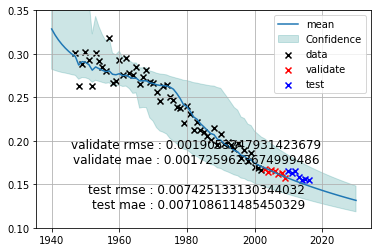

 11%|█         | 138/1296 [17:08<3:51:26, 11.99s/it]

validate rmse : 0.0019053247931423679 
 validate mae : 0.0017259623674999486 

    test rmse : 0.007425133130344032 
 test mae : 0.007108611485450329
(('sa', 1), ('sal', 2), ('box_cox', 2), ('sa', 1))
params:[-9.03609814e-02  1.77304954e+02]


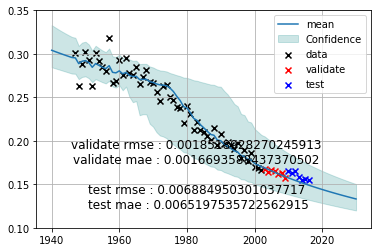

 11%|█         | 139/1296 [17:37<5:28:52, 17.06s/it]

validate rmse : 0.0018518928270245913 
 validate mae : 0.0016693588437370502 

    test rmse : 0.006884950301037717 
 test mae : 0.0065197535722562915
(('sa', 1), ('sal', 2), ('box_cox', 2), ('sa', 2))


 11%|█         | 140/1296 [17:56<5:38:02, 17.55s/it]

params:[-8.78366603e-02  1.73532559e+02]
validate rmse : 0.014895591241708231 
 validate mae : 0.01473665343148912 

    test rmse : 0.023055252596353423 
 test mae : 0.022966084726368352
(('sa', 1), ('sal', 2), ('box_cox', 2), ('sal', 1))
params:[-1. -1.]


 11%|█         | 141/1296 [18:03<4:41:37, 14.63s/it]

validate rmse : 0.13339007960335655 
 validate mae : 0.12755594277578802 

    test rmse : 0.9060738094247145 
 test mae : 0.7659100859255766
(('sa', 1), ('sal', 2), ('box_cox', 2), ('sal', 2))


 11%|█         | 142/1296 [18:32<6:00:02, 18.72s/it]

params:[-1.09051429e-01  2.15563941e+02]
validate rmse : 0.002876489746508131 
 validate mae : 0.0022310883703484823 

    test rmse : 0.003027041304901183 
 test mae : 0.0022452778684081526
(('sa', 1), ('sal', 2), ('box_cox', 2), ('box_cox', 1))


 11%|█         | 143/1296 [18:39<4:51:34, 15.17s/it]

params:[ 1.23897599e-02 -2.15847328e+01]
validate rmse : 0.0749641474428307 
 validate mae : 0.07417442781954285 

    test rmse : 0.09927330562903411 
 test mae : 0.09901461675718111
(('sa', 1), ('sal', 2), ('box_cox', 2), ('box_cox', 2))


 11%|█         | 144/1296 [18:52<4:39:18, 14.55s/it]

params:[-8.67477123e-02  1.67129379e+02]
validate rmse : 0.005947500732552113 
 validate mae : 0.005516601823556911 

    test rmse : 0.014750363850894725 
 test mae : 0.014626532425105313
(('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))


 11%|█         | 145/1296 [18:52<3:17:39, 10.30s/it]

params:[-8.08700292e-02  1.58934962e+02]
validate rmse : 0.007277030328465304 
 validate mae : 0.007062983885590036 

    test rmse : 0.003612625838295054 
 test mae : 0.0031260382016867127
(('sa', 1), ('box_cox', 1), ('sa', 1), ('sa', 2))


 11%|█▏        | 146/1296 [18:53<2:21:44,  7.39s/it]

params:[-8.08696102e-02  1.58934136e+02]
validate rmse : 0.007277035198617365 
 validate mae : 0.0070629889166958825 

    test rmse : 0.003612625402492469 
 test mae : 0.0031260382554531125
(('sa', 1), ('box_cox', 1), ('sa', 1), ('sal', 1))


 11%|█▏        | 147/1296 [18:56<1:58:45,  6.20s/it]

params:[-1.08795800e-01  2.14838023e+02]
validate rmse : 0.002171415763856004 
 validate mae : 0.0019312877794423597 

    test rmse : 0.00840105800230848 
 test mae : 0.008133497757518938
(('sa', 1), ('box_cox', 1), ('sa', 1), ('sal', 2))


 11%|█▏        | 148/1296 [19:14<3:03:02,  9.57s/it]

params:[-1.08488204e-01  2.14230478e+02]
validate rmse : 0.0020515051186670613 
 validate mae : 0.001721797252250317 

    test rmse : 0.004396384573302448 
 test mae : 0.0035843066553466673
(('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))


 11%|█▏        | 149/1296 [19:14<2:10:37,  6.83s/it]

params:[-8.39221677e-02  1.63797890e+02]
validate rmse : 0.004264882294759101 
 validate mae : 0.0038711368652980566 

    test rmse : 0.0029266898799077882 
 test mae : 0.0022005911597459643
(('sa', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 2))


 12%|█▏        | 150/1296 [19:14<1:33:51,  4.91s/it]

params:[-8.04437848e-02  1.55937596e+02]
validate rmse : 0.004491486907205718 
 validate mae : 0.004123605232511969 

    test rmse : 0.0027265216134501127 
 test mae : 0.0019442326697386356
(('sa', 1), ('box_cox', 1), ('sa', 2), ('sa', 1))


 12%|█▏        | 151/1296 [19:15<1:08:26,  3.59s/it]

params:[-8.08698488e-02  1.58934607e+02]
validate rmse : 0.0072770676329401785 
 validate mae : 0.0070630223286011285 

    test rmse : 0.0036126692797074163 
 test mae : 0.0031260801276334588
(('sa', 1), ('box_cox', 1), ('sa', 2), ('sa', 2))


 12%|█▏        | 152/1296 [19:16<51:27,  2.70s/it]  

params:[-8.08684400e-02  1.58931829e+02]
validate rmse : 0.007277706903212374 
 validate mae : 0.007063681080376126 

    test rmse : 0.003613407720341312 
 test mae : 0.0031267930477634604
(('sa', 1), ('box_cox', 1), ('sa', 2), ('sal', 1))


 12%|█▏        | 153/1296 [19:19<55:27,  2.91s/it]

params:[-1.08794338e-01  2.14835031e+02]
validate rmse : 0.0021716841576919855 
 validate mae : 0.0019314132132166872 

    test rmse : 0.008402479732353633 
 test mae : 0.008135004854419706
(('sa', 1), ('box_cox', 1), ('sa', 2), ('sal', 2))
params:[-7.65970202e+04  1.50243264e+08]


 12%|█▏        | 154/1296 [19:25<1:12:19,  3.80s/it]

validate rmse : 0.016666154872628902 
 validate mae : 0.01656642826539387 

    test rmse : 0.013762023096130567 
 test mae : 0.013487095656367576
(('sa', 1), ('box_cox', 1), ('sa', 2), ('box_cox', 1))


 12%|█▏        | 155/1296 [19:25<53:28,  2.81s/it]  

params:[-8.39253174e-02  1.63804103e+02]
validate rmse : 0.00426328688814734 
 validate mae : 0.003869354654411774 

    test rmse : 0.0029281233180994196 
 test mae : 0.002202403944905352
(('sa', 1), ('box_cox', 1), ('sa', 2), ('box_cox', 2))


 12%|█▏        | 156/1296 [19:26<40:05,  2.11s/it]

params:[-8.04437731e-02  1.55937572e+02]
validate rmse : 0.004491466285209446 
 validate mae : 0.0041235826345938685 

    test rmse : 0.002726534532766555 
 test mae : 0.0019442440442821332
(('sa', 1), ('box_cox', 1), ('sal', 1), ('sa', 1))


 12%|█▏        | 157/1296 [19:29<44:47,  2.36s/it]

params:[-1.08940991e-01  2.15150152e+02]
validate rmse : 0.0022271637014170363 
 validate mae : 0.0019563179166542178 

    test rmse : 0.008646964187366372 
 test mae : 0.00839246399793633
(('sa', 1), ('box_cox', 1), ('sal', 1), ('sa', 2))


 12%|█▏        | 158/1296 [19:32<48:34,  2.56s/it]

params:[-1.08942974e-01  2.15154585e+02]
validate rmse : 0.002225745921559661 
 validate mae : 0.0019557012103334176 

    test rmse : 0.008640936928345088 
 test mae : 0.008386129866920574
(('sa', 1), ('box_cox', 1), ('sal', 1), ('sal', 1))


 12%|█▏        | 159/1296 [19:35<54:05,  2.85s/it]

params:[-1.07230648e-01  2.11668594e+02]
validate rmse : 0.00212273622965375 
 validate mae : 0.0019012580797092243 

    test rmse : 0.008338720767557466 
 test mae : 0.008074828216617983
(('sa', 1), ('box_cox', 1), ('sal', 1), ('sal', 2))


 12%|█▏        | 160/1296 [19:37<45:57,  2.43s/it]

params:[-2.93701312e-02  5.92705173e+01]
validate rmse : 0.044645277417907345 
 validate mae : 0.04354263408943315 

    test rmse : 0.08904151340184223 
 test mae : 0.08823291377910138
(('sa', 1), ('box_cox', 1), ('sal', 1), ('box_cox', 1))


 12%|█▏        | 161/1296 [19:40<52:23,  2.77s/it]

params:[-1.06730883e-01  2.09879350e+02]
validate rmse : 0.0030419494927639177 
 validate mae : 0.002447215462730797 

    test rmse : 0.003728806826167688 
 test mae : 0.0030204004657964595
(('sa', 1), ('box_cox', 1), ('sal', 1), ('box_cox', 2))


 12%|█▎        | 162/1296 [19:43<54:26,  2.88s/it]

params:[-1.08619974e-01  2.12499365e+02]
validate rmse : 0.0027111287536704764 
 validate mae : 0.002183120594758285 

    test rmse : 0.00608544545755103 
 test mae : 0.005734435610157367
(('sa', 1), ('box_cox', 1), ('sal', 2), ('sa', 1))


 13%|█▎        | 163/1296 [19:45<49:21,  2.61s/it]

params:[-8.78234700e-02  1.72740275e+02]
validate rmse : 0.0052544454982814265 
 validate mae : 0.004951991710984808 

    test rmse : 0.0024993757948648613 
 test mae : 0.002126763713605238
(('sa', 1), ('box_cox', 1), ('sal', 2), ('sa', 2))


 13%|█▎        | 164/1296 [19:53<1:18:30,  4.16s/it]

params:[-1.07931986e-01  2.13265211e+02]
validate rmse : 0.004023301096697097 
 validate mae : 0.0036165166139280613 

    test rmse : 0.002879376272510178 
 test mae : 0.002077427234966678
(('sa', 1), ('box_cox', 1), ('sal', 2), ('sal', 1))
params:[-1.0927356e-01  2.1584693e+02]


 13%|█▎        | 165/1296 [20:14<2:54:43,  9.27s/it]

validate rmse : 0.003226980304507048 
 validate mae : 0.0026896945709705927 

    test rmse : 0.0037885066083447752 
 test mae : 0.003081696311770204
(('sa', 1), ('box_cox', 1), ('sal', 2), ('sal', 2))


 13%|█▎        | 166/1296 [20:25<3:04:46,  9.81s/it]

params:[-1.08961043e-01  2.15189343e+02]
validate rmse : 0.0030730238050608177 
 validate mae : 0.0025120429832625824 

    test rmse : 0.003827889656710811 
 test mae : 0.0031087427659011063
(('sa', 1), ('box_cox', 1), ('sal', 2), ('box_cox', 1))


 13%|█▎        | 167/1296 [20:27<2:20:42,  7.48s/it]

params:[-2.69574084e-03  8.41862506e+00]
validate rmse : 0.09902912591283054 
 validate mae : 0.0602894230733343 

    test rmse : 0.02968631866753674 
 test mae : 0.02941215903817181
(('sa', 1), ('box_cox', 1), ('sal', 2), ('box_cox', 2))
params:[-1.06933791e-01  2.09282696e+02]


 13%|█▎        | 168/1296 [20:38<2:36:08,  8.31s/it]

validate rmse : 0.004115714350931827 
 validate mae : 0.003723241623432718 

    test rmse : 0.002669764066378532 
 test mae : 0.0020711256361014402
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))


 13%|█▎        | 169/1296 [20:38<1:51:33,  5.94s/it]

params:[-7.56688464e-02  1.47922325e+02]
validate rmse : 0.004506532904176463 
 validate mae : 0.004141403665083869 

    test rmse : 0.002694646951908052 
 test mae : 0.0019139871139363582
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 2))


 13%|█▎        | 170/1296 [20:39<1:21:03,  4.32s/it]

params:[-7.56688569e-02  1.47922346e+02]
validate rmse : 0.0045065480253748845 
 validate mae : 0.004141420080256261 

    test rmse : 0.0026946401099723315 
 test mae : 0.001913980821326104
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sal', 1))


 13%|█▎        | 171/1296 [20:39<1:01:01,  3.25s/it]

params:[-1.05091923e-01  2.07572813e+02]
validate rmse : 0.00477455475464972 
 validate mae : 0.004422574217665252 

    test rmse : 0.0027558025582432467 
 test mae : 0.0020444868229603746
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('sal', 2))


 13%|█▎        | 172/1296 [20:52<1:55:13,  6.15s/it]

params:[-1.50582853e-02  2.51847061e+01]
validate rmse : 0.07798060783579773 
 validate mae : 0.07700156431718828 

    test rmse : 0.12314168166945312 
 test mae : 0.12276727078008264
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))


 13%|█▎        | 173/1296 [20:53<1:22:24,  4.40s/it]

params:[-8.18029965e-02  1.58101351e+02]
validate rmse : 0.0031538192108635003 
 validate mae : 0.0025742610841130165 

    test rmse : 0.004303188766914686 
 test mae : 0.003668029599393643
(('sa', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 2))


 13%|█▎        | 174/1296 [20:53<1:00:13,  3.22s/it]

params:[-7.13689862e-02  1.36483307e+02]
validate rmse : 0.0022431343808087443 
 validate mae : 0.001791518179425284 

    test rmse : 0.005895708401961009 
 test mae : 0.0054772105068800125
(('sa', 1), ('box_cox', 1), ('box_cox', 2), ('sa', 1))


 14%|█▎        | 175/1296 [20:54<44:49,  2.40s/it]  

params:[-6.88937085e-02  1.34247282e+02]
validate rmse : 0.005659697453916601 
 validate mae : 0.005379286084415347 

    test rmse : 0.002513502991700912 
 test mae : 0.002152481424665576
(('sa', 1), ('box_cox', 1), ('box_cox', 2), ('sa', 2))


 14%|█▎        | 176/1296 [20:54<34:06,  1.83s/it]

params:[-6.88938468e-02  1.34247547e+02]
validate rmse : 0.005659533230804819 
 validate mae : 0.005379112876234874 

    test rmse : 0.0025134557793471055 
 test mae : 0.002152381756715025
(('sa', 1), ('box_cox', 1), ('box_cox', 2), ('sal', 1))


 14%|█▎        | 177/1296 [20:55<28:02,  1.50s/it]

params:[-9.94200815e-02  1.96501510e+02]
validate rmse : 0.004401550643748667 
 validate mae : 0.003993938036048619 

    test rmse : 0.003382137931152749 
 test mae : 0.0030350466624162265
(('sa', 1), ('box_cox', 1), ('box_cox', 2), ('sal', 2))
params:[-1.08397857e+02  2.04081507e+05]


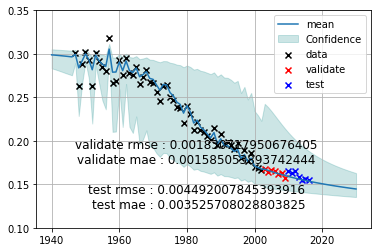

 14%|█▎        | 178/1296 [20:59<41:02,  2.20s/it]

validate rmse : 0.001830717950676405 
 validate mae : 0.001585053893742444 

    test rmse : 0.004492007845393916 
 test mae : 0.003525708028803825
(('sa', 1), ('box_cox', 1), ('box_cox', 2), ('box_cox', 1))


 14%|█▍        | 179/1296 [20:59<30:46,  1.65s/it]

params:[-7.04025252e-02  1.34589363e+02]
validate rmse : 0.0026127457759922514 
 validate mae : 0.0020760920615256868 

    test rmse : 0.005160793570923196 
 test mae : 0.0046640757075141525
(('sa', 1), ('box_cox', 1), ('box_cox', 2), ('box_cox', 2))


 14%|█▍        | 180/1296 [21:00<23:56,  1.29s/it]

params:[-5.75870838e-02  1.08412787e+02]
validate rmse : 0.0020547054945720153 
 validate mae : 0.001736199305157754 

    test rmse : 0.006481693711268326 
 test mae : 0.0061138392533997
(('sa', 1), ('box_cox', 2), ('sa', 1), ('sa', 1))


 14%|█▍        | 181/1296 [21:00<19:39,  1.06s/it]

params:[-7.26522410e-02  1.41954186e+02]
validate rmse : 0.006108236911608341 
 validate mae : 0.005851387601359095 

    test rmse : 0.002899772459539557 
 test mae : 0.0026135528837123883
(('sa', 1), ('box_cox', 2), ('sa', 1), ('sa', 2))


 14%|█▍        | 182/1296 [21:01<19:49,  1.07s/it]

params:[-7.26527018e-02  1.41955090e+02]
validate rmse : 0.006107907456556731 
 validate mae : 0.005851043642510355 

    test rmse : 0.0028995458810966938 
 test mae : 0.00261334888268703
(('sa', 1), ('box_cox', 2), ('sa', 1), ('sal', 1))


 14%|█▍        | 183/1296 [21:02<19:17,  1.04s/it]

params:[-1.01176169e-01  1.99869700e+02]
validate rmse : 0.006595428949474853 
 validate mae : 0.0063583166056628325 

    test rmse : 0.002854633942348749 
 test mae : 0.0025662339529869166
(('sa', 1), ('box_cox', 2), ('sa', 1), ('sal', 2))


 14%|█▍        | 184/1296 [21:03<18:25,  1.01it/s]

params:[-2.72595067e-02  5.64196758e+01]
validate rmse : 0.02688900922107809 
 validate mae : 0.026637071533056007 

    test rmse : 0.04183751998404678 
 test mae : 0.041781591149813245
(('sa', 1), ('box_cox', 2), ('sa', 1), ('box_cox', 1))


 14%|█▍        | 185/1296 [21:04<15:58,  1.16it/s]

params:[-7.28816486e-02  1.41426917e+02]
validate rmse : 0.006415245654250333 
 validate mae : 0.006171124545209096 

    test rmse : 0.0031315175101499226 
 test mae : 0.002804027344703443
(('sa', 1), ('box_cox', 2), ('sa', 1), ('box_cox', 2))


 14%|█▍        | 186/1296 [21:04<13:47,  1.34it/s]

params:[-7.26128246e-02  1.39875024e+02]
validate rmse : 0.006087676163257832 
 validate mae : 0.005829920561797827 

    test rmse : 0.0028855690004022765 
 test mae : 0.002600675157613958
(('sa', 1), ('box_cox', 2), ('sa', 2), ('sa', 1))


 14%|█▍        | 187/1296 [21:05<12:53,  1.43it/s]

params:[-7.26526625e-02  1.41955011e+02]
validate rmse : 0.006108033315597829 
 validate mae : 0.005851175054198037 

    test rmse : 0.002899611440888831 
 test mae : 0.0026134077215632856
(('sa', 1), ('box_cox', 2), ('sa', 2), ('sa', 2))


 15%|█▍        | 188/1296 [21:05<12:54,  1.43it/s]

params:[-7.26521309e-02  1.41953971e+02]
validate rmse : 0.006108319109727505 
 validate mae : 0.005851473417502945 

    test rmse : 0.0028998289378471443 
 test mae : 0.002613603726672615
(('sa', 1), ('box_cox', 2), ('sa', 2), ('sal', 1))


 15%|█▍        | 189/1296 [21:06<14:26,  1.28it/s]

params:[-1.01176676e-01  1.99870772e+02]
validate rmse : 0.006595956072175852 
 validate mae : 0.006358864524016595 

    test rmse : 0.00285505915856991 
 test mae : 0.0025665975116525774
(('sa', 1), ('box_cox', 2), ('sa', 2), ('sal', 2))


 15%|█▍        | 190/1296 [21:11<35:08,  1.91s/it]

params:[-1.11731675e-01  2.20612741e+02]
validate rmse : 0.0023042769085816666 
 validate mae : 0.001960309902475179 

    test rmse : 0.010015864520487174 
 test mae : 0.009835223548258942
(('sa', 1), ('box_cox', 2), ('sa', 2), ('box_cox', 1))


 15%|█▍        | 191/1296 [21:11<27:39,  1.50s/it]

params:[-7.28817212e-02  1.41427060e+02]
validate rmse : 0.006415175624310995 
 validate mae : 0.006171051775919157 

    test rmse : 0.00313145834414992 
 test mae : 0.0028039822635959133
(('sa', 1), ('box_cox', 2), ('sa', 2), ('box_cox', 2))


 15%|█▍        | 192/1296 [21:12<22:30,  1.22s/it]

params:[-7.26126409e-02  1.39874656e+02]
validate rmse : 0.006087700504126697 
 validate mae : 0.0058299459895851434 

    test rmse : 0.0028856002031297954 
 test mae : 0.0026007037372568925
(('sa', 1), ('box_cox', 2), ('sal', 1), ('sa', 1))


 15%|█▍        | 193/1296 [21:13<20:25,  1.11s/it]

params:[-9.96863387e-02  1.96962143e+02]
validate rmse : 0.006148291129214993 
 validate mae : 0.005891873105377405 

    test rmse : 0.002562884102203722 
 test mae : 0.002269195558506104
(('sa', 1), ('box_cox', 2), ('sal', 1), ('sa', 2))


 15%|█▍        | 194/1296 [21:14<18:54,  1.03s/it]

params:[-7.25625110e-02  1.41766549e+02]
validate rmse : 0.006066117174856415 
 validate mae : 0.005807417850686225 

    test rmse : 0.00286482571778658 
 test mae : 0.002581527646003965
(('sa', 1), ('box_cox', 2), ('sal', 1), ('sal', 1))


 15%|█▌        | 195/1296 [21:15<19:09,  1.04s/it]

params:[-1.10194790e-01  2.17577571e+02]
validate rmse : 0.0021662747237879186 
 validate mae : 0.0017479390714292315 

    test rmse : 0.008235919635831935 
 test mae : 0.008001885834932563
(('sa', 1), ('box_cox', 2), ('sal', 1), ('sal', 2))


 15%|█▌        | 196/1296 [21:21<47:30,  2.59s/it]

params:[-1.11066467e-01  2.19297324e+02]
validate rmse : 0.0025654544035329943 
 validate mae : 0.002220504615726613 

    test rmse : 0.011382577461872172 
 test mae : 0.011232147426866004
(('sa', 1), ('box_cox', 2), ('sal', 1), ('box_cox', 1))


 15%|█▌        | 197/1296 [21:22<38:07,  2.08s/it]

params:[-1.00289066e-01  1.97154699e+02]
validate rmse : 0.007177600029012098 
 validate mae : 0.00696118620867185 

    test rmse : 0.003499430959502312 
 test mae : 0.003038862890862435
(('sa', 1), ('box_cox', 2), ('sal', 1), ('box_cox', 2))


 15%|█▌        | 198/1296 [21:23<32:29,  1.78s/it]

params:[-1.00081423e-01  1.95696989e+02]
validate rmse : 0.006035244109810287 
 validate mae : 0.00577575194720661 

    test rmse : 0.0027134231354763996 
 test mae : 0.002433285267127288
(('sa', 1), ('box_cox', 2), ('sal', 2), ('sa', 1))


 15%|█▌        | 199/1296 [21:30<1:03:44,  3.49s/it]

params:[-1.11565558e-01  2.20252722e+02]
validate rmse : 0.0022352310799811674 
 validate mae : 0.0019162416259391785 

    test rmse : 0.010010213002499052 
 test mae : 0.009833978352635128
(('sa', 1), ('box_cox', 2), ('sal', 2), ('sa', 2))


 15%|█▌        | 200/1296 [21:42<1:48:41,  5.95s/it]

params:[-1.11633807e-01  2.20393554e+02]
validate rmse : 0.0023355588503185996 
 validate mae : 0.002004553595976899 

    test rmse : 0.010746267010162222 
 test mae : 0.010585665515628522
(('sa', 1), ('box_cox', 2), ('sal', 2), ('sal', 1))
params:[-1. -1.]


 16%|█▌        | 201/1296 [21:48<1:50:00,  6.03s/it]

validate rmse : 0.1332049933435198 
 validate mae : 0.13316520185091182 

    test rmse : 0.1374799507097686 
 test mae : 0.13740883676081816
(('sa', 1), ('box_cox', 2), ('sal', 2), ('sal', 2))


 16%|█▌        | 202/1296 [22:01<2:27:55,  8.11s/it]

params:[-1.11957537e-01  2.21074664e+02]
validate rmse : 0.0025042645372060877 
 validate mae : 0.002185376630022075 

    test rmse : 0.011345870052030721 
 test mae : 0.01119435944604717
(('sa', 1), ('box_cox', 2), ('sal', 2), ('box_cox', 1))


 16%|█▌        | 203/1296 [22:09<2:25:54,  8.01s/it]

params:[-1.48306848e-01  2.72508973e+02]
validate rmse : 0.010413392569618757 
 validate mae : 0.010116240396515212 

    test rmse : 0.020475070590935496 
 test mae : 0.020391041069389788
(('sa', 1), ('box_cox', 2), ('sal', 2), ('box_cox', 2))


 16%|█▌        | 204/1296 [22:16<2:22:55,  7.85s/it]

params:[-1.08840045e-01  2.12989030e+02]
validate rmse : 0.003250592364335623 
 validate mae : 0.002681780211559729 

    test rmse : 0.004780667922305731 
 test mae : 0.004289640780117275
(('sa', 1), ('box_cox', 2), ('box_cox', 1), ('sa', 1))


 16%|█▌        | 205/1296 [22:17<1:43:00,  5.66s/it]

params:[-6.66735332e-02  1.29817211e+02]
validate rmse : 0.006405298024414205 
 validate mae : 0.006160440778786108 

    test rmse : 0.0031882173129302556 
 test mae : 0.002849717523353846
(('sa', 1), ('box_cox', 2), ('box_cox', 1), ('sa', 2))


 16%|█▌        | 206/1296 [22:18<1:14:53,  4.12s/it]

params:[-6.66738223e-02  1.29817779e+02]
validate rmse : 0.006405065622988588 
 validate mae : 0.006160199378634732 

    test rmse : 0.0031880056764441904 
 test mae : 0.0028495590647880176
(('sa', 1), ('box_cox', 2), ('box_cox', 1), ('sal', 1))


 16%|█▌        | 207/1296 [22:18<57:25,  3.16s/it]  

params:[-9.63624168e-02  1.90496751e+02]
validate rmse : 0.005742067379891639 
 validate mae : 0.005404892504942467 

    test rmse : 0.004956763159527683 
 test mae : 0.004125105604743896
(('sa', 1), ('box_cox', 2), ('box_cox', 1), ('sal', 2))


 16%|█▌        | 208/1296 [22:22<1:00:05,  3.31s/it]

params:[-1.59172726e-01  3.12993313e+02]
validate rmse : 0.009116194317555717 
 validate mae : 0.008814974254898661 

    test rmse : 0.018455475770489536 
 test mae : 0.018359100201997543
(('sa', 1), ('box_cox', 2), ('box_cox', 1), ('box_cox', 1))


 16%|█▌        | 209/1296 [22:23<44:43,  2.47s/it]  

params:[-6.95410158e-02  1.32934313e+02]
validate rmse : 0.003775596538892055 
 validate mae : 0.003329139418890316 

    test rmse : 0.003240702083564303 
 test mae : 0.002550065830371944
(('sa', 1), ('box_cox', 2), ('box_cox', 1), ('box_cox', 2))


 16%|█▌        | 210/1296 [22:23<34:18,  1.90s/it]

params:[-5.70336178e-02  1.07356695e+02]
validate rmse : 0.002960628109589318 
 validate mae : 0.002387724587227354 

    test rmse : 0.004242632919470642 
 test mae : 0.0035687732019789704
(('sa', 1), ('box_cox', 2), ('box_cox', 2), ('sa', 1))


 16%|█▋        | 211/1296 [22:24<26:52,  1.49s/it]

params:[-6.45641366e-02  1.25689005e+02]
validate rmse : 0.007928842868957207 
 validate mae : 0.007728505682718267 

    test rmse : 0.004877905108136058 
 test mae : 0.004224535657912655
(('sa', 1), ('box_cox', 2), ('box_cox', 2), ('sa', 2))


 16%|█▋        | 212/1296 [22:24<21:44,  1.20s/it]

params:[-6.45686226e-02  1.25697833e+02]
validate rmse : 0.007926277183881206 
 validate mae : 0.007725885074229547 

    test rmse : 0.004874633338773266 
 test mae : 0.00422179147165498
(('sa', 1), ('box_cox', 2), ('box_cox', 2), ('sal', 1))


 16%|█▋        | 213/1296 [22:26<26:27,  1.47s/it]

params:[-9.38066060e-02  1.85475434e+02]
validate rmse : 0.005517820225281948 
 validate mae : 0.0051411198812611825 

    test rmse : 0.005468873839183052 
 test mae : 0.0045044394680507005
(('sa', 1), ('box_cox', 2), ('box_cox', 2), ('sal', 2))
params:[-1.25929537e+06  2.41926712e+09]


 17%|█▋        | 214/1296 [22:28<29:45,  1.65s/it]

validate rmse : 0.018652267718677975 
 validate mae : 0.018551519066043805 

    test rmse : 0.02029908418235231 
 test mae : 0.020036017834692093
(('sa', 1), ('box_cox', 2), ('box_cox', 2), ('box_cox', 1))


 17%|█▋        | 215/1296 [22:29<23:44,  1.32s/it]

params:[-5.55394840e-02  1.04399669e+02]
validate rmse : 0.0028913044398605828 
 validate mae : 0.002326851067192191 

    test rmse : 0.004353567515755465 
 test mae : 0.0037045262293668646
(('sa', 1), ('box_cox', 2), ('box_cox', 2), ('box_cox', 2))


 17%|█▋        | 216/1296 [22:30<19:38,  1.09s/it]

params:[-4.30024086e-02  7.89541660e+01]
validate rmse : 0.0023205157060800555 
 validate mae : 0.001796392928462295 

    test rmse : 0.005339742518755549 
 test mae : 0.004848211838883858
(('sa', 2), ('sa', 1), ('sa', 1), ('sa', 1))


 17%|█▋        | 217/1296 [22:30<18:38,  1.04s/it]

params:[-8.20154989e-02  1.61944420e+02]
validate rmse : 0.006237250622424434 
 validate mae : 0.005922957244247811 

    test rmse : 0.005587766287521828 
 test mae : 0.004666265436136015
(('sa', 2), ('sa', 1), ('sa', 1), ('sa', 2))


 17%|█▋        | 218/1296 [22:31<17:01,  1.06it/s]

params:[-8.20153697e-02  1.61944166e+02]
validate rmse : 0.006237247571263668 
 validate mae : 0.00592295439587885 

    test rmse : 0.005587753871648413 
 test mae : 0.004666255437682656
(('sa', 2), ('sa', 1), ('sa', 1), ('sal', 1))


 17%|█▋        | 219/1296 [22:33<22:56,  1.28s/it]

params:[-1.08288943e-01  2.13811007e+02]
validate rmse : 0.00388315765602748 
 validate mae : 0.003410651503917006 

    test rmse : 0.014880981753944502 
 test mae : 0.014758806556321292
(('sa', 2), ('sa', 1), ('sa', 1), ('sal', 2))
params:[-1.42788663e+06  2.80397443e+09]


 17%|█▋        | 220/1296 [22:43<1:07:10,  3.75s/it]

validate rmse : 0.016342933701250336 
 validate mae : 0.01609441458254867 

    test rmse : 0.0191195783148416 
 test mae : 0.018690224991059677
(('sa', 2), ('sa', 1), ('sa', 1), ('box_cox', 1))


 17%|█▋        | 221/1296 [22:43<50:42,  2.83s/it]  

params:[-8.61786861e-02  1.69067267e+02]
validate rmse : 0.0048161012970332154 
 validate mae : 0.004447026857865006 

    test rmse : 0.0036430835993237274 
 test mae : 0.0032575976714558363
(('sa', 2), ('sa', 1), ('sa', 1), ('box_cox', 2))


 17%|█▋        | 222/1296 [22:44<39:24,  2.20s/it]

params:[-8.41240070e-02  1.63879344e+02]
validate rmse : 0.006846431336206095 
 validate mae : 0.006618768135133033 

    test rmse : 0.0032910777758955335 
 test mae : 0.002908175648080467
(('sa', 2), ('sa', 1), ('sa', 2), ('sa', 1))


 17%|█▋        | 223/1296 [22:45<31:36,  1.77s/it]

params:[-8.20155139e-02  1.61944448e+02]
validate rmse : 0.0062372396881645465 
 validate mae : 0.005922945629340375 

    test rmse : 0.005587764518780304 
 test mae : 0.004666262919942599
(('sa', 2), ('sa', 1), ('sa', 2), ('sa', 2))


 17%|█▋        | 224/1296 [22:46<26:02,  1.46s/it]

params:[-8.20154609e-02  1.61944347e+02]
validate rmse : 0.006237260119449431 
 validate mae : 0.005922967415733239 

    test rmse : 0.005587765230379792 
 test mae : 0.004666265602454193
(('sa', 2), ('sa', 1), ('sa', 2), ('sal', 1))


 17%|█▋        | 225/1296 [22:49<33:50,  1.90s/it]

params:[-1.08298941e-01  2.13841112e+02]
validate rmse : 0.003774635518969417 
 validate mae : 0.0033281863196114154 

    test rmse : 0.014563705666517256 
 test mae : 0.014440780988498951
(('sa', 2), ('sa', 1), ('sa', 2), ('sal', 2))
params:[-1.00223411e-01  1.97813376e+02]


 17%|█▋        | 226/1296 [23:00<1:25:56,  4.82s/it]

validate rmse : 0.0027666130360534938 
 validate mae : 0.0022136029591046263 

    test rmse : 0.0044831516518539114 
 test mae : 0.0038567554837089036
(('sa', 2), ('sa', 1), ('sa', 2), ('box_cox', 1))


 18%|█▊        | 227/1296 [23:01<1:04:14,  3.61s/it]

params:[-8.61787563e-02  1.69067405e+02]
validate rmse : 0.004816081844680812 
 validate mae : 0.00444700632061829 

    test rmse : 0.0036430578874880886 
 test mae : 0.003257577341370166
(('sa', 2), ('sa', 1), ('sa', 2), ('box_cox', 2))


 18%|█▊        | 228/1296 [23:02<48:58,  2.75s/it]  

params:[-8.41240513e-02  1.63879431e+02]
validate rmse : 0.006846391996389248 
 validate mae : 0.0066187274378883 

    test rmse : 0.0032910367938903053 
 test mae : 0.002908147054039182
(('sa', 2), ('sa', 1), ('sal', 1), ('sa', 1))


 18%|█▊        | 229/1296 [23:04<44:48,  2.52s/it]

params:[-1.08312171e-01  2.13897244e+02]
validate rmse : 0.00405646725309464 
 validate mae : 0.003536847051330957 

    test rmse : 0.015320910382236224 
 test mae : 0.01519963345045298
(('sa', 2), ('sa', 1), ('sal', 1), ('sa', 2))


 18%|█▊        | 230/1296 [23:06<42:13,  2.38s/it]

params:[-1.08303485e-01  2.13876336e+02]
validate rmse : 0.004088600945899578 
 validate mae : 0.003560762673215538 

    test rmse : 0.015414028664342504 
 test mae : 0.015292786740890582
(('sa', 2), ('sa', 1), ('sal', 1), ('sal', 1))


 18%|█▊        | 231/1296 [23:10<49:35,  2.79s/it]

params:[-1.06452982e-01  2.10065571e+02]
validate rmse : 0.004216965807745426 
 validate mae : 0.00364938623629431 

    test rmse : 0.015778985689626577 
 test mae : 0.01565667686890885
(('sa', 2), ('sa', 1), ('sal', 1), ('sal', 2))


 18%|█▊        | 232/1296 [23:17<1:15:24,  4.25s/it]

params:[-1.08705185e-01  2.14594250e+02]
validate rmse : 0.006042728338101868 
 validate mae : 0.005141814302882491 

    test rmse : 0.024981401330576723 
 test mae : 0.02462077375468583
(('sa', 2), ('sa', 1), ('sal', 1), ('box_cox', 1))


 18%|█▊        | 233/1296 [23:19<1:01:19,  3.46s/it]

params:[-1.06017127e-01  2.08428139e+02]
validate rmse : 0.002138342957090675 
 validate mae : 0.001752192742933284 

    test rmse : 0.008204383103054696 
 test mae : 0.007970211584638195
(('sa', 2), ('sa', 1), ('sal', 1), ('box_cox', 2))


 18%|█▊        | 234/1296 [23:21<52:30,  2.97s/it]  

params:[-1.08420816e-01  2.12049059e+02]
validate rmse : 0.00260277843357006 
 validate mae : 0.0018622551203273743 

    test rmse : 0.011543726444008216 
 test mae : 0.011378240133878932
(('sa', 2), ('sa', 1), ('sal', 2), ('sa', 1))


 18%|█▊        | 235/1296 [23:47<2:55:38,  9.93s/it]

params:[-8.20183017e-02  1.61950033e+02]
validate rmse : 0.006237447112047624 
 validate mae : 0.00592316249070486 

    test rmse : 0.005587840319058859 
 test mae : 0.0046663464511648555
(('sa', 2), ('sa', 1), ('sal', 2), ('sa', 2))


 18%|█▊        | 236/1296 [23:56<2:49:54,  9.62s/it]

params:[-8.69760513e-02  1.71148502e+02]
validate rmse : 0.006495569555682777 
 validate mae : 0.006256435010676321 

    test rmse : 0.0028100771282670344 
 test mae : 0.0025272929671248828
(('sa', 2), ('sa', 1), ('sal', 2), ('sal', 1))
params:[-1.09248545e-01  2.15783540e+02]


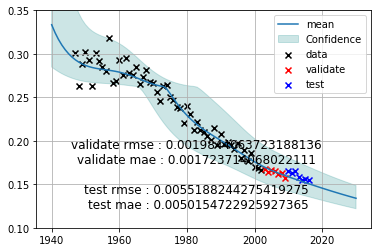

 18%|█▊        | 237/1296 [24:02<2:34:18,  8.74s/it]

validate rmse : 0.0019844063723188136 
 validate mae : 0.001723714068022111 

    test rmse : 0.0055188244275419275 
 test mae : 0.0050154722925927365
(('sa', 2), ('sa', 1), ('sal', 2), ('sal', 2))
params:[-1.01374467e-01  2.00150739e+02]


 18%|█▊        | 238/1296 [24:11<2:35:52,  8.84s/it]

validate rmse : 0.002556492848071551 
 validate mae : 0.0018817488240296823 

    test rmse : 0.003555385430139264 
 test mae : 0.0027647647535897174
(('sa', 2), ('sa', 1), ('sal', 2), ('box_cox', 1))


 18%|█▊        | 239/1296 [24:17<2:17:34,  7.81s/it]

params:[ 1.54597821e-02 -2.75735450e+01]
validate rmse : 0.0755101473913971 
 validate mae : 0.07497582050770611 

    test rmse : 0.08974875792086638 
 test mae : 0.08956674202728619
(('sa', 2), ('sa', 1), ('sal', 2), ('box_cox', 2))


 19%|█▊        | 240/1296 [24:33<3:01:56, 10.34s/it]

params:[ 2.58484367e-02 -4.63820112e+01]
validate rmse : 0.09555812959426892 
 validate mae : 0.09544117450690584 

    test rmse : 0.10117438800764679 
 test mae : 0.10107460983177478
(('sa', 2), ('sa', 1), ('box_cox', 1), ('sa', 1))


 19%|█▊        | 241/1296 [24:34<2:10:16,  7.41s/it]

params:[-8.08699702e-02  1.58934844e+02]
validate rmse : 0.007277061694337862 
 validate mae : 0.007063016213126736 

    test rmse : 0.003612655753573689 
 test mae : 0.003126067545331548
(('sa', 2), ('sa', 1), ('box_cox', 1), ('sa', 2))


 19%|█▊        | 242/1296 [24:34<1:35:08,  5.42s/it]

params:[-8.08698541e-02  1.58934615e+02]
validate rmse : 0.007277107203962096 
 validate mae : 0.007063063109817366 

    test rmse : 0.0036127093333891483 
 test mae : 0.0031261192073256078
(('sa', 2), ('sa', 1), ('box_cox', 1), ('sal', 1))


 19%|█▉        | 243/1296 [24:38<1:26:11,  4.91s/it]

params:[-1.08807124e-01  2.14861181e+02]
validate rmse : 0.002169716501647219 
 validate mae : 0.001930477701389845 

    test rmse : 0.008392806273483443 
 test mae : 0.008124775082393525
(('sa', 2), ('sa', 1), ('box_cox', 1), ('sal', 2))


 19%|█▉        | 244/1296 [24:46<1:42:48,  5.86s/it]

params:[-1.36960408e-01  2.73196247e+02]
validate rmse : 0.011398171639823486 
 validate mae : 0.010881982518619668 

    test rmse : 0.025753061650525415 
 test mae : 0.02565849759057866
(('sa', 2), ('sa', 1), ('box_cox', 1), ('box_cox', 1))


 19%|█▉        | 245/1296 [24:47<1:14:41,  4.26s/it]

params:[-8.76725017e-02  1.70806603e+02]
validate rmse : 0.005137567079857863 
 validate mae : 0.004818928584374236 

    test rmse : 0.0024669429413589484 
 test mae : 0.0018176926496096138
(('sa', 2), ('sa', 1), ('box_cox', 1), ('box_cox', 2))


 19%|█▉        | 246/1296 [24:47<55:43,  3.18s/it]  

params:[-8.12040450e-02  1.56960914e+02]
validate rmse : 0.0039757437622488945 
 validate mae : 0.0035415680319482606 

    test rmse : 0.0033113352811127285 
 test mae : 0.002648901122683674
(('sa', 2), ('sa', 1), ('box_cox', 2), ('sa', 1))


 19%|█▉        | 247/1296 [24:48<41:43,  2.39s/it]

params:[-7.26523273e-02  1.41954355e+02]
validate rmse : 0.006108183840399644 
 validate mae : 0.0058513321936649 

    test rmse : 0.0028997363097443057 
 test mae : 0.0026135203423541292
(('sa', 2), ('sa', 1), ('box_cox', 2), ('sa', 2))


 19%|█▉        | 248/1296 [24:49<33:57,  1.94s/it]

params:[-7.26523688e-02  1.41954438e+02]
validate rmse : 0.006108160444646054 
 validate mae : 0.005851307766818482 

    test rmse : 0.0028997198379986395 
 test mae : 0.0026135055094057835
(('sa', 2), ('sa', 1), ('box_cox', 2), ('sal', 1))


 19%|█▉        | 249/1296 [24:50<28:54,  1.66s/it]

params:[-1.01180314e-01  1.99877989e+02]
validate rmse : 0.006596399700819914 
 validate mae : 0.006359325531202288 

    test rmse : 0.0028554059094445905 
 test mae : 0.002566893632247983
(('sa', 2), ('sa', 1), ('box_cox', 2), ('sal', 2))
params:[-2.32838436e+04  4.50038300e+07]


 19%|█▉        | 250/1296 [24:55<47:00,  2.70s/it]

validate rmse : 0.012772822873008637 
 validate mae : 0.0126401638922957 

    test rmse : 0.010268870661521311 
 test mae : 0.009865035985015936
(('sa', 2), ('sa', 1), ('box_cox', 2), ('box_cox', 1))


 19%|█▉        | 251/1296 [24:56<36:34,  2.10s/it]

params:[-7.94788884e-02  1.53602642e+02]
validate rmse : 0.005172071008366971 
 validate mae : 0.004863686301467365 

    test rmse : 0.002445972066538693 
 test mae : 0.0020053488815602832
(('sa', 2), ('sa', 1), ('box_cox', 2), ('box_cox', 2))


 19%|█▉        | 252/1296 [24:56<29:39,  1.70s/it]

params:[-6.99778463e-02  1.33816326e+02]
validate rmse : 0.004090132558019545 
 validate mae : 0.0036846726710031063 

    test rmse : 0.0029595928607475115 
 test mae : 0.0022291738208424067
(('sa', 2), ('sa', 2), ('sa', 1), ('sa', 1))


 20%|█▉        | 253/1296 [24:57<23:56,  1.38s/it]

params:[-8.20155254e-02  1.61944471e+02]
validate rmse : 0.00623724254739538 
 validate mae : 0.005922948622694856 

    test rmse : 0.005587766296141778 
 test mae : 0.004666264603904909
(('sa', 2), ('sa', 2), ('sa', 1), ('sa', 2))


 20%|█▉        | 254/1296 [24:58<21:03,  1.21s/it]

params:[-8.20155269e-02  1.61944475e+02]
validate rmse : 0.006237248080045045 
 validate mae : 0.00592295447589158 

    test rmse : 0.005587767888754281 
 test mae : 0.00466626642229398
(('sa', 2), ('sa', 2), ('sa', 1), ('sal', 1))


 20%|█▉        | 255/1296 [25:00<24:02,  1.39s/it]

params:[-1.08323520e-01  2.13869514e+02]
validate rmse : 0.003976080337717028 
 validate mae : 0.0034803661310286805 

    test rmse : 0.015147427866523074 
 test mae : 0.015025643394247362
(('sa', 2), ('sa', 2), ('sa', 1), ('sal', 2))
params:[-7.69827023e+00  1.51215610e+04]


 20%|█▉        | 256/1296 [25:09<1:02:45,  3.62s/it]

validate rmse : 0.0031110748246264562 
 validate mae : 0.0027744383367290515 

    test rmse : 0.005299167766513455 
 test mae : 0.004909134524531087
(('sa', 2), ('sa', 2), ('sa', 1), ('box_cox', 1))


 20%|█▉        | 257/1296 [25:09<47:28,  2.74s/it]  

params:[-8.61787103e-02  1.69067315e+02]
validate rmse : 0.004816091293458237 
 validate mae : 0.004447016306313516 

    test rmse : 0.003643070077503768 
 test mae : 0.003257586976410796
(('sa', 2), ('sa', 2), ('sa', 1), ('box_cox', 2))


 20%|█▉        | 258/1296 [25:10<36:25,  2.11s/it]

params:[-8.41239622e-02  1.63879256e+02]
validate rmse : 0.006846459193078188 
 validate mae : 0.006618796954742513 

    test rmse : 0.0032911045087074477 
 test mae : 0.0029081941876642403
(('sa', 2), ('sa', 2), ('sa', 2), ('sa', 1))


 20%|█▉        | 259/1296 [25:11<29:31,  1.71s/it]

params:[-8.20155191e-02  1.61944459e+02]
validate rmse : 0.0062372463954195575 
 validate mae : 0.00592295271146448 

    test rmse : 0.00558776689663116 
 test mae : 0.004666265471596959
(('sa', 2), ('sa', 2), ('sa', 2), ('sa', 2))


 20%|██        | 260/1296 [25:12<25:39,  1.49s/it]

params:[-8.20155136e-02  1.61944448e+02]
validate rmse : 0.006237244577743249 
 validate mae : 0.005922950805628423 

    test rmse : 0.00558776582906083 
 test mae : 0.004666264450839124
(('sa', 2), ('sa', 2), ('sa', 2), ('sal', 1))


 20%|██        | 261/1296 [25:14<28:37,  1.66s/it]

params:[-1.08286204e-01  2.13802665e+02]
validate rmse : 0.003904150830495407 
 validate mae : 0.003426462352893769 

    test rmse : 0.014941457763067247 
 test mae : 0.014819390259201112
(('sa', 2), ('sa', 2), ('sa', 2), ('sal', 2))
params:[-1.07217235e-01  2.11640087e+02]


 20%|██        | 262/1296 [25:24<1:10:47,  4.11s/it]

validate rmse : 0.0027389688616205007 
 validate mae : 0.002210192898388657 

    test rmse : 0.005077108213506622 
 test mae : 0.004587465189801644
(('sa', 2), ('sa', 2), ('sa', 2), ('box_cox', 1))


 20%|██        | 263/1296 [25:24<53:08,  3.09s/it]  

params:[-8.61787054e-02  1.69067305e+02]
validate rmse : 0.0048160964145765196 
 validate mae : 0.004447021684017707 

    test rmse : 0.0036430777692029216 
 test mae : 0.003257593069008893
(('sa', 2), ('sa', 2), ('sa', 2), ('box_cox', 2))


 20%|██        | 264/1296 [25:25<41:16,  2.40s/it]

params:[-8.41239335e-02  1.63879199e+02]
validate rmse : 0.0068464587133079124 
 validate mae : 0.006618796459288455 

    test rmse : 0.003291103806857139 
 test mae : 0.0029081936859709262
(('sa', 2), ('sa', 2), ('sal', 1), ('sa', 1))


 20%|██        | 265/1296 [25:28<46:49,  2.73s/it]

params:[-1.08253439e-01  2.13764496e+02]
validate rmse : 0.004188281689586437 
 validate mae : 0.0036343988480066957 

    test rmse : 0.01569938622989734 
 test mae : 0.015578104429405647
(('sa', 2), ('sa', 2), ('sal', 1), ('sa', 2))


 21%|██        | 266/1296 [25:31<43:40,  2.54s/it]

params:[-1.08310645e-01  2.13893571e+02]
validate rmse : 0.004061935714047716 
 validate mae : 0.0035409123457405705 

    test rmse : 0.015336598922739007 
 test mae : 0.015215331213353575
(('sa', 2), ('sa', 2), ('sal', 1), ('sal', 1))


 21%|██        | 267/1296 [25:33<40:37,  2.37s/it]

params:[-1.06422246e-01  2.10005623e+02]
validate rmse : 0.0041716648526678455 
 validate mae : 0.003615810767859745 

    test rmse : 0.015647456257270192 
 test mae : 0.015525250296405394
(('sa', 2), ('sa', 2), ('sal', 1), ('sal', 2))


 21%|██        | 268/1296 [25:48<1:46:52,  6.24s/it]

params:[-1.13444125e-01  2.23709736e+02]
validate rmse : 0.009660068149973201 
 validate mae : 0.008657169266735478 

    test rmse : 0.027989478889270444 
 test mae : 0.027803354779238447
(('sa', 2), ('sa', 2), ('sal', 1), ('box_cox', 1))


 21%|██        | 269/1296 [25:50<1:25:53,  5.02s/it]

params:[-1.06285570e-01  2.08981405e+02]
validate rmse : 0.0021258449574044136 
 validate mae : 0.0017477294711842656 

    test rmse : 0.008031763081487304 
 test mae : 0.007786485443524512
(('sa', 2), ('sa', 2), ('sal', 1), ('box_cox', 2))


 21%|██        | 270/1296 [25:53<1:16:29,  4.47s/it]

params:[-1.09027667e-01  2.13234692e+02]
validate rmse : 0.002579897200067875 
 validate mae : 0.002008386748790051 

    test rmse : 0.012214218129560474 
 test mae : 0.012054426955450694
(('sa', 2), ('sa', 2), ('sal', 2), ('sa', 1))
params:[-1.07185878e-01  2.11532029e+02]


 21%|██        | 271/1296 [26:05<1:52:20,  6.58s/it]

validate rmse : 0.002363537373084404 
 validate mae : 0.001828410079763956 

    test rmse : 0.00681702064918961 
 test mae : 0.006513889109304592
(('sa', 2), ('sa', 2), ('sal', 2), ('sa', 2))


 21%|██        | 272/1296 [26:15<2:12:16,  7.75s/it]

params:[-1.07840218e-01  2.12986123e+02]
validate rmse : 0.002102928017424506 
 validate mae : 0.0017601793620458145 

    test rmse : 0.0053028456757361255 
 test mae : 0.004785017268651326
(('sa', 2), ('sa', 2), ('sal', 2), ('sal', 1))
params:[-1.07307866e-01  2.11908365e+02]


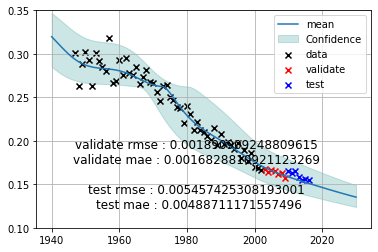

 21%|██        | 273/1296 [26:24<2:18:31,  8.12s/it]

validate rmse : 0.001890909248809615 
 validate mae : 0.0016828810921123269 

    test rmse : 0.005457425308193001 
 test mae : 0.00488711171557496
(('sa', 2), ('sa', 2), ('sal', 2), ('sal', 2))


 21%|██        | 274/1296 [26:34<2:29:35,  8.78s/it]

params:[-3.34789507e+00  6.58237118e+03]
validate rmse : 0.002293424381383303 
 validate mae : 0.0020277797814959825 

    test rmse : 0.004935602546573637 
 test mae : 0.004630967815851638
(('sa', 2), ('sa', 2), ('sal', 2), ('box_cox', 1))


 21%|██        | 275/1296 [26:56<3:31:50, 12.45s/it]

params:[-1.06657343e-01  2.09750549e+02]
validate rmse : 0.004511436589989389 
 validate mae : 0.004146307825480704 

    test rmse : 0.0029413695227199377 
 test mae : 0.002287300041712035
(('sa', 2), ('sa', 2), ('sal', 2), ('box_cox', 2))


 21%|██▏       | 276/1296 [27:06<3:19:13, 11.72s/it]

params:[-1.04733504e-01  2.04757175e+02]
validate rmse : 0.004421816111644623 
 validate mae : 0.004042417722902917 

    test rmse : 0.0029731341154485363 
 test mae : 0.002311637105960908
(('sa', 2), ('sa', 2), ('box_cox', 1), ('sa', 1))


 21%|██▏       | 277/1296 [27:06<2:23:07,  8.43s/it]

params:[-8.08699132e-02  1.58934731e+02]
validate rmse : 0.007277091565508815 
 validate mae : 0.007063046994954152 

    test rmse : 0.0036126899713917887 
 test mae : 0.0031261006037612443
(('sa', 2), ('sa', 2), ('box_cox', 1), ('sa', 2))


 21%|██▏       | 278/1296 [27:07<1:43:47,  6.12s/it]

params:[-8.08699259e-02  1.58934758e+02]
validate rmse : 0.0072770722181005245 
 validate mae : 0.007063027053460945 

    test rmse : 0.0036126733344033638 
 test mae : 0.0031260841273757895
(('sa', 2), ('sa', 2), ('box_cox', 1), ('sal', 1))


 22%|██▏       | 279/1296 [27:11<1:30:53,  5.36s/it]

params:[-1.08805355e-01  2.14857601e+02]
validate rmse : 0.0021703334479124766 
 validate mae : 0.0019307715999981006 

    test rmse : 0.008395835343668716 
 test mae : 0.00812797855453665
(('sa', 2), ('sa', 2), ('box_cox', 1), ('sal', 2))
params:[-6.98593380e+10  1.37199498e+14]


 22%|██▏       | 280/1296 [27:19<1:45:02,  6.20s/it]

validate rmse : 0.012999547944433322 
 validate mae : 0.01174981623966687 

    test rmse : 0.018225636355636808 
 test mae : 0.01776251223708827
(('sa', 2), ('sa', 2), ('box_cox', 1), ('box_cox', 1))


 22%|██▏       | 281/1296 [27:19<1:16:34,  4.53s/it]

params:[-8.76725229e-02  1.70806644e+02]
validate rmse : 0.0051375452189614725 
 validate mae : 0.00481890506091741 

    test rmse : 0.002466951310060686 
 test mae : 0.0018176856728634966
(('sa', 2), ('sa', 2), ('box_cox', 1), ('box_cox', 2))


 22%|██▏       | 282/1296 [27:20<57:26,  3.40s/it]  

params:[-8.1203952e-02  1.5696073e+02]
validate rmse : 0.003975759989187564 
 validate mae : 0.003541586588601181 

    test rmse : 0.0033113169366875634 
 test mae : 0.0026488824173198605
(('sa', 2), ('sa', 2), ('box_cox', 2), ('sa', 1))


 22%|██▏       | 283/1296 [27:21<43:38,  2.59s/it]

params:[-7.26523947e-02  1.41954487e+02]
validate rmse : 0.006108138104774179 
 validate mae : 0.005851284445462485 

    test rmse : 0.0028997028063010365 
 test mae : 0.00261349016025042
(('sa', 2), ('sa', 2), ('box_cox', 2), ('sa', 2))


 22%|██▏       | 284/1296 [27:22<34:48,  2.06s/it]

params:[-7.26523727e-02  1.41954444e+02]
validate rmse : 0.006108152613963612 
 validate mae : 0.005851299594365038 

    test rmse : 0.0028997127724396505 
 test mae : 0.002613499132769176
(('sa', 2), ('sa', 2), ('box_cox', 2), ('sal', 1))


 22%|██▏       | 285/1296 [27:23<30:28,  1.81s/it]

params:[-1.01181241e-01  1.99879689e+02]
validate rmse : 0.006595485651195689 
 validate mae : 0.0063583755601221625 

    test rmse : 0.002854687300081991 
 test mae : 0.0025662798022251638
(('sa', 2), ('sa', 2), ('box_cox', 2), ('sal', 2))


 22%|██▏       | 286/1296 [27:27<39:38,  2.36s/it]

params:[-1.12029464e-01  2.21201428e+02]
validate rmse : 0.002516213683843554 
 validate mae : 0.002236894480747447 

    test rmse : 0.011313801813134544 
 test mae : 0.011162446888384374
(('sa', 2), ('sa', 2), ('box_cox', 2), ('box_cox', 1))


 22%|██▏       | 287/1296 [27:27<31:20,  1.86s/it]

params:[-7.94787978e-02  1.53602464e+02]
validate rmse : 0.005172102676745328 
 validate mae : 0.004863720137763011 

    test rmse : 0.002445970739667148 
 test mae : 0.0020053587741970446
(('sa', 2), ('sa', 2), ('box_cox', 2), ('box_cox', 2))


 22%|██▏       | 288/1296 [27:28<25:32,  1.52s/it]

params:[-6.99776177e-02  1.33815870e+02]
validate rmse : 0.004090087822970243 
 validate mae : 0.003684622751099887 

    test rmse : 0.0029596277176568847 
 test mae : 0.002229216654982808
(('sa', 2), ('sal', 1), ('sa', 1), ('sa', 1))


 22%|██▏       | 289/1296 [27:30<28:39,  1.71s/it]

params:[-1.08324170e-01  2.13923428e+02]
validate rmse : 0.004039190819596066 
 validate mae : 0.0035239875618378164 

    test rmse : 0.015271068849414949 
 test mae : 0.015149760650394802
(('sa', 2), ('sal', 1), ('sa', 1), ('sa', 2))


 22%|██▏       | 290/1296 [27:32<30:58,  1.85s/it]

params:[-1.08360479e-01  2.14003016e+02]
validate rmse : 0.0039854977674830755 
 validate mae : 0.0034839669069180695 

    test rmse : 0.015117145311825526 
 test mae : 0.014995680173901417
(('sa', 2), ('sal', 1), ('sa', 1), ('sal', 1))


 22%|██▏       | 291/1296 [27:34<30:24,  1.82s/it]

params:[-1.06412270e-01  2.09986028e+02]
validate rmse : 0.004164091614415412 
 validate mae : 0.0036103121604575644 

    test rmse : 0.015627530662519595 
 test mae : 0.015505316937413274
(('sa', 2), ('sal', 1), ('sa', 1), ('sal', 2))


 23%|██▎       | 292/1296 [27:40<53:47,  3.21s/it]

params:[-9.33405239e-02  1.84114920e+02]
validate rmse : 0.0028756051707890164 
 validate mae : 0.0026335541906676824 

    test rmse : 0.013417132446066985 
 test mae : 0.013275898145240142
(('sa', 2), ('sal', 1), ('sa', 1), ('box_cox', 1))


 23%|██▎       | 293/1296 [27:42<47:21,  2.83s/it]

params:[-1.06171531e-01  2.08786485e+02]
validate rmse : 0.002136026791951785 
 validate mae : 0.0017814201837096724 

    test rmse : 0.008491376322852602 
 test mae : 0.008269509678626928
(('sa', 2), ('sal', 1), ('sa', 1), ('box_cox', 2))


 23%|██▎       | 294/1296 [27:44<42:01,  2.52s/it]

params:[-1.08647513e-01  2.12536793e+02]
validate rmse : 0.0025839870376533035 
 validate mae : 0.0019787719947129134 

    test rmse : 0.012030352913926921 
 test mae : 0.011870187750714054
(('sa', 2), ('sal', 1), ('sa', 2), ('sa', 1))


 23%|██▎       | 295/1296 [27:46<38:55,  2.33s/it]

params:[-1.08229018e-01  2.13713851e+02]
validate rmse : 0.004199565814233424 
 validate mae : 0.0036427482464631844 

    test rmse : 0.015733243976591985 
 test mae : 0.01561191892180768
(('sa', 2), ('sal', 1), ('sa', 2), ('sa', 2))


 23%|██▎       | 296/1296 [27:48<36:46,  2.21s/it]

params:[-1.08369539e-01  2.14025104e+02]
validate rmse : 0.003950628441961558 
 validate mae : 0.00345773237029661 

    test rmse : 0.015014323402368614 
 test mae : 0.014892731953834825
(('sa', 2), ('sal', 1), ('sa', 2), ('sal', 1))


 23%|██▎       | 297/1296 [27:50<37:00,  2.22s/it]

params:[-1.06309903e-01  2.09785543e+02]
validate rmse : 0.004050097516828936 
 validate mae : 0.003526230715432716 

    test rmse : 0.015315169086282642 
 test mae : 0.015192766608906613
(('sa', 2), ('sal', 1), ('sa', 2), ('sal', 2))


 23%|██▎       | 298/1296 [28:04<1:32:09,  5.54s/it]

params:[-1.08599675e-01  2.14388916e+02]
validate rmse : 0.005747640634026253 
 validate mae : 0.004929998352222941 

    test rmse : 0.02399695963156616 
 test mae : 0.02366158226082733
(('sa', 2), ('sal', 1), ('sa', 2), ('box_cox', 1))


 23%|██▎       | 299/1296 [28:06<1:14:12,  4.47s/it]

params:[-1.06040586e-01  2.08508679e+02]
validate rmse : 0.0021452070588413104 
 validate mae : 0.0017790128197086824 

    test rmse : 0.008555247647179378 
 test mae : 0.008337409419515083
(('sa', 2), ('sal', 1), ('sa', 2), ('box_cox', 2))


 23%|██▎       | 300/1296 [28:07<1:00:33,  3.65s/it]

params:[ 3.62781256e-02 -6.96266837e+01]
validate rmse : 0.03715179964725202 
 validate mae : 0.03612345665478694 

    test rmse : 0.05624143562785231 
 test mae : 0.05573262828606499
(('sa', 2), ('sal', 1), ('sal', 1), ('sa', 1))


 23%|██▎       | 301/1296 [28:11<59:07,  3.56s/it]  

params:[-1.06041247e-01  2.09257494e+02]
validate rmse : 0.004122375746920999 
 validate mae : 0.0035785989416593144 

    test rmse : 0.015497359064180996 
 test mae : 0.015375243099970218
(('sa', 2), ('sal', 1), ('sal', 1), ('sa', 2))


 23%|██▎       | 302/1296 [28:13<53:11,  3.21s/it]

params:[-1.06045984e-01  2.09266458e+02]
validate rmse : 0.004139935107023081 
 validate mae : 0.0035920693018826728 

    test rmse : 0.015555825791286015 
 test mae : 0.015433621372159787
(('sa', 2), ('sal', 1), ('sal', 1), ('sal', 1))


 23%|██▎       | 303/1296 [28:15<49:15,  2.98s/it]

params:[-1.0807760e-01  2.1327951e+02]
validate rmse : 0.0050765208376536974 
 validate mae : 0.004258758588938173 

    test rmse : 0.017693358702216114 
 test mae : 0.01757204705921259
(('sa', 2), ('sal', 1), ('sal', 1), ('sal', 2))


 23%|██▎       | 304/1296 [28:28<1:34:38,  5.72s/it]

params:[-1.09289483e-01  2.15738061e+02]
validate rmse : 0.008001538274416485 
 validate mae : 0.006550427339278532 

    test rmse : 0.03200653767639852 
 test mae : 0.031426450267270756
(('sa', 2), ('sal', 1), ('sal', 1), ('box_cox', 1))


 24%|██▎       | 305/1296 [28:30<1:16:58,  4.66s/it]

params:[-1.05089615e-01  2.06431637e+02]
validate rmse : 0.0026891168689800516 
 validate mae : 0.002430230070054206 

    test rmse : 0.01185670813660337 
 test mae : 0.011710721726582404
(('sa', 2), ('sal', 1), ('sal', 1), ('box_cox', 2))


 24%|██▎       | 306/1296 [28:33<1:08:08,  4.13s/it]

params:[-1.04902405e-01  2.04989655e+02]
validate rmse : 0.0028961067731644212 
 validate mae : 0.002630990764377335 

    test rmse : 0.013961675258390606 
 test mae : 0.013810563966143817
(('sa', 2), ('sal', 1), ('sal', 2), ('sa', 1))


 24%|██▎       | 307/1296 [28:44<1:42:04,  6.19s/it]

params:[-1.41270762e-01  2.79049299e+02]
validate rmse : 0.02614672483048579 
 validate mae : 0.02467652973628356 

    test rmse : 0.05930232138249113 
 test mae : 0.05882014023861292
(('sa', 2), ('sal', 1), ('sal', 2), ('sa', 2))


 24%|██▍       | 308/1296 [28:51<1:46:20,  6.46s/it]

params:[-1.10594009e-01  2.18371365e+02]
validate rmse : 0.0028478937643276895 
 validate mae : 0.002454847695195685 

    test rmse : 0.01481281072302883 
 test mae : 0.014618778850138054
(('sa', 2), ('sal', 1), ('sal', 2), ('sal', 1))


 24%|██▍       | 309/1296 [28:55<1:34:11,  5.73s/it]

params:[-1.02209578e-01  2.01661591e+02]
validate rmse : 0.002342488592595006 
 validate mae : 0.0020292176595926104 

    test rmse : 0.010080698405941058 
 test mae : 0.009901865339390886
(('sa', 2), ('sal', 1), ('sal', 2), ('sal', 2))


 24%|██▍       | 310/1296 [29:07<2:07:02,  7.73s/it]

params:[-1.08317515e-01  2.13996797e+02]
validate rmse : 0.004864053651309189 
 validate mae : 0.004189294072072676 

    test rmse : 0.01861460016343557 
 test mae : 0.01845363886080168
(('sa', 2), ('sal', 1), ('sal', 2), ('box_cox', 1))


 24%|██▍       | 311/1296 [29:14<2:01:59,  7.43s/it]

params:[-1.07021009e-01  2.10357876e+02]
validate rmse : 0.004220327248330424 
 validate mae : 0.003471359381156764 

    test rmse : 0.013078723727692294 
 test mae : 0.012729549933523931
(('sa', 2), ('sal', 1), ('sal', 2), ('box_cox', 2))


 24%|██▍       | 312/1296 [29:17<1:41:24,  6.18s/it]

params:[ 5.23114001e-02 -1.00794430e+02]
validate rmse : 0.0864169572877677 
 validate mae : 0.08607630124977005 

    test rmse : 0.09610787173521075 
 test mae : 0.09597901844454129
(('sa', 2), ('sal', 1), ('box_cox', 1), ('sa', 1))


 24%|██▍       | 313/1296 [29:20<1:22:23,  5.03s/it]

params:[-9.65181340e-02  1.90080442e+02]
validate rmse : 0.002673949025207954 
 validate mae : 0.0019334355026105557 

    test rmse : 0.010680612581028561 
 test mae : 0.010510117764948673
(('sa', 2), ('sal', 1), ('box_cox', 1), ('sa', 2))


 24%|██▍       | 314/1296 [29:21<1:07:13,  4.11s/it]

params:[-9.61993175e-02  1.89432686e+02]
validate rmse : 0.002671082267909671 
 validate mae : 0.0019231798606706826 

    test rmse : 0.010777027831115085 
 test mae : 0.010607105795493815
(('sa', 2), ('sal', 1), ('box_cox', 1), ('sal', 1))


 24%|██▍       | 315/1296 [29:24<57:30,  3.52s/it]  

params:[-1.13627558e-01  2.24303184e+02]
validate rmse : 0.007992798384116926 
 validate mae : 0.006957074839541356 

    test rmse : 0.025287146737208322 
 test mae : 0.025098703409958543
(('sa', 2), ('sal', 1), ('box_cox', 1), ('sal', 2))


 24%|██▍       | 316/1296 [29:32<1:22:32,  5.05s/it]

params:[-1.11652683e-01  2.20367996e+02]
validate rmse : 0.003042552621827913 
 validate mae : 0.002794217645422374 

    test rmse : 0.013879751963240603 
 test mae : 0.013741146200320683
(('sa', 2), ('sal', 1), ('box_cox', 1), ('box_cox', 1))


 24%|██▍       | 317/1296 [29:34<1:06:46,  4.09s/it]

params:[-1.08521679e-01  2.12235184e+02]
validate rmse : 0.004538405486127522 
 validate mae : 0.0038585468449060917 

    test rmse : 0.01641606848247588 
 test mae : 0.01629396009715352
(('sa', 2), ('sal', 1), ('box_cox', 1), ('box_cox', 2))


 25%|██▍       | 318/1296 [29:36<56:56,  3.49s/it]  

params:[-1.01544612e-01  1.97321876e+02]
validate rmse : 0.00899165157288302 
 validate mae : 0.008155451444030543 

    test rmse : 0.02582750182918643 
 test mae : 0.025661326703821947
(('sa', 2), ('sal', 1), ('box_cox', 2), ('sa', 1))


 25%|██▍       | 319/1296 [29:38<49:16,  3.03s/it]

params:[-8.92013713e-02  1.74910213e+02]
validate rmse : 0.004770103598748693 
 validate mae : 0.004027834745826468 

    test rmse : 0.017545141302758173 
 test mae : 0.01741464001215783
(('sa', 2), ('sal', 1), ('box_cox', 2), ('sa', 2))


 25%|██▍       | 320/1296 [29:40<45:14,  2.78s/it]

params:[-8.92451317e-02  1.74997598e+02]
validate rmse : 0.004793164969576397 
 validate mae : 0.00404209904529929 

    test rmse : 0.017586452888044137 
 test mae : 0.01745598881766074
(('sa', 2), ('sal', 1), ('box_cox', 2), ('sal', 1))


 25%|██▍       | 321/1296 [29:43<42:32,  2.62s/it]

params:[-1.13653601e-01  2.24379676e+02]
validate rmse : 0.006113033181860451 
 validate mae : 0.005172950519531451 

    test rmse : 0.020151614990841386 
 test mae : 0.02001533445004098
(('sa', 2), ('sal', 1), ('box_cox', 2), ('sal', 2))


 25%|██▍       | 322/1296 [29:48<57:59,  3.57s/it]

params:[-5.69150549e+07  1.11644996e+11]
validate rmse : 0.012461102583099721 
 validate mae : 0.011381751433057728 

    test rmse : 0.019723801424406835 
 test mae : 0.019279414678518375
(('sa', 2), ('sal', 1), ('box_cox', 2), ('box_cox', 1))


 25%|██▍       | 323/1296 [29:50<48:33,  2.99s/it]

params:[-1.02071765e-01  1.98358623e+02]
validate rmse : 0.00780201370063852 
 validate mae : 0.00698012833728609 

    test rmse : 0.023331262528361797 
 test mae : 0.023182818013254416
(('sa', 2), ('sal', 1), ('box_cox', 2), ('box_cox', 2))


 25%|██▌       | 324/1296 [29:52<43:03,  2.66s/it]

params:[-8.77963465e-02  1.69132053e+02]
validate rmse : 0.011717931265034077 
 validate mae : 0.010994149964296552 

    test rmse : 0.029824517955334903 
 test mae : 0.029651015557544815
(('sa', 2), ('sal', 2), ('sa', 1), ('sa', 1))


 25%|██▌       | 325/1296 [30:11<2:01:09,  7.49s/it]

params:[-1.03727131e-01  2.05018946e+02]
validate rmse : 0.005626812675277889 
 validate mae : 0.005347451284089584 

    test rmse : 0.0023327149153283665 
 test mae : 0.0018402948430902408
(('sa', 2), ('sal', 2), ('sa', 1), ('sa', 2))


 25%|██▌       | 326/1296 [30:31<3:02:01, 11.26s/it]

params:[-1.05457950e-01  2.08177749e+02]
validate rmse : 0.003420442245645771 
 validate mae : 0.0028912474505622715 

    test rmse : 0.004233758941056698 
 test mae : 0.0036259116029395805
(('sa', 2), ('sal', 2), ('sa', 1), ('sal', 1))
params:[-1.09841189e-01  2.16955622e+02]


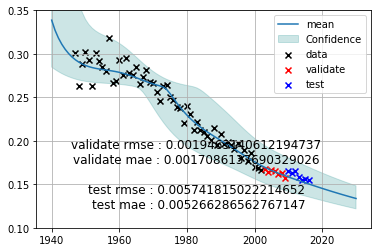

 25%|██▌       | 327/1296 [31:16<5:46:56, 21.48s/it]

validate rmse : 0.0019463140612194737 
 validate mae : 0.0017086137690329026 

    test rmse : 0.005741815022214652 
 test mae : 0.005266286562767147
(('sa', 2), ('sal', 2), ('sa', 1), ('sal', 2))
params:[99.00000082 -1.        ]


 25%|██▌       | 328/1296 [31:32<5:17:54, 19.71s/it]

validate rmse : 0.09715425214448323 
 validate mae : 0.09709968538140852 

    test rmse : 0.10144006588608032 
 test mae : 0.10134366165544126
(('sa', 2), ('sal', 2), ('sa', 1), ('box_cox', 1))


 25%|██▌       | 329/1296 [31:49<5:07:13, 19.06s/it]

params:[-8.26276472e-02  1.62550318e+02]
validate rmse : 0.005492613625542712 
 validate mae : 0.00491821572463208 

    test rmse : 0.0077356000015262275 
 test mae : 0.006654732051716203
(('sa', 2), ('sal', 2), ('sa', 1), ('box_cox', 2))


 25%|██▌       | 330/1296 [32:10<5:13:19, 19.46s/it]

params:[-1.05851907e-01  2.07112581e+02]
validate rmse : 0.004718373854500759 
 validate mae : 0.00437281227075721 

    test rmse : 0.002626768524733548 
 test mae : 0.0018592983470327926
(('sa', 2), ('sal', 2), ('sa', 2), ('sa', 1))


 26%|██▌       | 331/1296 [32:13<3:57:30, 14.77s/it]

params:[-1.08136888e-01  2.13328180e+02]
validate rmse : 0.00513375557714602 
 validate mae : 0.004319465129426413 

    test rmse : 0.017007556691217368 
 test mae : 0.016895651283073514
(('sa', 2), ('sal', 2), ('sa', 2), ('sa', 2))


 26%|██▌       | 332/1296 [32:18<3:07:37, 11.68s/it]

params:[-5.24215532e+00  1.04085401e+04]
validate rmse : 0.18297957418569788 
 validate mae : 0.18292591602166922 

    test rmse : 0.19824886078284806 
 test mae : 0.19823937404119585
(('sa', 2), ('sal', 2), ('sa', 2), ('sal', 1))
params:[-1.08982199e-01  2.15254430e+02]


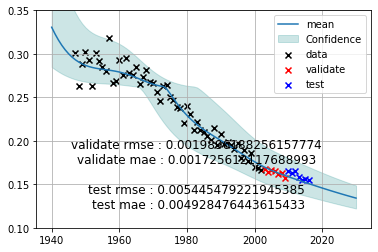

 26%|██▌       | 333/1296 [32:30<3:07:22, 11.67s/it]

validate rmse : 0.0019896188256157774 
 validate mae : 0.001725612117688993 

    test rmse : 0.005445479221945385 
 test mae : 0.004928476443615433
(('sa', 2), ('sal', 2), ('sa', 2), ('sal', 2))


 26%|██▌       | 334/1296 [32:57<4:21:32, 16.31s/it]

params:[-1.09227624e-01  2.15542250e+02]
validate rmse : 0.008683374736869956 
 validate mae : 0.0077502098682364195 

    test rmse : 0.023566073807460855 
 test mae : 0.02345889370871131
(('sa', 2), ('sal', 2), ('sa', 2), ('box_cox', 1))


 26%|██▌       | 335/1296 [33:21<4:58:46, 18.65s/it]

params:[-1.04944554e-01  2.06275485e+02]
validate rmse : 0.005351260167107357 
 validate mae : 0.0050537425837743856 

    test rmse : 0.002392118640013213 
 test mae : 0.0019038842724101604
(('sa', 2), ('sal', 2), ('sa', 2), ('box_cox', 2))
params:[-1.08283598e-01  2.11830577e+02]


 26%|██▌       | 336/1296 [33:44<5:21:13, 20.08s/it]

validate rmse : 0.0031349781617229463 
 validate mae : 0.002799669953363012 

    test rmse : 0.01280003088692615 
 test mae : 0.012663625799194963
(('sa', 2), ('sal', 2), ('sal', 1), ('sa', 1))
params:[-1.09557065e-01  2.16373287e+02]


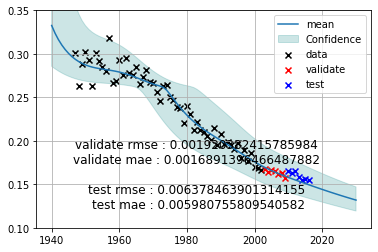

 26%|██▌       | 337/1296 [34:05<5:23:34, 20.24s/it]

validate rmse : 0.001920382415785984 
 validate mae : 0.0016891396466487882 

    test rmse : 0.006378463901314155 
 test mae : 0.005980755809540582
(('sa', 2), ('sal', 2), ('sal', 1), ('sa', 2))


 26%|██▌       | 338/1296 [34:49<7:17:55, 27.43s/it]

params:[-1.12834811e-01  2.22833195e+02]
validate rmse : 0.005112799195849458 
 validate mae : 0.0043052677149136255 

    test rmse : 0.016026947183832397 
 test mae : 0.015918968033856472
(('sa', 2), ('sal', 2), ('sal', 1), ('sal', 1))


 26%|██▌       | 339/1296 [34:57<5:46:14, 21.71s/it]

params:[-1.04844593e-01  2.06944687e+02]
validate rmse : 0.0022219122275642478 
 validate mae : 0.001957666992427752 

    test rmse : 0.007685784267456917 
 test mae : 0.007329185005815356
(('sa', 2), ('sal', 2), ('sal', 1), ('sal', 2))


 26%|██▌       | 340/1296 [35:11<5:07:42, 19.31s/it]

params:[-1.10343395e-01  2.17902696e+02]
validate rmse : 0.004803668847245848 
 validate mae : 0.004148751841108986 

    test rmse : 0.01911460580366586 
 test mae : 0.018925426541857093
(('sa', 2), ('sal', 2), ('sal', 1), ('box_cox', 1))


 26%|██▋       | 341/1296 [35:35<5:29:50, 20.72s/it]

params:[-1.05513770e-01  2.07248666e+02]
validate rmse : 0.0031660771498118155 
 validate mae : 0.0028549283075286164 

    test rmse : 0.01315279021109313 
 test mae : 0.013019566540682984
(('sa', 2), ('sal', 2), ('sal', 1), ('box_cox', 2))


 26%|██▋       | 342/1296 [35:43<4:27:36, 16.83s/it]

params:[-1.05488096e-01  2.06168060e+02]
validate rmse : 0.0025505778978865776 
 validate mae : 0.0021026663675935897 

    test rmse : 0.01205289808198514 
 test mae : 0.011899039058420947
(('sa', 2), ('sal', 2), ('sal', 2), ('sa', 1))
params:[-1.10413897e-01  2.17976232e+02]


 26%|██▋       | 343/1296 [36:02<4:36:16, 17.39s/it]

validate rmse : 0.003619759942070665 
 validate mae : 0.0026328070434447465 

    test rmse : 0.006888717811978431 
 test mae : 0.0055357661056359975
(('sa', 2), ('sal', 2), ('sal', 2), ('sa', 2))


 27%|██▋       | 344/1296 [36:11<3:55:52, 14.87s/it]

params:[-7.83708511e-02  1.53858662e+02]
validate rmse : 0.004263868413824606 
 validate mae : 0.0038732772491915763 

    test rmse : 0.002757910029911625 
 test mae : 0.001974976285046916
(('sa', 2), ('sal', 2), ('sal', 2), ('sal', 1))


 27%|██▋       | 345/1296 [36:17<3:17:12, 12.44s/it]

params:[-1.09714559e-01  2.16566581e+02]
validate rmse : 0.002830834115660452 
 validate mae : 0.0025849530118002007 

    test rmse : 0.013289800634259004 
 test mae : 0.013147769328882805
(('sa', 2), ('sal', 2), ('sal', 2), ('sal', 2))


 27%|██▋       | 346/1296 [36:35<3:40:52, 13.95s/it]

params:[-1.10409094e-01  2.18000783e+02]
validate rmse : 0.002322795621960799 
 validate mae : 0.002002472771850355 

    test rmse : 0.1539409491861926 
 test mae : 0.0858114175437461
(('sa', 2), ('sal', 2), ('sal', 2), ('box_cox', 1))


 27%|██▋       | 347/1296 [36:48<3:38:16, 13.80s/it]

params:[-1.05140006e-01  2.06622325e+02]
validate rmse : 0.004391245287835494 
 validate mae : 0.003890835544049263 

    test rmse : 0.005502131242642886 
 test mae : 0.0051737335487154834
(('sa', 2), ('sal', 2), ('sal', 2), ('box_cox', 2))
params:[-1.10791478e-01  2.16811182e+02]


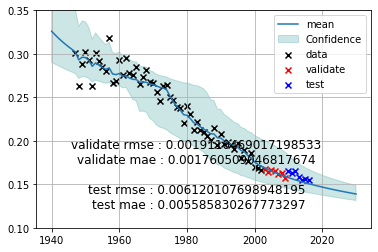

 27%|██▋       | 348/1296 [37:05<3:50:56, 14.62s/it]

validate rmse : 0.0019110469017198533 
 validate mae : 0.001760509046817674 

    test rmse : 0.006120107698948195 
 test mae : 0.005585830267773297
(('sa', 2), ('sal', 2), ('box_cox', 1), ('sa', 1))


 27%|██▋       | 349/1296 [37:25<4:15:30, 16.19s/it]

params:[-9.89301879e-02  1.94796757e+02]
validate rmse : 0.0036589476653871972 
 validate mae : 0.003390048150028274 

    test rmse : 0.017236201072159944 
 test mae : 0.017053105473990526
(('sa', 2), ('sal', 2), ('box_cox', 1), ('sa', 2))


 27%|██▋       | 350/1296 [37:35<3:47:31, 14.43s/it]

params:[-1.01672381e-01  2.00384162e+02]
validate rmse : 0.0027171295209399093 
 validate mae : 0.0021647826827687344 

    test rmse : 0.004562149065903361 
 test mae : 0.0039480249430137015
(('sa', 2), ('sal', 2), ('box_cox', 1), ('sal', 1))


 27%|██▋       | 351/1296 [37:55<4:16:11, 16.27s/it]

params:[-9.28183710e-01  2.23173514e+03]
validate rmse : 0.03636102205529453 
 validate mae : 0.03494021061175641 

    test rmse : 0.0848540635391647 
 test mae : 0.08366224498173794
(('sa', 2), ('sal', 2), ('box_cox', 1), ('sal', 2))
params:[-1.22316194e+02  2.35115537e+05]


 27%|██▋       | 352/1296 [38:19<4:51:32, 18.53s/it]

validate rmse : 0.017461102873425113 
 validate mae : 0.017281969943931746 

    test rmse : 0.018798271978000995 
 test mae : 0.01843025933710985
(('sa', 2), ('sal', 2), ('box_cox', 1), ('box_cox', 1))


 27%|██▋       | 353/1296 [38:49<5:44:25, 21.92s/it]

params:[-1.06277148e-01  2.07933004e+02]
validate rmse : 0.0039559796086565974 
 validate mae : 0.0035310157940422826 

    test rmse : 0.0032778210512279084 
 test mae : 0.002620445268849616
(('sa', 2), ('sal', 2), ('box_cox', 1), ('box_cox', 2))


 27%|██▋       | 354/1296 [38:53<4:17:58, 16.43s/it]

params:[-5.35135563e-02  1.07397718e+02]
validate rmse : 0.2368576693348969 
 validate mae : 0.23495043118670172 

    test rmse : 0.16938722461713146 
 test mae : 0.16930124752454115
(('sa', 2), ('sal', 2), ('box_cox', 2), ('sa', 1))


 27%|██▋       | 355/1296 [39:04<3:53:29, 14.89s/it]

params:[-9.08833007e-02  1.78223585e+02]
validate rmse : 0.007319734292507089 
 validate mae : 0.006393313971034348 

    test rmse : 0.0237030312667464 
 test mae : 0.02351670293607793
(('sa', 2), ('sal', 2), ('box_cox', 2), ('sa', 2))
params:[-9.16980680e-02  1.79831847e+02]


 27%|██▋       | 356/1296 [39:21<4:03:24, 15.54s/it]

validate rmse : 0.008448536578490286 
 validate mae : 0.007548122850201138 

    test rmse : 0.025933765732330787 
 test mae : 0.025730617368674363
(('sa', 2), ('sal', 2), ('box_cox', 2), ('sal', 1))


 28%|██▊       | 357/1296 [39:27<3:15:46, 12.51s/it]

params:[-1.11320473e-01  2.19775798e+02]
validate rmse : 0.004277304554263116 
 validate mae : 0.0036320480705112424 

    test rmse : 0.015411633683402341 
 test mae : 0.015290487649759028
(('sa', 2), ('sal', 2), ('box_cox', 2), ('sal', 2))
params:[ 5.91596843e+10 -1.14405311e+14]


 28%|██▊       | 358/1296 [39:38<3:11:18, 12.24s/it]

validate rmse : 0.06137734244431964 
 validate mae : 0.06109586122547401 

    test rmse : 0.07446451828995172 
 test mae : 0.07419870358954175
(('sa', 2), ('sal', 2), ('box_cox', 2), ('box_cox', 1))


 28%|██▊       | 359/1296 [39:46<2:51:17, 10.97s/it]

params:[-1.00220948e-01  1.94817276e+02]
validate rmse : 0.002024388949068718 
 validate mae : 0.0018002634082385307 

    test rmse : 0.007934037198420143 
 test mae : 0.007639827624231091
(('sa', 2), ('sal', 2), ('box_cox', 2), ('box_cox', 2))


 28%|██▊       | 360/1296 [39:59<3:01:06, 11.61s/it]

params:[-6.77095169e-02  1.35815802e+02]
validate rmse : 0.18825602149146053 
 validate mae : 0.18823214454109108 

    test rmse : 0.18453214668142975 
 test mae : 0.1844804394212145
(('sa', 2), ('box_cox', 1), ('sa', 1), ('sa', 1))


 28%|██▊       | 361/1296 [40:00<2:09:22,  8.30s/it]

params:[-8.08699048e-02  1.58934715e+02]
validate rmse : 0.007277087132091395 
 validate mae : 0.007063042426624434 

    test rmse : 0.0036126844483684714 
 test mae : 0.0031260953004617737
(('sa', 2), ('box_cox', 1), ('sa', 1), ('sa', 2))


 28%|██▊       | 362/1296 [40:01<1:33:48,  6.03s/it]

params:[-8.08698192e-02  1.58934546e+02]
validate rmse : 0.007277118907047569 
 validate mae : 0.007063075171321078 

    test rmse : 0.0036127202821326907 
 test mae : 0.003126129963170251
(('sa', 2), ('box_cox', 1), ('sa', 1), ('sal', 1))


 28%|██▊       | 363/1296 [40:04<1:22:10,  5.29s/it]

params:[-1.08788759e-01  2.14824046e+02]
validate rmse : 0.0021723945118574768 
 validate mae : 0.0019317479499540793 

    test rmse : 0.008406089128869141 
 test mae : 0.008138825555982178
(('sa', 2), ('box_cox', 1), ('sa', 1), ('sal', 2))
params:[-3.81900741e+06  7.50137789e+09]


 28%|██▊       | 364/1296 [40:13<1:40:47,  6.49s/it]

validate rmse : 0.013985410937727144 
 validate mae : 0.01366955451384448 

    test rmse : 0.017245790998308592 
 test mae : 0.0167408963797477
(('sa', 2), ('box_cox', 1), ('sa', 1), ('box_cox', 1))


 28%|██▊       | 365/1296 [40:14<1:12:52,  4.70s/it]

params:[-8.39227696e-02  1.63799078e+02]
validate rmse : 0.004264569305771086 
 validate mae : 0.0038707873231253187 

    test rmse : 0.0029269695760474617 
 test mae : 0.002200944776274547
(('sa', 2), ('box_cox', 1), ('sa', 1), ('box_cox', 2))


 28%|██▊       | 366/1296 [40:14<53:29,  3.45s/it]  

params:[-8.04434613e-02  1.55936960e+02]
validate rmse : 0.004491642957266555 
 validate mae : 0.004123777211950492 

    test rmse : 0.002726408882931778 
 test mae : 0.0019441329630297305
(('sa', 2), ('box_cox', 1), ('sa', 2), ('sa', 1))


 28%|██▊       | 367/1296 [40:15<40:10,  2.59s/it]

params:[-8.08699634e-02  1.58934831e+02]
validate rmse : 0.007277062553132059 
 validate mae : 0.0070630170956858486 

    test rmse : 0.0036126594549060922 
 test mae : 0.003126070921959232
(('sa', 2), ('box_cox', 1), ('sa', 2), ('sa', 2))


 28%|██▊       | 368/1296 [40:16<31:51,  2.06s/it]

params:[-8.08699703e-02  1.58934844e+02]
validate rmse : 0.007277059466703734 
 validate mae : 0.007063013918604917 

    test rmse : 0.003612652207428954 
 test mae : 0.0031260641940520006
(('sa', 2), ('box_cox', 1), ('sa', 2), ('sal', 1))


 28%|██▊       | 369/1296 [40:19<37:08,  2.40s/it]

params:[-1.08791975e-01  2.14830467e+02]
validate rmse : 0.0021715414507887934 
 validate mae : 0.0019313452167984532 

    test rmse : 0.008401781377965985 
 test mae : 0.008134266507461966
(('sa', 2), ('box_cox', 1), ('sa', 2), ('sal', 2))
params:[-1.65741445e+03  3.29449161e+06]


 29%|██▊       | 370/1296 [40:30<1:17:28,  5.02s/it]

validate rmse : 0.06360783496587957 
 validate mae : 0.06357685660437021 

    test rmse : 0.06490264814013469 
 test mae : 0.0648205500865492
(('sa', 2), ('box_cox', 1), ('sa', 2), ('box_cox', 1))


 29%|██▊       | 371/1296 [40:31<57:10,  3.71s/it]  

params:[-8.39221575e-02  1.63797870e+02]
validate rmse : 0.0042648692467847265 
 validate mae : 0.0038711221828390185 

    test rmse : 0.002926703528539166 
 test mae : 0.0022006087993044566
(('sa', 2), ('box_cox', 1), ('sa', 2), ('box_cox', 2))


 29%|██▊       | 372/1296 [40:31<42:31,  2.76s/it]

params:[-8.04447097e-02  1.55939417e+02]
validate rmse : 0.004490774986813682 
 validate mae : 0.004122821880802109 

    test rmse : 0.00272701635718039 
 test mae : 0.0019446695160321714
(('sa', 2), ('box_cox', 1), ('sal', 1), ('sa', 1))


 29%|██▉       | 373/1296 [40:34<40:51,  2.66s/it]

params:[-1.08959138e-01  2.15189699e+02]
validate rmse : 0.0022169808307096733 
 validate mae : 0.0019518516104283948 

    test rmse : 0.008602419958508516 
 test mae : 0.008345602004095768
(('sa', 2), ('box_cox', 1), ('sal', 1), ('sa', 2))


 29%|██▉       | 374/1296 [40:37<44:23,  2.89s/it]

params:[-1.08943756e-01  2.15155639e+02]
validate rmse : 0.0022275633936351485 
 validate mae : 0.001956497314784605 

    test rmse : 0.008648284028867703 
 test mae : 0.008393837588224864
(('sa', 2), ('box_cox', 1), ('sal', 1), ('sal', 1))


 29%|██▉       | 375/1296 [40:41<47:49,  3.12s/it]

params:[-1.07231430e-01  2.11670101e+02]
validate rmse : 0.00212310465764043 
 validate mae : 0.0019014565826808597 

    test rmse : 0.008340471845938871 
 test mae : 0.008076668144005603
(('sa', 2), ('box_cox', 1), ('sal', 1), ('sal', 2))


 29%|██▉       | 376/1296 [40:50<1:15:13,  4.91s/it]

params:[-1.10417407e-01  2.18021911e+02]
validate rmse : 0.005343773764737613 
 validate mae : 0.004615086786598098 

    test rmse : 0.02117359116965792 
 test mae : 0.020960743138361763
(('sa', 2), ('box_cox', 1), ('sal', 1), ('box_cox', 1))


 29%|██▉       | 377/1296 [40:52<1:03:21,  4.14s/it]

params:[-8.75971816e+00  1.70898081e+04]
validate rmse : 0.0020248900003148685 
 validate mae : 0.001797973761393179 

    test rmse : 0.007742760427130103 
 test mae : 0.007427335433369249
(('sa', 2), ('box_cox', 1), ('sal', 1), ('box_cox', 2))


 29%|██▉       | 378/1296 [40:56<1:00:06,  3.93s/it]

params:[-1.08658702e-01  2.12575435e+02]
validate rmse : 0.0027037475390279783 
 validate mae : 0.0021754411192463313 

    test rmse : 0.006098007897496495 
 test mae : 0.005747852188386963
(('sa', 2), ('box_cox', 1), ('sal', 2), ('sa', 1))


 29%|██▉       | 379/1296 [41:00<1:01:00,  3.99s/it]

params:[-8.07836940e-02  1.58760365e+02]
validate rmse : 0.007287004485710713 
 validate mae : 0.007073269642213775 

    test rmse : 0.003616766247128964 
 test mae : 0.0031305850598001245
(('sa', 2), ('box_cox', 1), ('sal', 2), ('sa', 2))


 29%|██▉       | 380/1296 [41:08<1:21:34,  5.34s/it]

params:[-7.84344045e-02  1.53994427e+02]
validate rmse : 0.007535676715341204 
 validate mae : 0.007329404740843363 

    test rmse : 0.0036958318777737045 
 test mae : 0.0032207971863099016
(('sa', 2), ('box_cox', 1), ('sal', 2), ('sal', 1))


 29%|██▉       | 381/1296 [41:11<1:07:50,  4.45s/it]

params:[-1.08960952e-01  2.15119020e+02]
validate rmse : 0.00222234585575845 
 validate mae : 0.0017939341210504325 

    test rmse : 0.007247230348305226 
 test mae : 0.006961454254800207
(('sa', 2), ('box_cox', 1), ('sal', 2), ('sal', 2))


 29%|██▉       | 382/1296 [41:14<1:00:26,  3.97s/it]

params:[-1.02344187e-01  2.02177511e+02]
validate rmse : 0.0030675807511739224 
 validate mae : 0.002485410320509065 

    test rmse : 0.0032315417969817238 
 test mae : 0.0024037016895631764
(('sa', 2), ('box_cox', 1), ('sal', 2), ('box_cox', 1))


 30%|██▉       | 383/1296 [41:18<1:01:14,  4.02s/it]

params:[-1.36039689e-02  3.07336912e+01]
validate rmse : 0.18958356109399702 
 validate mae : 0.18933053318171258 

    test rmse : 0.16926153595400883 
 test mae : 0.16925142573033142
(('sa', 2), ('box_cox', 1), ('sal', 2), ('box_cox', 2))


 30%|██▉       | 384/1296 [41:24<1:11:19,  4.69s/it]

params:[ 1.79722140e-02 -3.09122213e+01]
validate rmse : 0.08099348936306383 
 validate mae : 0.0780744717594863 

    test rmse : 0.1032565846459925 
 test mae : 0.10314703159124686
(('sa', 2), ('box_cox', 1), ('box_cox', 1), ('sa', 1))


 30%|██▉       | 385/1296 [41:25<52:21,  3.45s/it]  

params:[-7.56688867e-02  1.47922405e+02]
validate rmse : 0.00450649207224652 
 validate mae : 0.004141358864560708 

    test rmse : 0.0026946726517775837 
 test mae : 0.0019140113469809847
(('sa', 2), ('box_cox', 1), ('box_cox', 1), ('sa', 2))


 30%|██▉       | 386/1296 [41:25<39:13,  2.59s/it]

params:[-7.56689975e-02  1.47922620e+02]
validate rmse : 0.004506476206363796 
 validate mae : 0.004141341499847545 

    test rmse : 0.0026946820038930407 
 test mae : 0.0019140201307801966
(('sa', 2), ('box_cox', 1), ('box_cox', 1), ('sal', 1))
params:[-2.13879645e+06  4.27338311e+09]


 30%|██▉       | 387/1296 [41:26<31:47,  2.10s/it]

validate rmse : 2.0082672029925304 
 validate mae : 2.0081144364099157 

    test rmse : 2.0730737979851135 
 test mae : 2.073046420727232
(('sa', 2), ('box_cox', 1), ('box_cox', 1), ('sal', 2))


 30%|██▉       | 388/1296 [41:28<30:36,  2.02s/it]

params:[-1.09965523e-01  2.17150934e+02]
validate rmse : 0.0023242751498169594 
 validate mae : 0.0017987009189401168 

    test rmse : 0.005387706156110146 
 test mae : 0.004890885149519452
(('sa', 2), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))


 30%|███       | 389/1296 [41:29<24:14,  1.60s/it]

params:[-8.18003237e-02  1.58096068e+02]
validate rmse : 0.003155072429753385 
 validate mae : 0.002575331776876133 

    test rmse : 0.004301300270179366 
 test mae : 0.0036657523079447396
(('sa', 2), ('box_cox', 1), ('box_cox', 1), ('box_cox', 2))


 30%|███       | 390/1296 [41:29<19:26,  1.29s/it]

params:[-7.13696275e-02  1.36484569e+02]
validate rmse : 0.002242937423804572 
 validate mae : 0.0017914701334423339 

    test rmse : 0.005896187172128856 
 test mae : 0.005477733161758099
(('sa', 2), ('box_cox', 1), ('box_cox', 2), ('sa', 1))


 30%|███       | 391/1296 [41:30<16:01,  1.06s/it]

params:[-6.88937970e-02  1.34247453e+02]
validate rmse : 0.0056596758565480125 
 validate mae : 0.005379263346112392 

    test rmse : 0.0025134985770459747 
 test mae : 0.0021524712550838082
(('sa', 2), ('box_cox', 1), ('box_cox', 2), ('sa', 2))


 30%|███       | 392/1296 [41:30<13:51,  1.09it/s]

params:[-6.88940723e-02  1.34247989e+02]
validate rmse : 0.005659327958286248 
 validate mae : 0.005378896140963386 

    test rmse : 0.002513386863040559 
 test mae : 0.0021522408925901165
(('sa', 2), ('box_cox', 1), ('box_cox', 2), ('sal', 1))


 30%|███       | 393/1296 [41:31<13:29,  1.12it/s]

params:[-9.94198566e-02  1.96501056e+02]
validate rmse : 0.004401468733353043 
 validate mae : 0.003993847312222405 

    test rmse : 0.0033821222554583333 
 test mae : 0.003035029430932023
(('sa', 2), ('box_cox', 1), ('box_cox', 2), ('sal', 2))
params:[-3.86517742e+09  7.58796232e+12]


 30%|███       | 394/1296 [41:34<22:04,  1.47s/it]

validate rmse : 0.013589694967780912 
 validate mae : 0.012263650635607125 

    test rmse : 0.019096336318610057 
 test mae : 0.01867982579173722
(('sa', 2), ('box_cox', 1), ('box_cox', 2), ('box_cox', 1))


 30%|███       | 395/1296 [41:34<18:03,  1.20s/it]

params:[-7.04011353e-02  1.34586620e+02]
validate rmse : 0.0026134294107059627 
 validate mae : 0.0020767813640303295 

    test rmse : 0.005159534736199468 
 test mae : 0.004662656111887554
(('sa', 2), ('box_cox', 1), ('box_cox', 2), ('box_cox', 2))


 31%|███       | 396/1296 [41:35<15:15,  1.02s/it]

params:[-5.75872522e-02  1.08413119e+02]
validate rmse : 0.0020546670865709354 
 validate mae : 0.0017361850816966268 

    test rmse : 0.006481820920383195 
 test mae : 0.006113975298453375
(('sa', 2), ('box_cox', 2), ('sa', 1), ('sa', 1))


 31%|███       | 397/1296 [41:36<13:20,  1.12it/s]

params:[-7.26522997e-02  1.41954305e+02]
validate rmse : 0.006108212366656213 
 validate mae : 0.0058513619695382225 

    test rmse : 0.002899758390802084 
 test mae : 0.0026135402441312444
(('sa', 2), ('box_cox', 2), ('sa', 1), ('sa', 2))


 31%|███       | 398/1296 [41:36<12:37,  1.18it/s]

params:[-7.26525088e-02  1.41954714e+02]
validate rmse : 0.006108179718023215 
 validate mae : 0.005851327882648555 

    test rmse : 0.0028997353618413404 
 test mae : 0.0026135195064071115
(('sa', 2), ('box_cox', 2), ('sa', 1), ('sal', 1))


 31%|███       | 399/1296 [41:37<13:44,  1.09it/s]

params:[-1.01178512e-01  1.99874376e+02]
validate rmse : 0.006595356562361835 
 validate mae : 0.006358241478439081 

    test rmse : 0.002854586169392459 
 test mae : 0.002566193336422543
(('sa', 2), ('box_cox', 2), ('sa', 1), ('sal', 2))


 31%|███       | 400/1296 [41:46<46:52,  3.14s/it]

params:[-1.10977784e-01  2.19108136e+02]
validate rmse : 0.0021774468626163334 
 validate mae : 0.0018794042864455432 

    test rmse : 0.009607947693403698 
 test mae : 0.00942122411708227
(('sa', 2), ('box_cox', 2), ('sa', 1), ('box_cox', 1))


 31%|███       | 401/1296 [41:46<35:19,  2.37s/it]

params:[-7.28820178e-02  1.41427647e+02]
validate rmse : 0.006415045579618373 
 validate mae : 0.006170916694242468 

    test rmse : 0.0031313261685790494 
 test mae : 0.0028038807101951058
(('sa', 2), ('box_cox', 2), ('sa', 1), ('box_cox', 2))


 31%|███       | 402/1296 [41:47<27:20,  1.83s/it]

params:[-7.26129569e-02  1.39875282e+02]
validate rmse : 0.006087577958233697 
 validate mae : 0.005829818004454416 

    test rmse : 0.002885498171928749 
 test mae : 0.0026006104616226955
(('sa', 2), ('box_cox', 2), ('sa', 2), ('sa', 1))


 31%|███       | 403/1296 [41:48<21:51,  1.47s/it]

params:[-7.26524031e-02  1.41954507e+02]
validate rmse : 0.006108124352342113 
 validate mae : 0.005851270084532507 

    test rmse : 0.0028996929932361072 
 test mae : 0.002613481322152072
(('sa', 2), ('box_cox', 2), ('sa', 2), ('sa', 2))


 31%|███       | 404/1296 [41:48<18:38,  1.25s/it]

params:[-7.26528988e-02  1.41955476e+02]
validate rmse : 0.00610772839789812 
 validate mae : 0.00585085670764999 

    test rmse : 0.0028994128587899004 
 test mae : 0.0026132290038598277
(('sa', 2), ('box_cox', 2), ('sa', 2), ('sal', 1))


 31%|███▏      | 405/1296 [41:49<17:34,  1.18s/it]

params:[-1.01178067e-01  1.99873520e+02]
validate rmse : 0.006595533924601675 
 validate mae : 0.0063584257173761915 

    test rmse : 0.0028547213766804405 
 test mae : 0.0025663088075841833
(('sa', 2), ('box_cox', 2), ('sa', 2), ('sal', 2))


 31%|███▏      | 406/1296 [42:08<1:34:17,  6.36s/it]

params:[-1.10912136e-01  2.18976709e+02]
validate rmse : 0.002191956882290544 
 validate mae : 0.00188787617956891 

    test rmse : 0.00972240579309017 
 test mae : 0.009539075889486113
(('sa', 2), ('box_cox', 2), ('sa', 2), ('box_cox', 1))


 31%|███▏      | 407/1296 [42:08<1:08:30,  4.62s/it]

params:[-7.28815884e-02  1.41426796e+02]
validate rmse : 0.006415189036865005 
 validate mae : 0.006171065725214182 

    test rmse : 0.00313146700423333 
 test mae : 0.0028039887505259503
(('sa', 2), ('box_cox', 2), ('sa', 2), ('box_cox', 2))


 31%|███▏      | 408/1296 [42:09<51:14,  3.46s/it]  

params:[-7.26128783e-02  1.39875128e+02]
validate rmse : 0.006087674678500654 
 validate mae : 0.0058299190157063575 

    test rmse : 0.002885568768202594 
 test mae : 0.0026006749506430654
(('sa', 2), ('box_cox', 2), ('sal', 1), ('sa', 1))


 32%|███▏      | 409/1296 [42:10<40:21,  2.73s/it]

params:[-9.96816673e-02  1.96953020e+02]
validate rmse : 0.006150320172514488 
 validate mae : 0.005893998566463872 

    test rmse : 0.0025639858175795483 
 test mae : 0.002270615939030932
(('sa', 2), ('box_cox', 2), ('sal', 1), ('sa', 2))


 32%|███▏      | 410/1296 [42:11<32:00,  2.17s/it]

params:[-1.03703947e-01  2.05777233e+02]
validate rmse : 0.008480689005116504 
 validate mae : 0.008171982682623499 

    test rmse : 0.01706299674961865 
 test mae : 0.016949068116437028
(('sa', 2), ('box_cox', 2), ('sal', 1), ('sal', 1))


 32%|███▏      | 411/1296 [42:12<27:42,  1.88s/it]

params:[-1.10194743e-01  2.17577442e+02]
validate rmse : 0.002166239851811797 
 validate mae : 0.0017479166190259101 

    test rmse : 0.008236009467933859 
 test mae : 0.008001976712303285
(('sa', 2), ('box_cox', 2), ('sal', 1), ('sal', 2))


 32%|███▏      | 412/1296 [42:21<1:00:12,  4.09s/it]

params:[-1.08691386e-01  2.14319900e+02]
validate rmse : 0.0025540015209136193 
 validate mae : 0.0022356292602579314 

    test rmse : 0.010338576836017344 
 test mae : 0.010156321916195263
(('sa', 2), ('box_cox', 2), ('sal', 1), ('box_cox', 1))


 32%|███▏      | 413/1296 [42:23<47:03,  3.20s/it]  

params:[-1.00289744e-01  1.97156002e+02]
validate rmse : 0.007177223490190441 
 validate mae : 0.00696079802339269 

    test rmse : 0.003499005354518506 
 test mae : 0.0030385861178915713
(('sa', 2), ('box_cox', 2), ('sal', 1), ('box_cox', 2))


 32%|███▏      | 414/1296 [42:24<37:48,  2.57s/it]

params:[-1.00078777e-01  1.95691628e+02]
validate rmse : 0.006035045748560965 
 validate mae : 0.00577554421338093 

    test rmse : 0.0027131167025360218 
 test mae : 0.002432963180013859
(('sa', 2), ('box_cox', 2), ('sal', 2), ('sa', 1))


 32%|███▏      | 415/1296 [42:30<53:13,  3.62s/it]

params:[-3.04484526e-02  5.62064122e+01]
validate rmse : 0.02367050696814534 
 validate mae : 0.02341949903215037 

    test rmse : 0.03786552733704177 
 test mae : 0.03780827188183527
(('sa', 2), ('box_cox', 2), ('sal', 2), ('sa', 2))


 32%|███▏      | 416/1296 [42:34<57:57,  3.95s/it]

params:[-8.76331754e-02  1.72931234e+02]
validate rmse : 0.007865759699788455 
 validate mae : 0.007641491661319301 

    test rmse : 0.006056224968642564 
 test mae : 0.0052725030341540325
(('sa', 2), ('box_cox', 2), ('sal', 2), ('sal', 1))
params:[-1. -1.]


 32%|███▏      | 417/1296 [42:40<1:03:21,  4.32s/it]

validate rmse : 0.02247216623155496 
 validate mae : 0.017594718443698806 

    test rmse : 0.09109194552670273 
 test mae : 0.0881814829707139
(('sa', 2), ('box_cox', 2), ('sal', 2), ('sal', 2))


 32%|███▏      | 418/1296 [42:54<1:47:34,  7.35s/it]

params:[-1.10200153e-01  2.17621775e+02]
validate rmse : 0.002367200881212169 
 validate mae : 0.0018295638045170862 

    test rmse : 0.007292445937390461 
 test mae : 0.007025966862154133
(('sa', 2), ('box_cox', 2), ('sal', 2), ('box_cox', 1))


 32%|███▏      | 419/1296 [42:56<1:22:51,  5.67s/it]

params:[-8.89767179e-04  4.06629193e+00]
validate rmse : 0.04780169711120799 
 validate mae : 0.04774728877544971 

    test rmse : 0.05949538352664634 
 test mae : 0.042367327754645405
(('sa', 2), ('box_cox', 2), ('sal', 2), ('box_cox', 2))


 32%|███▏      | 420/1296 [43:05<1:37:35,  6.68s/it]

params:[-1.09650484e-01  2.14576817e+02]
validate rmse : 0.00264067300541197 
 validate mae : 0.002109750541533597 

    test rmse : 0.006705090661236345 
 test mae : 0.006414018796091393
(('sa', 2), ('box_cox', 2), ('box_cox', 1), ('sa', 1))


 32%|███▏      | 421/1296 [43:05<1:10:41,  4.85s/it]

params:[-6.66734452e-02  1.29817035e+02]
validate rmse : 0.006405292970088499 
 validate mae : 0.006160435522273082 

    test rmse : 0.00318821539530405 
 test mae : 0.002849716179488878
(('sa', 2), ('box_cox', 2), ('box_cox', 1), ('sa', 2))


 33%|███▎      | 422/1296 [43:06<52:25,  3.60s/it]  

params:[-6.66734132e-02  1.29816973e+02]
validate rmse : 0.006405337209604002 
 validate mae : 0.006160481470977443 

    test rmse : 0.003188256275457051 
 test mae : 0.0028497468119409097
(('sa', 2), ('box_cox', 2), ('box_cox', 1), ('sal', 1))


 33%|███▎      | 423/1296 [43:07<40:02,  2.75s/it]

params:[-9.63633702e-02  1.90498558e+02]
validate rmse : 0.0057420873862025785 
 validate mae : 0.005404927707992109 

    test rmse : 0.004956379531319739 
 test mae : 0.004124849700946743
(('sa', 2), ('box_cox', 2), ('box_cox', 1), ('sal', 2))


 33%|███▎      | 424/1296 [43:13<54:30,  3.75s/it]

params:[-1.10004943e-01  2.17157005e+02]
validate rmse : 0.0021062008412597185 
 validate mae : 0.0018414694813208843 

    test rmse : 0.009082531435574281 
 test mae : 0.008876827773990483
(('sa', 2), ('box_cox', 2), ('box_cox', 1), ('box_cox', 1))


 33%|███▎      | 425/1296 [43:14<40:43,  2.81s/it]

params:[-6.95409933e-02  1.32934271e+02]
validate rmse : 0.0037756557780875364 
 validate mae : 0.003329207291658797 

    test rmse : 0.003240643059619744 
 test mae : 0.002550002730247382
(('sa', 2), ('box_cox', 2), ('box_cox', 1), ('box_cox', 2))


 33%|███▎      | 426/1296 [43:14<31:16,  2.16s/it]

params:[-5.70328955e-02  1.07355266e+02]
validate rmse : 0.0029606496312156497 
 validate mae : 0.002387743085969083 

    test rmse : 0.00424259551858647 
 test mae : 0.003568727136271682
(('sa', 2), ('box_cox', 2), ('box_cox', 2), ('sa', 1))


 33%|███▎      | 427/1296 [43:15<24:33,  1.70s/it]

params:[-6.45638484e-02  1.25688437e+02]
validate rmse : 0.007928988970147991 
 validate mae : 0.007728654906466181 

    test rmse : 0.004878091760375094 
 test mae : 0.004224692186429814
(('sa', 2), ('box_cox', 2), ('box_cox', 2), ('sa', 2))


 33%|███▎      | 428/1296 [43:16<20:18,  1.40s/it]

params:[-6.45639656e-02  1.25688670e+02]
validate rmse : 0.007928904359448569 
 validate mae : 0.007728568485374732 

    test rmse : 0.004877983865729485 
 test mae : 0.004224601699887797
(('sa', 2), ('box_cox', 2), ('box_cox', 2), ('sal', 1))


 33%|███▎      | 429/1296 [43:17<19:20,  1.34s/it]

params:[-9.38052670e-02  1.85472776e+02]
validate rmse : 0.005518018326089926 
 validate mae : 0.005141324136800661 

    test rmse : 0.005469191611402862 
 test mae : 0.004504713620903588
(('sa', 2), ('box_cox', 2), ('box_cox', 2), ('sal', 2))
params:[-1.05212441e-01  2.07537799e+02]


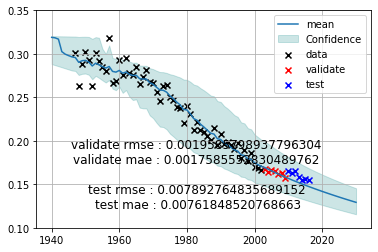

 33%|███▎      | 430/1296 [43:25<50:40,  3.51s/it]

validate rmse : 0.0019585798937796304 
 validate mae : 0.0017585552830489762 

    test rmse : 0.007892764835689152 
 test mae : 0.00761848520768663
(('sa', 2), ('box_cox', 2), ('box_cox', 2), ('box_cox', 1))


 33%|███▎      | 431/1296 [43:26<37:37,  2.61s/it]

params:[-5.55393540e-02  1.04399416e+02]
validate rmse : 0.002891489794098293 
 validate mae : 0.0023270168251817236 

    test rmse : 0.004353295512826536 
 test mae : 0.0037041986769160706
(('sa', 2), ('box_cox', 2), ('box_cox', 2), ('box_cox', 2))


 33%|███▎      | 432/1296 [43:27<29:49,  2.07s/it]

params:[-4.30017685e-02  7.89529030e+01]
validate rmse : 0.0023207908623890544 
 validate mae : 0.0017964517318459217 

    test rmse : 0.0053391927593708245 
 test mae : 0.004847596574401013
(('sal', 1), ('sa', 1), ('sa', 1), ('sa', 1))


 33%|███▎      | 433/1296 [43:29<29:38,  2.06s/it]

params:[-1.08455256e-01  2.14205215e+02]
validate rmse : 0.0038974529115126115 
 validate mae : 0.0034178689854536654 

    test rmse : 0.014861940704503631 
 test mae : 0.014740061876984059
(('sal', 1), ('sa', 1), ('sa', 1), ('sa', 2))


 33%|███▎      | 434/1296 [43:30<27:57,  1.95s/it]

params:[-1.08353171e-01  2.13988121e+02]
validate rmse : 0.003984721034358137 
 validate mae : 0.0034833004124878203 

    test rmse : 0.015113413920875188 
 test mae : 0.014991955467072196
(('sal', 1), ('sa', 1), ('sa', 1), ('sal', 1))


 34%|███▎      | 435/1296 [43:32<27:09,  1.89s/it]

params:[-1.06531061e-01  2.10218764e+02]
validate rmse : 0.004296046188257134 
 validate mae : 0.0037069735988279973 

    test rmse : 0.015992164087940307 
 test mae : 0.015869776392858807
(('sal', 1), ('sa', 1), ('sa', 1), ('sal', 2))


 34%|███▎      | 436/1296 [43:39<50:05,  3.50s/it]

params:[-1.11422366e-01  2.20359897e+02]
validate rmse : 0.003360763977327821 
 validate mae : 0.00295933778753994 

    test rmse : 0.012572409976502646 
 test mae : 0.01243376849832284
(('sal', 1), ('sa', 1), ('sa', 1), ('box_cox', 1))


 34%|███▎      | 437/1296 [43:41<40:36,  2.84s/it]

params:[-1.06172801e-01  2.08797590e+02]
validate rmse : 0.0021280146437577564 
 validate mae : 0.0017899688142910225 

    test rmse : 0.008491149948870309 
 test mae : 0.008267575809551049
(('sal', 1), ('sa', 1), ('sa', 1), ('box_cox', 2))


 34%|███▍      | 438/1296 [43:42<33:52,  2.37s/it]

params:[-1.08536740e-01  2.12304399e+02]
validate rmse : 0.002605050426031077 
 validate mae : 0.0020604033958642348 

    test rmse : 0.012276837756836117 
 test mae : 0.01211780171283905
(('sal', 1), ('sa', 1), ('sa', 2), ('sa', 1))


 34%|███▍      | 439/1296 [43:44<31:06,  2.18s/it]

params:[-1.08216641e-01  2.13680753e+02]
validate rmse : 0.004280230400383912 
 validate mae : 0.003701880314536554 

    test rmse : 0.015961916210922782 
 test mae : 0.015840383824734388
(('sal', 1), ('sa', 1), ('sa', 2), ('sa', 2))


 34%|███▍      | 440/1296 [43:45<29:41,  2.08s/it]

params:[-1.08282226e-01  2.13828924e+02]
validate rmse : 0.004129416609900788 
 validate mae : 0.0035909889863664896 

    test rmse : 0.015531265735352505 
 test mae : 0.01541003368563028
(('sal', 1), ('sa', 1), ('sa', 2), ('sal', 1))


 34%|███▍      | 441/1296 [43:49<34:29,  2.42s/it]

params:[-1.06279850e-01  2.09726611e+02]
validate rmse : 0.004020840826522079 
 validate mae : 0.003504653113695736 

    test rmse : 0.015236712929774632 
 test mae : 0.01511420461955551
(('sal', 1), ('sa', 1), ('sa', 2), ('sal', 2))


 34%|███▍      | 442/1296 [44:08<1:46:49,  7.51s/it]

params:[-1.12066239e-01  2.21221899e+02]
validate rmse : 0.003201060004198386 
 validate mae : 0.0029525989593704844 

    test rmse : 0.015456408817028987 
 test mae : 0.015295530255009801
(('sal', 1), ('sa', 1), ('sa', 2), ('box_cox', 1))


 34%|███▍      | 443/1296 [44:10<1:23:11,  5.85s/it]

params:[-1.06096811e-01  2.08629955e+02]
validate rmse : 0.0021407030180478795 
 validate mae : 0.001775958262610265 

    test rmse : 0.00848240533216566 
 test mae : 0.008261053800577567
(('sal', 1), ('sa', 1), ('sa', 2), ('box_cox', 2))


 34%|███▍      | 444/1296 [44:12<1:05:09,  4.59s/it]

params:[-1.08414419e-01  2.12064287e+02]
validate rmse : 0.002604080680935762 
 validate mae : 0.002012922200263128 

    test rmse : 0.012150016637859902 
 test mae : 0.011989744378730202
(('sal', 1), ('sa', 1), ('sal', 1), ('sa', 1))


 34%|███▍      | 445/1296 [44:14<53:48,  3.79s/it]  

params:[-1.05948666e-01  2.09075934e+02]
validate rmse : 0.004044496737465942 
 validate mae : 0.003521196154747092 

    test rmse : 0.015286208301610408 
 test mae : 0.01516388835752351
(('sal', 1), ('sa', 1), ('sal', 1), ('sa', 2))


 34%|███▍      | 446/1296 [44:15<44:18,  3.13s/it]

params:[-1.06323978e-01  2.09811347e+02]
validate rmse : 0.004395241024510393 
 validate mae : 0.0037785280915493746 

    test rmse : 0.01625716319058483 
 test mae : 0.016134509676676602
(('sal', 1), ('sa', 1), ('sal', 1), ('sal', 1))


 34%|███▍      | 447/1296 [44:17<38:49,  2.74s/it]

params:[-1.08056481e-01  2.13232548e+02]
validate rmse : 0.005254817295431143 
 validate mae : 0.0044063837531495165 

    test rmse : 0.018242387268278117 
 test mae : 0.018117770265277906
(('sal', 1), ('sa', 1), ('sal', 1), ('sal', 2))


 35%|███▍      | 448/1296 [44:26<1:05:43,  4.65s/it]

params:[-1.10622656e-01  2.18426220e+02]
validate rmse : 0.00285062893930781 
 validate mae : 0.0024768564864070175 

    test rmse : 0.014782709377725595 
 test mae : 0.014592851270524025
(('sal', 1), ('sa', 1), ('sal', 1), ('box_cox', 1))


 35%|███▍      | 449/1296 [44:29<56:06,  3.97s/it]  

params:[-1.04892388e-01  2.06044294e+02]
validate rmse : 0.0025711567790142496 
 validate mae : 0.002305561180720137 

    test rmse : 0.011400896590645297 
 test mae : 0.01124913763877336
(('sal', 1), ('sa', 1), ('sal', 1), ('box_cox', 2))


 35%|███▍      | 450/1296 [44:30<46:32,  3.30s/it]

params:[-1.04558385e-01  2.04315589e+02]
validate rmse : 0.0026865595600994207 
 validate mae : 0.0023343212931565627 

    test rmse : 0.01289965303540068 
 test mae : 0.012748284758212781
(('sal', 1), ('sa', 1), ('sal', 2), ('sa', 1))


 35%|███▍      | 451/1296 [44:53<2:09:02,  9.16s/it]

params:[-1.08350857e-01  2.13880351e+02]
validate rmse : 0.006023721987972415 
 validate mae : 0.005126936980640547 

    test rmse : 0.02494481665803501 
 test mae : 0.02458416220788643
(('sal', 1), ('sa', 1), ('sal', 2), ('sa', 2))


 35%|███▍      | 452/1296 [45:02<2:06:51,  9.02s/it]

params:[-1.10603085e-01  2.18388691e+02]
validate rmse : 0.0028508666861484936 
 validate mae : 0.0024623643415532686 

    test rmse : 0.01483315187920748 
 test mae : 0.01463913359743728
(('sal', 1), ('sa', 1), ('sal', 2), ('sal', 1))
params:[-1.10331523e-01  2.17850894e+02]


 35%|███▍      | 453/1296 [45:12<2:10:15,  9.27s/it]

validate rmse : 0.0028129630256625337 
 validate mae : 0.002376306254730509 

    test rmse : 0.014551383685223896 
 test mae : 0.014357872354564807
(('sal', 1), ('sa', 1), ('sal', 2), ('sal', 2))
params:[-4.40314167e+03  8.73870949e+06]


 35%|███▌      | 454/1296 [45:17<1:52:25,  8.01s/it]

validate rmse : 0.006074754898643739 
 validate mae : 0.0058066536937487635 

    test rmse : 0.009627631985288258 
 test mae : 0.00922737114971641
(('sal', 1), ('sa', 1), ('sal', 2), ('box_cox', 1))


 35%|███▌      | 455/1296 [45:22<1:41:16,  7.23s/it]

params:[-1.01297816e-01  1.99315193e+02]
validate rmse : 0.002832487988287344 
 validate mae : 0.0022644223545478953 

    test rmse : 0.0043147850774147255 
 test mae : 0.003602652190956318
(('sal', 1), ('sa', 1), ('sal', 2), ('box_cox', 2))


 35%|███▌      | 456/1296 [45:34<1:58:39,  8.48s/it]

params:[-1.07259609e-01  2.09643246e+02]
validate rmse : 0.003664544975356253 
 validate mae : 0.003343032638732935 

    test rmse : 0.016050454067952278 
 test mae : 0.015905292753569885
(('sal', 1), ('sa', 1), ('box_cox', 1), ('sa', 1))


 35%|███▌      | 457/1296 [45:35<1:29:29,  6.40s/it]

params:[-9.73947107e-02  1.91815457e+02]
validate rmse : 0.002585480550968844 
 validate mae : 0.0019150725922387518 

    test rmse : 0.011537994632614871 
 test mae : 0.01137663542677941
(('sal', 1), ('sa', 1), ('box_cox', 1), ('sa', 2))


 35%|███▌      | 458/1296 [45:37<1:09:22,  4.97s/it]

params:[-9.62795281e-02  1.89560614e+02]
validate rmse : 0.0026067664149182043 
 validate mae : 0.0019138351865037953 

    test rmse : 0.011641867024944576 
 test mae : 0.0114792700976266
(('sal', 1), ('sa', 1), ('box_cox', 1), ('sal', 1))


 35%|███▌      | 459/1296 [45:38<55:19,  3.97s/it]  

params:[-1.13744322e-01  2.24532464e+02]
validate rmse : 0.008108679275569198 
 validate mae : 0.007070536942596398 

    test rmse : 0.025576752066650808 
 test mae : 0.02538455328135744
(('sal', 1), ('sa', 1), ('box_cox', 1), ('sal', 2))


 35%|███▌      | 460/1296 [45:43<56:27,  4.05s/it]

params:[-7.79877831e+05  1.52958115e+09]
validate rmse : 0.012063618992243917 
 validate mae : 0.01105597818268908 

    test rmse : 0.019105728551636315 
 test mae : 0.018644638600637586
(('sal', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 1))


 36%|███▌      | 461/1296 [45:44<44:50,  3.22s/it]

params:[-1.07785340e-01  2.10770252e+02]
validate rmse : 0.0049251605958056666 
 validate mae : 0.004135797377385481 

    test rmse : 0.017612069547778633 
 test mae : 0.017483640949720748
(('sal', 1), ('sa', 1), ('box_cox', 1), ('box_cox', 2))


 36%|███▌      | 462/1296 [45:45<36:58,  2.66s/it]

params:[-1.01213880e-01  1.96706935e+02]
validate rmse : 0.008291569379413059 
 validate mae : 0.00742894159163577 

    test rmse : 0.024696967657527588 
 test mae : 0.024533122888130622
(('sal', 1), ('sa', 1), ('box_cox', 2), ('sa', 1))


 36%|███▌      | 463/1296 [45:47<32:07,  2.31s/it]

params:[-8.93794138e-02  1.75246320e+02]
validate rmse : 0.005176966106751102 
 validate mae : 0.00435481508211089 

    test rmse : 0.018279220370853323 
 test mae : 0.01814883816264017
(('sal', 1), ('sa', 1), ('box_cox', 2), ('sa', 2))


 36%|███▌      | 464/1296 [45:49<29:48,  2.15s/it]

params:[-9.03865856e-02  1.77217134e+02]
validate rmse : 0.006540841322634686 
 validate mae : 0.0057154282852648385 

    test rmse : 0.02059490697286331 
 test mae : 0.020464074797920707
(('sal', 1), ('sa', 1), ('box_cox', 2), ('sal', 1))


 36%|███▌      | 465/1296 [45:50<27:19,  1.97s/it]

params:[-1.13486510e-01  2.24051272e+02]
validate rmse : 0.005937761523309947 
 validate mae : 0.004990186469815856 

    test rmse : 0.019832818918559092 
 test mae : 0.01969641462622368
(('sal', 1), ('sa', 1), ('box_cox', 2), ('sal', 2))


 36%|███▌      | 466/1296 [46:07<1:30:39,  6.55s/it]

params:[-1.10331166e-01  2.17806367e+02]
validate rmse : 0.0031829193040824625 
 validate mae : 0.0027725373922255375 

    test rmse : 0.01230589068056785 
 test mae : 0.012165220143998253
(('sal', 1), ('sa', 1), ('box_cox', 2), ('box_cox', 1))


 36%|███▌      | 467/1296 [46:09<1:09:04,  5.00s/it]

params:[-1.02124762e-01  1.98478773e+02]
validate rmse : 0.008794702665568028 
 validate mae : 0.008020103859636344 

    test rmse : 0.02490584610280307 
 test mae : 0.024754050964632252
(('sal', 1), ('sa', 1), ('box_cox', 2), ('box_cox', 2))


 36%|███▌      | 468/1296 [46:11<56:23,  4.09s/it]  

params:[-8.88592212e-02  1.71301860e+02]
validate rmse : 0.012055352573563164 
 validate mae : 0.011355725648537679 

    test rmse : 0.030062356565350012 
 test mae : 0.029895309641691847
(('sal', 1), ('sa', 2), ('sa', 1), ('sa', 1))


 36%|███▌      | 469/1296 [46:12<46:46,  3.39s/it]

params:[-1.08206533e-01  2.13658405e+02]
validate rmse : 0.004298508940240546 
 validate mae : 0.003715170981633431 

    test rmse : 0.01601248899135051 
 test mae : 0.015890902874379942
(('sal', 1), ('sa', 2), ('sa', 1), ('sa', 2))


 36%|███▋      | 470/1296 [46:14<37:57,  2.76s/it]

params:[-1.08189530e-01  2.13629804e+02]
validate rmse : 0.004236441390877212 
 validate mae : 0.003669696093583514 

    test rmse : 0.015836597479080897 
 test mae : 0.015715200408125712
(('sal', 1), ('sa', 2), ('sa', 1), ('sal', 1))


 36%|███▋      | 471/1296 [46:15<32:50,  2.39s/it]

params:[-1.06586634e-01  2.10327553e+02]
validate rmse : 0.004362324829072691 
 validate mae : 0.0037553430656636195 

    test rmse : 0.01617765557739245 
 test mae : 0.016055006458795533
(('sal', 1), ('sa', 2), ('sa', 1), ('sal', 2))


 36%|███▋      | 472/1296 [46:22<49:24,  3.60s/it]

params:[-2.32095334e+02  4.54725822e+05]
validate rmse : 0.004078237230997818 
 validate mae : 0.0036112273343250584 

    test rmse : 0.0024191691549851316 
 test mae : 0.0020156041555276943
(('sal', 1), ('sa', 2), ('sa', 1), ('box_cox', 1))


 36%|███▋      | 473/1296 [46:24<45:26,  3.31s/it]

params:[-1.06513626e-01  2.09476419e+02]
validate rmse : 0.0021456616740120633 
 validate mae : 0.0018434741323713477 

    test rmse : 0.008958242523435573 
 test mae : 0.008750603227035561
(('sal', 1), ('sa', 2), ('sa', 1), ('box_cox', 2))


 37%|███▋      | 474/1296 [46:26<39:55,  2.91s/it]

params:[-1.09926246e-01  2.15045359e+02]
validate rmse : 0.00281035162363721 
 validate mae : 0.0025396149711237365 

    test rmse : 0.013657324258113996 
 test mae : 0.013507818110381348
(('sal', 1), ('sa', 2), ('sa', 2), ('sa', 1))


 37%|███▋      | 475/1296 [46:28<34:40,  2.53s/it]

params:[-1.08291803e-01  2.13857500e+02]
validate rmse : 0.00404343811043802 
 validate mae : 0.0035272457226215464 

    test rmse : 0.015285809403648393 
 test mae : 0.015164486569404454
(('sal', 1), ('sa', 2), ('sa', 2), ('sa', 2))


 37%|███▋      | 476/1296 [46:30<34:08,  2.50s/it]

params:[-1.08391804e-01  2.14070409e+02]
validate rmse : 0.003951029060578865 
 validate mae : 0.0034581588968400395 

    test rmse : 0.015017621901410507 
 test mae : 0.014896018688023862
(('sal', 1), ('sa', 2), ('sa', 2), ('sal', 1))


 37%|███▋      | 477/1296 [46:33<33:00,  2.42s/it]

params:[-1.06511609e-01  2.10180551e+02]
validate rmse : 0.004278315693067884 
 validate mae : 0.0036941994517100197 

    test rmse : 0.015946931796711795 
 test mae : 0.01582453478632421
(('sal', 1), ('sa', 2), ('sa', 2), ('sal', 2))


 37%|███▋      | 478/1296 [46:55<1:53:16,  8.31s/it]

params:[-1.08825219e-01  2.14834830e+02]
validate rmse : 0.00632704034883561 
 validate mae : 0.005352482067100138 

    test rmse : 0.026081574877296846 
 test mae : 0.02568581168257446
(('sal', 1), ('sa', 2), ('sa', 2), ('box_cox', 1))


 37%|███▋      | 479/1296 [46:57<1:29:16,  6.56s/it]

params:[-1.06100002e-01  2.08637604e+02]
validate rmse : 0.0021399039924210523 
 validate mae : 0.0017747886975264646 

    test rmse : 0.008463301911266449 
 test mae : 0.008241075793667582
(('sal', 1), ('sa', 2), ('sa', 2), ('box_cox', 2))


 37%|███▋      | 480/1296 [46:59<1:10:47,  5.21s/it]

params:[-1.08686420e-01  2.12632077e+02]
validate rmse : 0.0025710303192979654 
 validate mae : 0.0018945799088491183 

    test rmse : 0.011668694065755584 
 test mae : 0.011506243882229372
(('sal', 1), ('sa', 2), ('sal', 1), ('sa', 1))


 37%|███▋      | 481/1296 [47:01<57:15,  4.22s/it]  

params:[-1.05907258e-01  2.08994916e+02]
validate rmse : 0.004004000391461367 
 validate mae : 0.003491047144862484 

    test rmse : 0.015173285617512303 
 test mae : 0.015050835658112192
(('sal', 1), ('sa', 2), ('sal', 1), ('sa', 2))


 37%|███▋      | 482/1296 [47:03<48:46,  3.60s/it]

params:[-1.06235031e-01  2.09636984e+02]
validate rmse : 0.004313403938165564 
 validate mae : 0.0037192131645402255 

    test rmse : 0.016035794567941086 
 test mae : 0.015913377042305558
(('sal', 1), ('sa', 2), ('sal', 1), ('sal', 1))


 37%|███▋      | 483/1296 [47:05<42:07,  3.11s/it]

params:[-1.08051938e-01  2.13221963e+02]
validate rmse : 0.00531476754222897 
 validate mae : 0.004455795786196247 

    test rmse : 0.01843233016567416 
 test mae : 0.018306297218290402
(('sal', 1), ('sa', 2), ('sal', 1), ('sal', 2))
params:[-6.17614286e+05  1.22787165e+09]


 37%|███▋      | 484/1296 [47:14<1:05:17,  4.82s/it]

validate rmse : 0.61768063938571 
 validate mae : 0.6175150084361635 

    test rmse : 0.6651252749224723 
 test mae : 0.6650621252429552
(('sal', 1), ('sa', 2), ('sal', 1), ('box_cox', 1))


 37%|███▋      | 485/1296 [47:16<52:44,  3.90s/it]  

params:[-1.05167780e-01  2.06584318e+02]
validate rmse : 0.002750493527537714 
 validate mae : 0.0024915825969330824 

    test rmse : 0.012079829064456746 
 test mae : 0.011936262176195327
(('sal', 1), ('sa', 2), ('sal', 1), ('box_cox', 2))


 38%|███▊      | 486/1296 [47:18<46:27,  3.44s/it]

params:[-1.04713648e-01  2.04619503e+02]
validate rmse : 0.002780546253447162 
 validate mae : 0.0024780307982660565 

    test rmse : 0.01342205038055251 
 test mae : 0.013271017842574605
(('sal', 1), ('sa', 2), ('sal', 2), ('sa', 1))


 38%|███▊      | 487/1296 [47:25<1:00:46,  4.51s/it]

params:[-1.21380867e-01  2.39475305e+02]
validate rmse : 0.017041348934998802 
 validate mae : 0.015524942893362623 

    test rmse : 0.047994200920972604 
 test mae : 0.0474636288352504
(('sal', 1), ('sa', 2), ('sal', 2), ('sa', 2))


 38%|███▊      | 488/1296 [47:32<1:10:13,  5.21s/it]

params:[-1.08606786e-01  2.14404181e+02]
validate rmse : 0.006240023250181302 
 validate mae : 0.005287855043022459 

    test rmse : 0.025739282207374654 
 test mae : 0.02535486789537688
(('sal', 1), ('sa', 2), ('sal', 2), ('sal', 1))


 38%|███▊      | 489/1296 [47:44<1:36:17,  7.16s/it]

params:[-1.10326788e-01  2.17841658e+02]
validate rmse : 0.002809819106139735 
 validate mae : 0.0023706796581585738 

    test rmse : 0.014529474793837463 
 test mae : 0.014336105401452482
(('sal', 1), ('sa', 2), ('sal', 2), ('sal', 2))


 38%|███▊      | 490/1296 [47:50<1:33:25,  6.95s/it]

params:[-1.09027034e+01  2.13960065e+04]
validate rmse : 0.002851847874523924 
 validate mae : 0.0024943091716127202 

    test rmse : 0.0058554106244846455 
 test mae : 0.005442371905932366
(('sal', 1), ('sa', 2), ('sal', 2), ('box_cox', 1))


 38%|███▊      | 491/1296 [47:58<1:36:53,  7.22s/it]

params:[-1.05502417e-01  2.07417859e+02]
validate rmse : 0.0024406844740729903 
 validate mae : 0.0018774142010483624 

    test rmse : 0.008080827768987409 
 test mae : 0.00786081244398848
(('sal', 1), ('sa', 2), ('sal', 2), ('box_cox', 2))


 38%|███▊      | 492/1296 [48:06<1:41:44,  7.59s/it]

params:[-1.07524978e-01  2.10297959e+02]
validate rmse : 0.003715390390524456 
 validate mae : 0.0031321711381899924 

    test rmse : 0.021309201440743327 
 test mae : 0.020819939088653847
(('sal', 1), ('sa', 2), ('box_cox', 1), ('sa', 1))


 38%|███▊      | 493/1296 [48:08<1:16:49,  5.74s/it]

params:[-9.62800767e-02  1.89561773e+02]
validate rmse : 0.0026066680207033604 
 validate mae : 0.0019135796703703331 

    test rmse : 0.011638982217737645 
 test mae : 0.01147637565121001
(('sal', 1), ('sa', 2), ('box_cox', 1), ('sa', 2))


 38%|███▊      | 494/1296 [48:11<1:04:26,  4.82s/it]

params:[-9.72579016e-02  1.91541815e+02]
validate rmse : 0.002588699622018621 
 validate mae : 0.0019052756262642626 

    test rmse : 0.011462808128675887 
 test mae : 0.011300644800901606
(('sal', 1), ('sa', 2), ('box_cox', 1), ('sal', 1))


 38%|███▊      | 495/1296 [48:13<53:39,  4.02s/it]  

params:[-1.13453474e-01  2.23955567e+02]
validate rmse : 0.0078666192909391 
 validate mae : 0.006843077341711147 

    test rmse : 0.024832185123069464 
 test mae : 0.02465238448552363
(('sal', 1), ('sa', 2), ('box_cox', 1), ('sal', 2))
params:[-8.36966351e+10  1.64401788e+14]


 38%|███▊      | 496/1296 [48:20<1:05:17,  4.90s/it]

validate rmse : 0.012844346600487432 
 validate mae : 0.01166789168486406 

    test rmse : 0.01802471377717766 
 test mae : 0.017544083227269296
(('sal', 1), ('sa', 2), ('box_cox', 1), ('box_cox', 1))


 38%|███▊      | 497/1296 [48:22<54:04,  4.06s/it]  

params:[-1.08112964e-01  2.11432463e+02]
validate rmse : 0.004928468163573912 
 validate mae : 0.004136081361694537 

    test rmse : 0.017517424124052695 
 test mae : 0.017390906708185376
(('sal', 1), ('sa', 2), ('box_cox', 1), ('box_cox', 2))


 38%|███▊      | 498/1296 [48:23<44:10,  3.32s/it]

params:[-1.02527891e-01  1.99257334e+02]
validate rmse : 0.011702273953477973 
 validate mae : 0.010917886990924105 

    test rmse : 0.03041049580909412 
 test mae : 0.030222783994249762
(('sal', 1), ('sa', 2), ('box_cox', 2), ('sa', 1))


 39%|███▊      | 499/1296 [48:25<37:12,  2.80s/it]

params:[-9.00640026e-02  1.76645708e+02]
validate rmse : 0.004917293892520484 
 validate mae : 0.0041366190901489085 

    test rmse : 0.01761463995762662 
 test mae : 0.017487809394643016
(('sal', 1), ('sa', 2), ('box_cox', 2), ('sa', 2))


 39%|███▊      | 500/1296 [48:26<31:46,  2.40s/it]

params:[-8.92662461e-02  1.75021596e+02]
validate rmse : 0.005101807174996414 
 validate mae : 0.0042900086521817605 

    test rmse : 0.018164853023585517 
 test mae : 0.018034081826496722
(('sal', 1), ('sa', 2), ('box_cox', 2), ('sal', 1))


 39%|███▊      | 501/1296 [48:28<29:24,  2.22s/it]

params:[-1.13589469e-01  2.24253935e+02]
validate rmse : 0.006018622202089396 
 validate mae : 0.005078669699647658 

    test rmse : 0.019926158124265153 
 test mae : 0.019791127004739034
(('sal', 1), ('sa', 2), ('box_cox', 2), ('sal', 2))


 39%|███▊      | 502/1296 [48:36<50:49,  3.84s/it]

params:[-1.10626983e-01  2.18436439e+02]
validate rmse : 0.002475919312003112 
 validate mae : 0.001995028244890653 

    test rmse : 0.011684107277009801 
 test mae : 0.01152899545227152
(('sal', 1), ('sa', 2), ('box_cox', 2), ('box_cox', 1))


 39%|███▉      | 503/1296 [48:38<42:42,  3.23s/it]

params:[-1.03164585e-01  2.00604142e+02]
validate rmse : 0.007650163851548711 
 validate mae : 0.006838662491901353 

    test rmse : 0.022874306668015827 
 test mae : 0.022731692676628147
(('sal', 1), ('sa', 2), ('box_cox', 2), ('box_cox', 2))


 39%|███▉      | 504/1296 [48:40<37:39,  2.85s/it]

params:[-8.90583348e-02  1.71711460e+02]
validate rmse : 0.011863831845294966 
 validate mae : 0.011158660937604172 

    test rmse : 0.029776233701431048 
 test mae : 0.029610211744045677
(('sal', 1), ('sal', 1), ('sa', 1), ('sa', 1))


 39%|███▉      | 505/1296 [48:41<33:47,  2.56s/it]

params:[-1.06197387e-01  2.09563205e+02]
validate rmse : 0.004274503323860193 
 validate mae : 0.003690553474586074 

    test rmse : 0.01592288354680336 
 test mae : 0.01580063939824399
(('sal', 1), ('sal', 1), ('sa', 1), ('sa', 2))


 39%|███▉      | 506/1296 [48:44<33:24,  2.54s/it]

params:[-1.06333508e-01  2.09829453e+02]
validate rmse : 0.004420053593256616 
 validate mae : 0.003796846406884713 

    test rmse : 0.016331505834693626 
 test mae : 0.016208652852110348
(('sal', 1), ('sal', 1), ('sa', 1), ('sal', 1))


 39%|███▉      | 507/1296 [48:45<29:07,  2.21s/it]

params:[-1.08022857e-01  2.13161894e+02]
validate rmse : 0.005377533399789732 
 validate mae : 0.004507602978029284 

    test rmse : 0.018614666932272712 
 test mae : 0.018487495815223322
(('sal', 1), ('sal', 1), ('sa', 1), ('sal', 2))


 39%|███▉      | 508/1296 [48:53<49:29,  3.77s/it]

params:[-1.05337206e-01  2.07910223e+02]
validate rmse : 0.0045639670837607565 
 validate mae : 0.0038941061863074617 

    test rmse : 0.016574868410925165 
 test mae : 0.01645335611169562
(('sal', 1), ('sal', 1), ('sa', 1), ('box_cox', 1))


 39%|███▉      | 509/1296 [48:55<41:44,  3.18s/it]

params:[-1.04329651e-01  2.04942120e+02]
validate rmse : 0.0024550054255407304 
 validate mae : 0.002170945088561344 

    test rmse : 0.010943948504879357 
 test mae : 0.010785264258720772
(('sal', 1), ('sal', 1), ('sa', 1), ('box_cox', 2))


 39%|███▉      | 510/1296 [48:56<35:20,  2.70s/it]

params:[-1.04743185e-01  2.04679439e+02]
validate rmse : 0.002928445162997515 
 validate mae : 0.00266804844025309 

    test rmse : 0.01412598941961119 
 test mae : 0.01397394010976498
(('sal', 1), ('sal', 1), ('sa', 2), ('sa', 1))


 39%|███▉      | 511/1296 [48:58<31:22,  2.40s/it]

params:[-1.06077804e-01  2.09329059e+02]
validate rmse : 0.0041600284815534495 
 validate mae : 0.0036064961468173823 

    test rmse : 0.015604080781711358 
 test mae : 0.01548196882573464
(('sal', 1), ('sal', 1), ('sa', 2), ('sa', 2))


 40%|███▉      | 512/1296 [49:00<31:14,  2.39s/it]

params:[-1.05983733e-01  2.09144705e+02]
validate rmse : 0.004073685130797841 
 validate mae : 0.003542766258588102 

    test rmse : 0.015365838427336624 
 test mae : 0.015243604334349129
(('sal', 1), ('sal', 1), ('sa', 2), ('sal', 1))


 40%|███▉      | 513/1296 [49:03<32:12,  2.47s/it]

params:[-1.08074932e-01  2.13273128e+02]
validate rmse : 0.005141767007807174 
 validate mae : 0.004312873651378565 

    test rmse : 0.01789151514564438 
 test mae : 0.017769165893764472
(('sal', 1), ('sal', 1), ('sa', 2), ('sal', 2))


 40%|███▉      | 514/1296 [49:40<2:46:07, 12.75s/it]

params:[-1.09215851e-01  2.15396845e+02]
validate rmse : 0.007513120353913008 
 validate mae : 0.00652069066031077 

    test rmse : 0.023702290260660775 
 test mae : 0.023540194715782052
(('sal', 1), ('sal', 1), ('sa', 2), ('box_cox', 1))


 40%|███▉      | 515/1296 [49:41<2:02:17,  9.40s/it]

params:[-1.04877811e-01  2.06016951e+02]
validate rmse : 0.0027292728471699948 
 validate mae : 0.0024711869261522168 

    test rmse : 0.012027228694131276 
 test mae : 0.011883040395858361
(('sal', 1), ('sal', 1), ('sa', 2), ('box_cox', 2))


 40%|███▉      | 516/1296 [49:43<1:31:04,  7.01s/it]

params:[-1.04704610e-01  2.04603732e+02]
validate rmse : 0.002909202980494772 
 validate mae : 0.00264406017036655 

    test rmse : 0.014048914524300755 
 test mae : 0.013896779016270138
(('sal', 1), ('sal', 1), ('sal', 1), ('sa', 1))


 40%|███▉      | 517/1296 [49:44<1:10:54,  5.46s/it]

params:[-1.08084702e-01  2.13291334e+02]
validate rmse : 0.005261562389143033 
 validate mae : 0.004412200450590383 

    test rmse : 0.018251020202302095 
 test mae : 0.018126457889810575
(('sal', 1), ('sal', 1), ('sal', 1), ('sa', 2))


 40%|███▉      | 518/1296 [49:46<56:58,  4.39s/it]  

params:[-1.08072169e-01  2.13263828e+02]
validate rmse : 0.005348252594766473 
 validate mae : 0.004483607499798029 

    test rmse : 0.018524566361919428 
 test mae : 0.018397964401726984
(('sal', 1), ('sal', 1), ('sal', 1), ('sal', 1))


 40%|████      | 519/1296 [49:48<46:18,  3.58s/it]

params:[-1.07599248e-01  2.12326811e+02]
validate rmse : 0.004745259410275172 
 validate mae : 0.004001660921034695 

    test rmse : 0.0167326630136682 
 test mae : 0.016614594735757982
(('sal', 1), ('sal', 1), ('sal', 1), ('sal', 2))


 40%|████      | 520/1296 [49:58<1:11:12,  5.51s/it]

params:[-1.10621715e-01  2.18424620e+02]
validate rmse : 0.002814810388169118 
 validate mae : 0.0024356295359500213 

    test rmse : 0.014496964267592904 
 test mae : 0.014313239382466068
(('sal', 1), ('sal', 1), ('sal', 1), ('box_cox', 1))


 40%|████      | 521/1296 [50:00<57:52,  4.48s/it]  

params:[-1.06668154e-01  2.09558549e+02]
validate rmse : 0.0031858829456569595 
 validate mae : 0.002872273446911342 

    test rmse : 0.013230470840534898 
 test mae : 0.013097658737880094
(('sal', 1), ('sal', 1), ('sal', 1), ('box_cox', 2))


 40%|████      | 522/1296 [50:02<49:26,  3.83s/it]

params:[-1.06811404e-01  2.08745735e+02]
validate rmse : 0.004137360573086328 
 validate mae : 0.003719305689058907 

    test rmse : 0.017332562615233818 
 test mae : 0.01718238254230924
(('sal', 1), ('sal', 1), ('sal', 2), ('sa', 1))
params:[-1.27806785e-01  2.52170547e+02]


 40%|████      | 523/1296 [50:08<57:27,  4.46s/it]

validate rmse : 0.021268328496208123 
 validate mae : 0.020211745734398007 

    test rmse : 0.0496124332082889 
 test mae : 0.049228236719900474
(('sal', 1), ('sal', 1), ('sal', 2), ('sa', 2))


 40%|████      | 524/1296 [50:18<1:17:54,  6.06s/it]

params:[-1.05041790e-01  2.07218024e+02]
validate rmse : 0.00400176781246186 
 validate mae : 0.003479563268501137 

    test rmse : 0.015094017306752767 
 test mae : 0.014971031742823743
(('sal', 1), ('sal', 1), ('sal', 2), ('sal', 1))


 41%|████      | 525/1296 [50:26<1:22:52,  6.45s/it]

params:[-1.07890807e-01  2.12926321e+02]
validate rmse : 0.004829007483957515 
 validate mae : 0.004076749301500946 

    test rmse : 0.017184120842745083 
 test mae : 0.017062461043183885
(('sal', 1), ('sal', 1), ('sal', 2), ('sal', 2))


 41%|████      | 526/1296 [50:33<1:25:44,  6.68s/it]

params:[-1.09480598e-01  2.16178953e+02]
validate rmse : 0.0023211113031326946 
 validate mae : 0.0017930454703380236 

    test rmse : 0.0073774303232261446 
 test mae : 0.0071155025183875
(('sal', 1), ('sal', 1), ('sal', 2), ('box_cox', 1))


 41%|████      | 527/1296 [50:48<1:59:12,  9.30s/it]

params:[-1.06891876e-01  2.10063154e+02]
validate rmse : 0.0027947362214836725 
 validate mae : 0.00252671037921209 

    test rmse : 0.01199660157303257 
 test mae : 0.011852376371090764
(('sal', 1), ('sal', 1), ('sal', 2), ('box_cox', 2))


 41%|████      | 528/1296 [50:57<1:56:30,  9.10s/it]

params:[ 2.22610000e-02 -4.08969872e+01]
validate rmse : 0.07749317309708267 
 validate mae : 0.077193878066351 

    test rmse : 0.08886231922951147 
 test mae : 0.08866550119409766
(('sal', 1), ('sal', 1), ('box_cox', 1), ('sa', 1))


 41%|████      | 529/1296 [50:59<1:28:02,  6.89s/it]

params:[-9.65023396e-02  1.89848747e+02]
validate rmse : 0.003586225674722581 
 validate mae : 0.0032880529373106038 

    test rmse : 0.015767254978477422 
 test mae : 0.015624298945005773
(('sal', 1), ('sal', 1), ('box_cox', 1), ('sa', 2))


 41%|████      | 530/1296 [51:01<1:09:55,  5.48s/it]

params:[-9.62861274e-02  1.89425015e+02]
validate rmse : 0.0033404256418073566 
 validate mae : 0.003080643612918004 

    test rmse : 0.01502804592129161 
 test mae : 0.014886926358431557
(('sal', 1), ('sal', 1), ('box_cox', 1), ('sal', 1))


 41%|████      | 531/1296 [51:03<55:48,  4.38s/it]  

params:[-1.14963124e-01  2.26932398e+02]
validate rmse : 0.009011834895426132 
 validate mae : 0.007965135523408837 

    test rmse : 0.027440915322701667 
 test mae : 0.02723654815581821
(('sal', 1), ('sal', 1), ('box_cox', 1), ('sal', 2))


 41%|████      | 532/1296 [51:29<2:21:54, 11.14s/it]

params:[-1.09366681e-01  2.15895723e+02]
validate rmse : 0.003431637316230757 
 validate mae : 0.0029588814555316684 

    test rmse : 0.012644184333518467 
 test mae : 0.0125069825044651
(('sal', 1), ('sal', 1), ('box_cox', 1), ('box_cox', 1))
params:[-1.05281801e-01  2.05704018e+02]


 41%|████      | 533/1296 [51:32<1:47:02,  8.42s/it]

validate rmse : 0.004084773179607581 
 validate mae : 0.0036587514699478857 

    test rmse : 0.017118289475811788 
 test mae : 0.016971594526065246
(('sal', 1), ('sal', 1), ('box_cox', 1), ('box_cox', 2))


 41%|████      | 534/1296 [51:35<1:27:29,  6.89s/it]

params:[-9.82052326e-02  1.90629396e+02]
validate rmse : 0.008852484221479082 
 validate mae : 0.008025247337214766 

    test rmse : 0.02538949643222084 
 test mae : 0.0252304094906472
(('sal', 1), ('sal', 1), ('box_cox', 2), ('sa', 1))


 41%|████▏     | 535/1296 [51:37<1:07:34,  5.33s/it]

params:[-8.71608823e-02  1.70763462e+02]
validate rmse : 0.004994196880983292 
 validate mae : 0.004199509789044593 

    test rmse : 0.01779060161031264 
 test mae : 0.017663724697668155
(('sal', 1), ('sal', 1), ('box_cox', 2), ('sa', 2))


 41%|████▏     | 536/1296 [51:38<54:21,  4.29s/it]  

params:[-8.73964745e-02  1.71224604e+02]
validate rmse : 0.0054631352777308505 
 validate mae : 0.004591973651525012 

    test rmse : 0.018884850923655418 
 test mae : 0.01875341818339307
(('sal', 1), ('sal', 1), ('box_cox', 2), ('sal', 1))


 41%|████▏     | 537/1296 [51:41<46:30,  3.68s/it]

params:[-1.13542842e-01  2.24171469e+02]
validate rmse : 0.00567386604411455 
 validate mae : 0.004759621828297831 

    test rmse : 0.019241283699414177 
 test mae : 0.01910902363610567
(('sal', 1), ('sal', 1), ('box_cox', 2), ('sal', 2))


 42%|████▏     | 538/1296 [51:54<1:21:50,  6.48s/it]

params:[-2.13658512e+04  4.19033955e+07]
validate rmse : 0.011135053435286531 
 validate mae : 0.01015714725686122 

    test rmse : 0.01852244787787537 
 test mae : 0.017978810015329815
(('sal', 1), ('sal', 1), ('box_cox', 2), ('box_cox', 1))


 42%|████▏     | 539/1296 [51:56<1:04:26,  5.11s/it]

params:[-9.82465797e-02  1.90708366e+02]
validate rmse : 0.008600570739621094 
 validate mae : 0.007795278235049655 

    test rmse : 0.0247547855656682 
 test mae : 0.02460098975885311
(('sal', 1), ('sal', 1), ('box_cox', 2), ('box_cox', 2))


 42%|████▏     | 540/1296 [51:57<50:30,  4.01s/it]  

params:[-8.53750258e-02  1.64270177e+02]
validate rmse : 0.0124932342167651 
 validate mae : 0.011752301667845863 

    test rmse : 0.03136027466773401 
 test mae : 0.03117462102179615
(('sal', 1), ('sal', 2), ('sa', 1), ('sa', 1))


 42%|████▏     | 541/1296 [52:01<51:53,  4.12s/it]

params:[-1.08824848e-01  2.14061238e+02]
validate rmse : 0.014926562624470202 
 validate mae : 0.014006085102699887 

    test rmse : 0.038263226597033566 
 test mae : 0.037958907109313926
(('sal', 1), ('sal', 2), ('sa', 1), ('sa', 2))


 42%|████▏     | 542/1296 [52:08<1:01:33,  4.90s/it]

params:[-1.18407359e-01  2.33509217e+02]
validate rmse : 0.012628868340410625 
 validate mae : 0.011537705933439918 

    test rmse : 0.034948884273261795 
 test mae : 0.03467210314861207
(('sal', 1), ('sal', 2), ('sa', 1), ('sal', 1))


 42%|████▏     | 543/1296 [52:22<1:35:19,  7.60s/it]

params:[-1.10323811e-01  2.17835144e+02]
validate rmse : 0.0028155670213398827 
 validate mae : 0.0023814643948859094 

    test rmse : 0.014567789470364705 
 test mae : 0.014374285756957598
(('sal', 1), ('sal', 2), ('sa', 1), ('sal', 2))
params:[-8.25433939e+06  1.64105179e+10]


 42%|████▏     | 544/1296 [52:34<1:51:55,  8.93s/it]

validate rmse : 0.9523076381929066 
 validate mae : 0.9500548933544809 

    test rmse : 1.1802562534584815 
 test mae : 1.178670111644206
(('sal', 1), ('sal', 2), ('sa', 1), ('box_cox', 1))


 42%|████▏     | 545/1296 [52:42<1:48:46,  8.69s/it]

params:[-1.02634779e-01  2.01549224e+02]
validate rmse : 0.0021608017740886148 
 validate mae : 0.0018403637217041882 

    test rmse : 0.00919829533363053 
 test mae : 0.009002823518080223
(('sal', 1), ('sal', 2), ('sa', 1), ('box_cox', 2))


 42%|████▏     | 546/1296 [52:57<2:10:53, 10.47s/it]

params:[-1.08429183e-01  2.11940268e+02]
validate rmse : 0.0050098197057010015 
 validate mae : 0.004347991439663567 

    test rmse : 0.019477881017777924 
 test mae : 0.01931664045243181
(('sal', 1), ('sal', 2), ('sa', 2), ('sa', 1))


 42%|████▏     | 547/1296 [53:02<1:50:44,  8.87s/it]

params:[-1.06581649e-01  2.10346327e+02]
validate rmse : 0.003788030637336905 
 validate mae : 0.00330530960026641 

    test rmse : 0.01423499676871584 
 test mae : 0.014110933098082923
(('sal', 1), ('sal', 2), ('sa', 2), ('sa', 2))


 42%|████▏     | 548/1296 [53:13<1:58:22,  9.50s/it]

params:[-1.10263662e-01  2.17775225e+02]
validate rmse : 0.003008981048777617 
 validate mae : 0.0026805397656274954 

    test rmse : 0.012240090747246312 
 test mae : 0.01209807941341
(('sal', 1), ('sal', 2), ('sa', 2), ('sal', 1))


 42%|████▏     | 549/1296 [53:20<1:48:50,  8.74s/it]

params:[-1.06784606e-01  2.10683514e+02]
validate rmse : 0.005187214220361082 
 validate mae : 0.00434541543060712 

    test rmse : 0.018433734201878337 
 test mae : 0.018301241448256445
(('sal', 1), ('sal', 2), ('sa', 2), ('sal', 2))
params:[-7.8165355e+05  1.5356856e+09]


 42%|████▏     | 550/1296 [53:33<2:04:27, 10.01s/it]

validate rmse : 0.013349246653920357 
 validate mae : 0.012161239075710099 

    test rmse : 0.01858711528997187 
 test mae : 0.01812592228333302
(('sal', 1), ('sal', 2), ('sa', 2), ('box_cox', 1))


 43%|████▎     | 551/1296 [53:53<2:42:13, 13.07s/it]

params:[-1.06186313e-01  2.08823351e+02]
validate rmse : 0.0029905066297807306 
 validate mae : 0.002439426713463771 

    test rmse : 0.005348031196440789 
 test mae : 0.004963710450881648
(('sal', 1), ('sal', 2), ('sa', 2), ('box_cox', 2))


 43%|████▎     | 552/1296 [54:01<2:21:27, 11.41s/it]

params:[-1.09088529e-01  2.13419591e+02]
validate rmse : 0.002748850632055416 
 validate mae : 0.002090355704407794 

    test rmse : 0.009919705354035847 
 test mae : 0.009733789314459876
(('sal', 1), ('sal', 2), ('sal', 1), ('sa', 1))


 43%|████▎     | 553/1296 [54:08<2:06:35, 10.22s/it]

params:[-1.22782663e-01  2.42555594e+02]
validate rmse : 0.012631250684095076 
 validate mae : 0.011477645303851638 

    test rmse : 0.03434451939158331 
 test mae : 0.03410258254187475
(('sal', 1), ('sal', 2), ('sal', 1), ('sa', 2))


 43%|████▎     | 554/1296 [54:13<1:47:21,  8.68s/it]

params:[-1.04712965e-01  2.06698597e+02]
validate rmse : 0.002423089481668236 
 validate mae : 0.002125575718087802 

    test rmse : 0.010247531190613354 
 test mae : 0.010071176861219028
(('sal', 1), ('sal', 2), ('sal', 1), ('sal', 1))


 43%|████▎     | 555/1296 [54:23<1:52:33,  9.11s/it]

params:[-1.10347269e-01  2.17881664e+02]
validate rmse : 0.0028078632350062483 
 validate mae : 0.0023762769276545865 

    test rmse : 0.014517404576831408 
 test mae : 0.014325060948308417
(('sal', 1), ('sal', 2), ('sal', 1), ('sal', 2))


 43%|████▎     | 556/1296 [54:36<2:07:07, 10.31s/it]

params:[-1.11011630e-01  2.19187324e+02]
validate rmse : 0.003859046411088624 
 validate mae : 0.0033892981941956884 

    test rmse : 0.015209811800718658 
 test mae : 0.015079374844842687
(('sal', 1), ('sal', 2), ('sal', 1), ('box_cox', 1))


 43%|████▎     | 557/1296 [54:40<1:41:40,  8.25s/it]

params:[-1.01798846e-01  1.99783700e+02]
validate rmse : 0.004116578328944591 
 validate mae : 0.0037112137446344722 

    test rmse : 0.016726267650649416 
 test mae : 0.016606825130694437
(('sal', 1), ('sal', 2), ('sal', 1), ('box_cox', 2))


 43%|████▎     | 558/1296 [54:46<1:35:14,  7.74s/it]

params:[-1.06372230e-01  2.07908068e+02]
validate rmse : 0.003031555569861822 
 validate mae : 0.002792546557516163 

    test rmse : 0.014429049682899526 
 test mae : 0.01427970307101221
(('sal', 1), ('sal', 2), ('sal', 2), ('sa', 1))


 43%|████▎     | 559/1296 [55:05<2:14:16, 10.93s/it]

params:[-1.10913741e-01  2.18936279e+02]
validate rmse : 0.0022626019808055973 
 validate mae : 0.0019391842819570673 

    test rmse : 0.009417108738651734 
 test mae : 0.009210782519954604
(('sal', 1), ('sal', 2), ('sal', 2), ('sa', 2))


 43%|████▎     | 560/1296 [55:13<2:05:40, 10.25s/it]

params:[-1.50094182e-01  2.95214694e+02]
validate rmse : 849878684.8150119 
 validate mae : 342610310.65767854 

    test rmse : 463798915748513.8 
 test mae : 223226692694121.0
(('sal', 1), ('sal', 2), ('sal', 2), ('sal', 1))


 43%|████▎     | 561/1296 [55:26<2:14:11, 10.95s/it]

params:[-1.10252188e-01  2.17692042e+02]
validate rmse : 0.003075987854885353 
 validate mae : 0.002767458393882891 

    test rmse : 0.012980597529418117 
 test mae : 0.012843802248584942
(('sal', 1), ('sal', 2), ('sal', 2), ('sal', 2))
params:[-4.92130591e+01  9.64251672e+04]


 43%|████▎     | 562/1296 [55:37<2:13:15, 10.89s/it]

validate rmse : 0.009800510616027727 
 validate mae : 0.009168074913539036 

    test rmse : 0.01995429013291166 
 test mae : 0.01985996789557481
(('sal', 1), ('sal', 2), ('sal', 2), ('box_cox', 1))


 43%|████▎     | 563/1296 [55:48<2:14:51, 11.04s/it]

params:[ 5.45082591e-03 -6.97641288e+00]
validate rmse : 0.25434030452382234 
 validate mae : 0.22796943886467466 

    test rmse : 0.26476461194833817 
 test mae : 0.26374593969072496
(('sal', 1), ('sal', 2), ('sal', 2), ('box_cox', 2))


 44%|████▎     | 564/1296 [56:04<2:33:25, 12.58s/it]

params:[-1.07845592e-01  2.10939548e+02]
validate rmse : 0.0030851122074633096 
 validate mae : 0.0021595652667151404 

    test rmse : 0.014948914689486706 
 test mae : 0.014671179461294426
(('sal', 1), ('sal', 2), ('box_cox', 1), ('sa', 1))


 44%|████▎     | 565/1296 [56:17<2:34:19, 12.67s/it]

params:[-1.02128839e-01  2.01132400e+02]
validate rmse : 0.0032783177151405143 
 validate mae : 0.003022012098471103 

    test rmse : 0.015646168713717604 
 test mae : 0.015481393351276296
(('sal', 1), ('sal', 2), ('box_cox', 1), ('sa', 2))


 44%|████▎     | 566/1296 [56:30<2:33:48, 12.64s/it]

params:[-9.85239045e-02  1.94098836e+02]
validate rmse : 0.002763764527477296 
 validate mae : 0.0020853589711501063 

    test rmse : 0.010248118383275356 
 test mae : 0.010062112618116422
(('sal', 1), ('sal', 2), ('box_cox', 1), ('sal', 1))


 44%|████▍     | 567/1296 [56:43<2:36:24, 12.87s/it]

params:[-1.10131103e-01  2.17475512e+02]
validate rmse : 0.002760631850844154 
 validate mae : 0.0020238543901362443 

    test rmse : 0.013492235203121601 
 test mae : 0.01329552218149775
(('sal', 1), ('sal', 2), ('box_cox', 1), ('sal', 2))


 44%|████▍     | 568/1296 [56:54<2:27:43, 12.18s/it]

params:[-1.10960600e-01  2.19114611e+02]
validate rmse : 0.0026169143110042117 
 validate mae : 0.0021229900799760487 

    test rmse : 0.01270852402358617 
 test mae : 0.012547209554659489
(('sal', 1), ('sal', 2), ('box_cox', 1), ('box_cox', 1))


 44%|████▍     | 569/1296 [57:11<2:44:58, 13.61s/it]

params:[ 8.86482327e-03 -1.36143675e+01]
validate rmse : 0.10957264500564053 
 validate mae : 0.10947254085478884 

    test rmse : 0.11836866552827856 
 test mae : 0.11824664394145841
(('sal', 1), ('sal', 2), ('box_cox', 1), ('box_cox', 2))


 44%|████▍     | 570/1296 [57:14<2:07:19, 10.52s/it]

params:[-9.32107899e-02  1.80205201e+02]
validate rmse : 0.01262977074656826 
 validate mae : 0.011690010226869456 

    test rmse : 0.03398002131623153 
 test mae : 0.033720858849648185
(('sal', 1), ('sal', 2), ('box_cox', 2), ('sa', 1))


 44%|████▍     | 571/1296 [57:22<1:56:32,  9.64s/it]

params:[-9.36257254e-02  1.83749489e+02]
validate rmse : 0.007511101962478228 
 validate mae : 0.006695916015841209 

    test rmse : 0.022580260659271944 
 test mae : 0.022440068361866017
(('sal', 1), ('sal', 2), ('box_cox', 2), ('sa', 2))


 44%|████▍     | 572/1296 [57:33<2:03:27, 10.23s/it]

params:[-9.29610159e-02  1.82549244e+02]
validate rmse : 0.0038665952812603236 
 validate mae : 0.0034325746084940306 

    test rmse : 0.01654178431399585 
 test mae : 0.016388292160616602
(('sal', 1), ('sal', 2), ('box_cox', 2), ('sal', 1))


 44%|████▍     | 573/1296 [57:39<1:46:49,  8.86s/it]

params:[-1.14801752e-01  2.26623310e+02]
validate rmse : 0.007537730157647462 
 validate mae : 0.006605612612211399 

    test rmse : 0.023197584139191943 
 test mae : 0.02304713696052179
(('sal', 1), ('sal', 2), ('box_cox', 2), ('sal', 2))
params:[-7.67839655e+08  1.56457635e+12]


 44%|████▍     | 574/1296 [57:45<1:35:27,  7.93s/it]

validate rmse : 0.040628180616994386 
 validate mae : 0.04049696187670637 

    test rmse : 0.016331170225581 
 test mae : 0.014500583704938393
(('sal', 1), ('sal', 2), ('box_cox', 2), ('box_cox', 1))


 44%|████▍     | 575/1296 [57:47<1:15:23,  6.27s/it]

params:[ 1.38187381e-02 -2.45000887e+01]
validate rmse : 0.06822529540418182 
 validate mae : 0.06770723414457516 

    test rmse : 0.08281902672625174 
 test mae : 0.0826665649532238
(('sal', 1), ('sal', 2), ('box_cox', 2), ('box_cox', 2))


 44%|████▍     | 576/1296 [57:51<1:05:17,  5.44s/it]

params:[ 4.77032862e-02 -9.24173622e+01]
validate rmse : 0.07344159365684962 
 validate mae : 0.07304904413554357 

    test rmse : 0.08606138716467569 
 test mae : 0.08583992649823942
(('sal', 1), ('box_cox', 1), ('sa', 1), ('sa', 1))


 45%|████▍     | 577/1296 [57:52<50:26,  4.21s/it]  

params:[-9.61759683e-02  1.89386154e+02]
validate rmse : 0.002673046119998386 
 validate mae : 0.0019272172034339968 

    test rmse : 0.010750761875637522 
 test mae : 0.010580643951686028
(('sal', 1), ('box_cox', 1), ('sa', 1), ('sa', 2))


 45%|████▍     | 578/1296 [57:54<41:51,  3.50s/it]

params:[-9.64534382e-02  1.89949682e+02]
validate rmse : 0.0026752614078211323 
 validate mae : 0.0019349561499668083 

    test rmse : 0.010678020554262988 
 test mae : 0.010507459989912454
(('sal', 1), ('box_cox', 1), ('sa', 1), ('sal', 1))


 45%|████▍     | 579/1296 [57:55<33:30,  2.80s/it]

params:[-1.13333897e-01  2.23721260e+02]
validate rmse : 0.007675151393323939 
 validate mae : 0.006661937016021825 

    test rmse : 0.024233237997932706 
 test mae : 0.02406371730506949
(('sal', 1), ('box_cox', 1), ('sa', 1), ('sal', 2))
params:[-1. -1.]


 45%|████▍     | 580/1296 [58:02<48:45,  4.09s/it]

validate rmse : 0.06013408823601395 
 validate mae : 0.06004590265015702 

    test rmse : 0.06444067146321672 
 test mae : 0.06428882747983537
(('sal', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 1))


 45%|████▍     | 581/1296 [58:03<39:08,  3.28s/it]

params:[-9.69500650e-02  1.89846069e+02]
validate rmse : 0.002916695453489789 
 validate mae : 0.0026625105343386474 

    test rmse : 0.014011826173579489 
 test mae : 0.013862018846317607
(('sal', 1), ('box_cox', 1), ('sa', 1), ('box_cox', 2))


 45%|████▍     | 582/1296 [58:05<33:16,  2.80s/it]

params:[-9.41174169e-02  1.83281467e+02]
validate rmse : 0.0026538631681878406 
 validate mae : 0.00233248867026701 

    test rmse : 0.012774893849949665 
 test mae : 0.012625292959920388
(('sal', 1), ('box_cox', 1), ('sa', 2), ('sa', 1))


 45%|████▍     | 583/1296 [58:06<27:42,  2.33s/it]

params:[-9.59310751e-02  1.88868368e+02]
validate rmse : 0.0026298639794545674 
 validate mae : 0.0018840244135994444 

    test rmse : 0.01141975242080345 
 test mae : 0.01125461758424238
(('sal', 1), ('box_cox', 1), ('sa', 2), ('sa', 2))


 45%|████▌     | 584/1296 [58:10<31:33,  2.66s/it]

params:[-9.59807397e-02  1.88968142e+02]
validate rmse : 0.0026273222615149573 
 validate mae : 0.0018859530050042705 

    test rmse : 0.011428172270285874 
 test mae : 0.011263263468218451
(('sal', 1), ('box_cox', 1), ('sa', 2), ('sal', 1))


 45%|████▌     | 585/1296 [58:12<30:50,  2.60s/it]

params:[-1.13860499e-01  2.24763553e+02]
validate rmse : 0.008223129623547447 
 validate mae : 0.007175506409863427 

    test rmse : 0.025957666064134795 
 test mae : 0.02575852468454481
(('sal', 1), ('box_cox', 1), ('sa', 2), ('sal', 2))


 45%|████▌     | 586/1296 [58:25<1:06:38,  5.63s/it]

params:[-1.13022832e-01  2.23234879e+02]
validate rmse : 0.0027054576214519304 
 validate mae : 0.0024388938614185057 

    test rmse : 0.013049610546905364 
 test mae : 0.012903829192067654
(('sal', 1), ('box_cox', 1), ('sa', 2), ('box_cox', 1))


 45%|████▌     | 587/1296 [58:27<55:48,  4.72s/it]  

params:[-9.64290410e-02  1.88888277e+02]
validate rmse : 0.0026303843267517397 
 validate mae : 0.0018551390672932916 

    test rmse : 0.011040586967805698 
 test mae : 0.010873770988572003
(('sal', 1), ('box_cox', 1), ('sa', 2), ('box_cox', 2))


 45%|████▌     | 588/1296 [58:30<49:21,  4.18s/it]

params:[-9.41037067e-02  1.83258794e+02]
validate rmse : 0.002644899289862697 
 validate mae : 0.002323892851115311 

    test rmse : 0.012722033779301952 
 test mae : 0.012572658454639769
(('sal', 1), ('box_cox', 1), ('sal', 1), ('sa', 1))


 45%|████▌     | 589/1296 [58:32<41:55,  3.56s/it]

params:[-1.14745833e-01  2.26522901e+02]
validate rmse : 0.008174259781463165 
 validate mae : 0.007132478020524857 

    test rmse : 0.02578795424589189 
 test mae : 0.025591793332569297
(('sal', 1), ('box_cox', 1), ('sal', 1), ('sa', 2))


 46%|████▌     | 590/1296 [58:35<39:10,  3.33s/it]

params:[-1.14696913e-01  2.26426274e+02]
validate rmse : 0.008129162186913971 
 validate mae : 0.007089736004450191 

    test rmse : 0.02565675556846237 
 test mae : 0.02546270539788546
(('sal', 1), ('box_cox', 1), ('sal', 1), ('sal', 1))


 46%|████▌     | 591/1296 [58:40<45:34,  3.88s/it]

params:[-1.08202804e-01  2.13541455e+02]
validate rmse : 0.004625683335988261 
 validate mae : 0.003960887546560444 

    test rmse : 0.017309379232230915 
 test mae : 0.017175511023052082
(('sal', 1), ('box_cox', 1), ('sal', 1), ('sal', 2))
params:[-1.09402066e-01  2.16011149e+02]


 46%|████▌     | 592/1296 [58:49<1:00:55,  5.19s/it]

validate rmse : 0.003103997517594522 
 validate mae : 0.0028061530432444137 

    test rmse : 0.013357142750658569 
 test mae : 0.013218753433928988
(('sal', 1), ('box_cox', 1), ('sal', 1), ('box_cox', 1))


 46%|████▌     | 593/1296 [58:52<52:57,  4.52s/it]  

params:[-1.12380026e-01  2.20955267e+02]
validate rmse : 0.004005251996192921 
 validate mae : 0.0035359220945032116 

    test rmse : 0.016055333740872823 
 test mae : 0.015919938132351236
(('sal', 1), ('box_cox', 1), ('sal', 1), ('box_cox', 2))


 46%|████▌     | 594/1296 [58:56<53:24,  4.56s/it]

params:[-1.13208347e-01  2.21508181e+02]
validate rmse : 0.0049716195747142285 
 validate mae : 0.004329254614037099 

    test rmse : 0.019868157872581286 
 test mae : 0.01969060120722224
(('sal', 1), ('box_cox', 1), ('sal', 2), ('sa', 1))


 46%|████▌     | 595/1296 [59:20<1:59:26, 10.22s/it]

params:[-1.00312009e-01  1.97713833e+02]
validate rmse : 0.0025508170659255757 
 validate mae : 0.0018384558260203996 

    test rmse : 0.010693081508509259 
 test mae : 0.010526262613192477
(('sal', 1), ('box_cox', 1), ('sal', 2), ('sa', 2))


 46%|████▌     | 596/1296 [59:27<1:48:09,  9.27s/it]

params:[-9.60316729e-02  1.89083554e+02]
validate rmse : 0.0026476005020320366 
 validate mae : 0.0018720255288686546 

    test rmse : 0.011064707962725387 
 test mae : 0.01089714195259754
(('sal', 1), ('box_cox', 1), ('sal', 2), ('sal', 1))


 46%|████▌     | 597/1296 [59:38<1:55:39,  9.93s/it]

params:[-1.11767017e-01  2.20719181e+02]
validate rmse : 0.002308229338715089 
 validate mae : 0.0018761230968751819 

    test rmse : 0.010322435369220423 
 test mae : 0.010155504661474123
(('sal', 1), ('box_cox', 1), ('sal', 2), ('sal', 2))


 46%|████▌     | 598/1296 [59:45<1:43:05,  8.86s/it]

params:[-1.21658013e-01  2.40188880e+02]
validate rmse : 0.015630279570697205 
 validate mae : 0.014137304297524642 

    test rmse : 0.04633508953215696 
 test mae : 0.045743274542470104
(('sal', 1), ('box_cox', 1), ('sal', 2), ('box_cox', 1))


 46%|████▌     | 599/1296 [1:00:05<2:22:58, 12.31s/it]

params:[-1.11537252e-01  2.19210786e+02]
validate rmse : 0.002528249055736659 
 validate mae : 0.002130692190746341 

    test rmse : 0.012141055910800471 
 test mae : 0.011987675356549774
(('sal', 1), ('box_cox', 1), ('sal', 2), ('box_cox', 2))


 46%|████▋     | 600/1296 [1:00:08<1:50:20,  9.51s/it]

params:[-8.94969957e-03  2.31824353e+01]
validate rmse : 0.19917666921294608 
 validate mae : 0.17602383684353354 

    test rmse : 2.269462791797435 
 test mae : 1.7962101324706838
(('sal', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 1))


 46%|████▋     | 601/1296 [1:00:11<1:26:33,  7.47s/it]

params:[-9.13571528e-02  1.79178262e+02]
validate rmse : 0.007262839665510253 
 validate mae : 0.006427738532195082 

    test rmse : 0.022166160716577153 
 test mae : 0.022027573268679285
(('sal', 1), ('box_cox', 1), ('box_cox', 1), ('sa', 2))


 46%|████▋     | 602/1296 [1:00:14<1:10:43,  6.11s/it]

params:[-9.11715821e-02  1.78820736e+02]
validate rmse : 0.006849226210816709 
 validate mae : 0.005992673443095529 

    test rmse : 0.021444066382125468 
 test mae : 0.02130732602721683
(('sal', 1), ('box_cox', 1), ('box_cox', 1), ('sal', 1))


 47%|████▋     | 603/1296 [1:00:16<57:25,  4.97s/it]  

params:[-1.15382017e-01  2.27777041e+02]
validate rmse : 0.00802601448042818 
 validate mae : 0.007073187032532985 

    test rmse : 0.024375675975794778 
 test mae : 0.024215763470716994
(('sal', 1), ('box_cox', 1), ('box_cox', 1), ('sal', 2))


 47%|████▋     | 604/1296 [1:00:22<59:39,  5.17s/it]

params:[-1. -1.]
validate rmse : 0.025675838799593554 
 validate mae : 0.021429856531613844 

    test rmse : 0.08197108910955213 
 test mae : 0.0791232476476843
(('sal', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 1))


 47%|████▋     | 605/1296 [1:00:24<48:37,  4.22s/it]

params:[-1.01505781e-01  1.97217729e+02]
validate rmse : 0.010015100410012912 
 validate mae : 0.009196621948994578 

    test rmse : 0.02767579776765318 
 test mae : 0.027498601035494705
(('sal', 1), ('box_cox', 1), ('box_cox', 1), ('box_cox', 2))
params:[-8.79716762e-02  1.69464476e+02]


 47%|████▋     | 606/1296 [1:00:26<42:26,  3.69s/it]

validate rmse : 0.014095341979211602 
 validate mae : 0.013329428635838803 

    test rmse : 0.03443227617196536 
 test mae : 0.034221533826109006
(('sal', 1), ('box_cox', 1), ('box_cox', 2), ('sa', 1))
params:[-8.11018106e-02  1.58410219e+02]


 47%|████▋     | 607/1296 [1:00:30<44:26,  3.87s/it]

validate rmse : 0.00724478179482172 
 validate mae : 0.00642524703596027 

    test rmse : 0.02204490421284075 
 test mae : 0.02190755263080196
(('sal', 1), ('box_cox', 1), ('box_cox', 2), ('sa', 2))


 47%|████▋     | 608/1296 [1:00:32<38:07,  3.32s/it]

params:[-8.10332556e-02  1.58269747e+02]
validate rmse : 0.007310941495537384 
 validate mae : 0.00649235586717747 

    test rmse : 0.02217972918954437 
 test mae : 0.02204163708797111
(('sal', 1), ('box_cox', 1), ('box_cox', 2), ('sal', 1))


 47%|████▋     | 609/1296 [1:00:34<33:44,  2.95s/it]

params:[-1.12053691e-01  2.21273032e+02]
validate rmse : 0.003980981731986357 
 validate mae : 0.0034805755568992507 

    test rmse : 0.015404662775659663 
 test mae : 0.01527782203237387
(('sal', 1), ('box_cox', 1), ('box_cox', 2), ('sal', 2))


 47%|████▋     | 610/1296 [1:00:59<1:47:41,  9.42s/it]

params:[-1.65765248e-01  3.26800357e+02]
validate rmse : 0.02413909631590694 
 validate mae : 0.02223415748598791 

    test rmse : 0.06554297615837319 
 test mae : 0.06469033840979015
(('sal', 1), ('box_cox', 1), ('box_cox', 2), ('box_cox', 1))


 47%|████▋     | 611/1296 [1:01:01<1:23:10,  7.28s/it]

params:[-8.69101936e-02  1.67359048e+02]
validate rmse : 0.01378444530065504 
 validate mae : 0.013026151045141614 

    test rmse : 0.03384036751676697 
 test mae : 0.033633878364515084
(('sal', 1), ('box_cox', 1), ('box_cox', 2), ('box_cox', 2))


 47%|████▋     | 612/1296 [1:01:05<1:09:48,  6.12s/it]

params:[-7.15644142e-02  1.36178085e+02]
validate rmse : 0.01685746917157011 
 validate mae : 0.016103537315947745 

    test rmse : 0.03891469141638532 
 test mae : 0.03867916079899892
(('sal', 1), ('box_cox', 2), ('sa', 1), ('sa', 1))


 47%|████▋     | 613/1296 [1:01:07<57:05,  5.02s/it]  

params:[-8.90128774e-02  1.74527320e+02]
validate rmse : 0.004803397588723495 
 validate mae : 0.004053168355392782 

    test rmse : 0.01765479671187915 
 test mae : 0.01752343435083299
(('sal', 1), ('box_cox', 2), ('sa', 1), ('sa', 2))


 47%|████▋     | 614/1296 [1:01:09<47:28,  4.18s/it]

params:[-8.90643220e-02  1.74613248e+02]
validate rmse : 0.005149704967904696 
 validate mae : 0.004328594438469736 

    test rmse : 0.018322422821633134 
 test mae : 0.018190430522852862
(('sal', 1), ('box_cox', 2), ('sa', 1), ('sal', 1))
params:[-1.13523449e-01  2.24126187e+02]


 47%|████▋     | 615/1296 [1:01:13<45:07,  3.98s/it]

validate rmse : 0.005965841782706529 
 validate mae : 0.005013127032151157 

    test rmse : 0.019949320380289716 
 test mae : 0.019811547296558603
(('sal', 1), ('box_cox', 2), ('sa', 1), ('sal', 2))


 48%|████▊     | 616/1296 [1:01:24<1:10:33,  6.23s/it]

params:[-1.10683991e-01  2.18545458e+02]
validate rmse : 0.002398160809984235 
 validate mae : 0.0019256429953123893 

    test rmse : 0.011055366334852655 
 test mae : 0.010898707331644783
(('sal', 1), ('box_cox', 2), ('sa', 1), ('box_cox', 1))


 48%|████▊     | 617/1296 [1:01:29<1:03:57,  5.65s/it]

params:[-8.9541161e-02  1.7457943e+02]
validate rmse : 0.00516112640959492 
 validate mae : 0.004341840349702387 

    test rmse : 0.018207191917498432 
 test mae : 0.0180778121560921
(('sal', 1), ('box_cox', 2), ('sa', 1), ('box_cox', 2))


 48%|████▊     | 618/1296 [1:01:31<51:05,  4.52s/it]  

params:[-8.71939987e-02  1.68907082e+02]
validate rmse : 0.006826837475608047 
 validate mae : 0.006030488547712792 

    test rmse : 0.020972246118745912 
 test mae : 0.02084289168218834
(('sal', 1), ('box_cox', 2), ('sa', 2), ('sa', 1))


 48%|████▊     | 619/1296 [1:01:33<42:50,  3.80s/it]

params:[-8.90004162e-02  1.74502204e+02]
validate rmse : 0.004799813083070381 
 validate mae : 0.004050843696035418 

    test rmse : 0.01764770163800615 
 test mae : 0.01751634325549618
(('sal', 1), ('box_cox', 2), ('sa', 2), ('sa', 2))


 48%|████▊     | 620/1296 [1:01:35<39:21,  3.49s/it]

params:[-9.03757267e-02  1.77258609e+02]
validate rmse : 0.005329941612703958 
 validate mae : 0.004486733743815728 

    test rmse : 0.018416409825824584 
 test mae : 0.018288878675782497
(('sal', 1), ('box_cox', 2), ('sa', 2), ('sal', 1))


 48%|████▊     | 621/1296 [1:01:38<35:11,  3.13s/it]

params:[-1.13519932e-01  2.24117977e+02]
validate rmse : 0.005987517085813541 
 validate mae : 0.00503449953198152 

    test rmse : 0.020013772968145514 
 test mae : 0.019875318961881223
(('sal', 1), ('box_cox', 2), ('sa', 2), ('sal', 2))


 48%|████▊     | 622/1296 [1:01:42<38:19,  3.41s/it]

params:[-1.10575021e-01  2.18334746e+02]
validate rmse : 0.002479273463495461 
 validate mae : 0.0019805588094900317 

    test rmse : 0.011703702373727325 
 test mae : 0.011547785219743525
(('sal', 1), ('box_cox', 2), ('sa', 2), ('box_cox', 1))


 48%|████▊     | 623/1296 [1:01:44<32:43,  2.92s/it]

params:[-8.91008664e-02  1.73722170e+02]
validate rmse : 0.004003329691882559 
 validate mae : 0.0035386842078911867 

    test rmse : 0.01617710190955706 
 test mae : 0.01604328635162778
(('sal', 1), ('box_cox', 2), ('sa', 2), ('box_cox', 2))


 48%|████▊     | 624/1296 [1:01:46<30:17,  2.70s/it]

params:[-8.72007708e-02  1.68952837e+02]
validate rmse : 0.005804548484258342 
 validate mae : 0.004936179962337861 

    test rmse : 0.01921612749509691 
 test mae : 0.019088677515850087
(('sal', 1), ('box_cox', 2), ('sal', 1), ('sa', 1))


 48%|████▊     | 625/1296 [1:01:48<27:40,  2.47s/it]

params:[-1.14245970e-01  2.25550684e+02]
validate rmse : 0.0058811595818162934 
 validate mae : 0.004929781372096344 

    test rmse : 0.01976762614832676 
 test mae : 0.019630514979229196
(('sal', 1), ('box_cox', 2), ('sal', 1), ('sa', 2))


 48%|████▊     | 626/1296 [1:01:51<29:37,  2.65s/it]

params:[-1.14414305e-01  2.25878288e+02]
validate rmse : 0.005973087794405062 
 validate mae : 0.005030006862057239 

    test rmse : 0.019843557999206438 
 test mae : 0.01970862169682046
(('sal', 1), ('box_cox', 2), ('sal', 1), ('sal', 1))


 48%|████▊     | 627/1296 [1:01:53<27:59,  2.51s/it]

params:[-1.09759834e-01  2.16699196e+02]
validate rmse : 0.002577356266603676 
 validate mae : 0.0021260852564896466 

    test rmse : 0.012558893646524412 
 test mae : 0.012401724883707317
(('sal', 1), ('box_cox', 2), ('sal', 1), ('sal', 2))


 48%|████▊     | 628/1296 [1:02:02<48:44,  4.38s/it]

params:[-1.02400241e-01  2.01528282e+02]
validate rmse : 0.002294886539203955 
 validate mae : 0.001773496376208193 

    test rmse : 0.009528192135546412 
 test mae : 0.009346691057850168
(('sal', 1), ('box_cox', 2), ('sal', 1), ('box_cox', 1))


 49%|████▊     | 629/1296 [1:02:04<41:42,  3.75s/it]

params:[-1.12348965e-01  2.20941549e+02]
validate rmse : 0.002828067958962917 
 validate mae : 0.002132639462643265 

    test rmse : 0.009987079001833975 
 test mae : 0.009805866339248416
(('sal', 1), ('box_cox', 2), ('sal', 1), ('box_cox', 2))


 49%|████▊     | 630/1296 [1:02:06<35:48,  3.23s/it]

params:[-1.12692454e-01  2.20552763e+02]
validate rmse : 0.0030431648327913694 
 validate mae : 0.0028067644449895146 

    test rmse : 0.01443083288563888 
 test mae : 0.014282404321325413
(('sal', 1), ('box_cox', 2), ('sal', 2), ('sa', 1))


In [ ]:
result = grid_search(cwgp_regression, x_train, y_train, {"c":4,"n":[1,2],"transformations":["sa","sal","box_cox"]},
                    x_val=x_val,y_val=y_val,
                    x_test=x_test,y_test=y_test
                    )

In [ ]:
sa1sa1sa1bc2(-8.39185469e-02  1.63633232e+02)